In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from numpy.random import default_rng
import itertools
from sklearn.cluster import KMeans

from models import *

# choose here which model you want to use
# BaseModel           : model from the paper, with an additional excitation-inhibition balance coefficient, status : working     
Model = BaseModel

# Model

The differential equation defining the evolution of the system is :

$\tau \dot r(t) = - V_0 - r(t) + s(t) + i + k_{ex}(r(t)-r_{max})\odot(A_{ex}r-A_{in}r)$

The parameters can be interpreted as follows according to *Jovanic et al., 2016*:
- $V_0$ : activation threshold
- $s$ : time varying stimulus
- $i$ : constant stimulus/input
- $k_{ex}$ : sensitivity to overall input
- $A_{in}$, $A_{ex}$ : inhibition and excitation connectivity matrix
- $r$ : rate/voltage/neuron activation

# Reproduce the figure 3 of the 2016 Cell paper by Jovanic et al.

## Solve the model for iLNa, iLNb = (1.5, 2.5)

In [13]:
# Computations

t_max = 450

model = Model()
model.set_Aex(w_iLNa=1, w_iLNb=2, w_Hb=.65)

initial_state = np.zeros(N)



sol = model.run(initial_state, t_max)
print('Success ! :-D' if sol.success else 'Failure :-(')
states = sol.y
times = sol.t

derivatives = np.hstack([model.dynamics(t,s).reshape(-1,1) for t, s in zip(times, states.transpose())])
inputs = np.hstack([model.input(t,s).reshape(-1,1) for t, s in zip(times, states.transpose())])

Success ! :-D


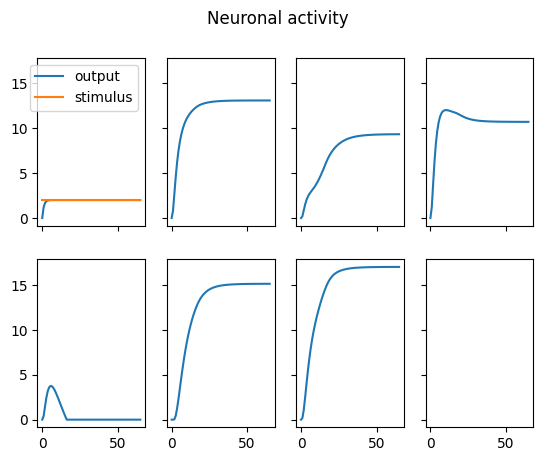

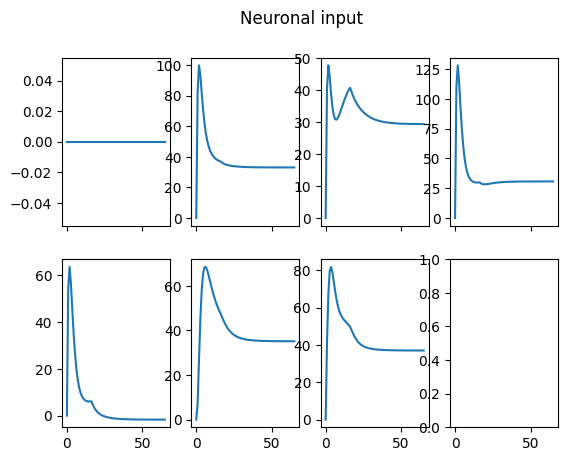

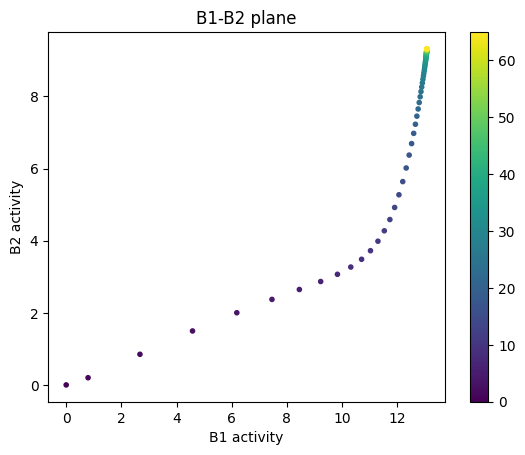

In [14]:
# Plots

# Activity plot

_, axs = plt.subplots(2, 4, sharex=True, sharey=True)
for ax, activity, input in zip(axs.flatten()[1:], states[1:], inputs[1:]):
    ax.plot(times, activity)
axs[0,0].plot(times, states[0])
s = model.stimulus
axs[0,0].plot(times, [s(t)[0] for t in times])
axs[0,0].legend(labels=['output', 'stimulus'])
plt.suptitle('Neuronal activity')
plt.show()

# Input plot
_, axs = plt.subplots(2, 4, sharex=True)
for ax, input in zip(axs.flatten(), inputs):
    ax.plot(times, input)
plt.suptitle('Neuronal input')
plt.show()

# B1-B2 plot

plt.figure()
plt.scatter(states[Neuron.B1,:], states[Neuron.B2,:], marker='.', c=times, cmap='viridis')

plt.colorbar()
plt.xlabel('B1 activity')
plt.ylabel('B2 activity')
plt.title('B1-B2 plane')
plt.show()

## Reproduce figure 3C - 3D

In [15]:
# Computations
n_weights = 11

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(.5,1.5,n_weights))
iLNb_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNb, 'excitatory', np.linspace(1.5,2.5,n_weights))

results = Model.compute_states_on_grid([], [iLNa_iterator, iLNb_iterator])

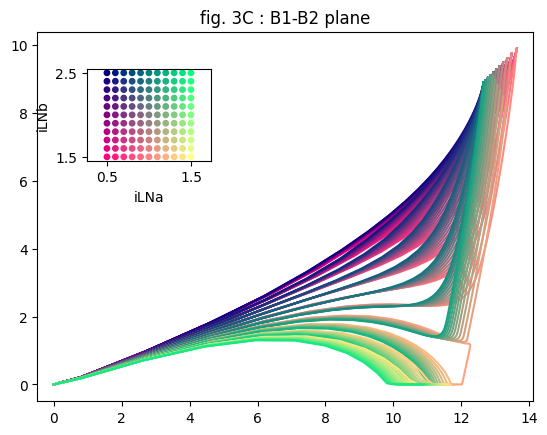

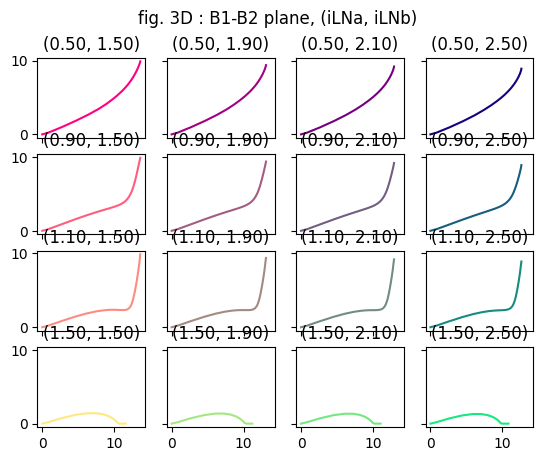

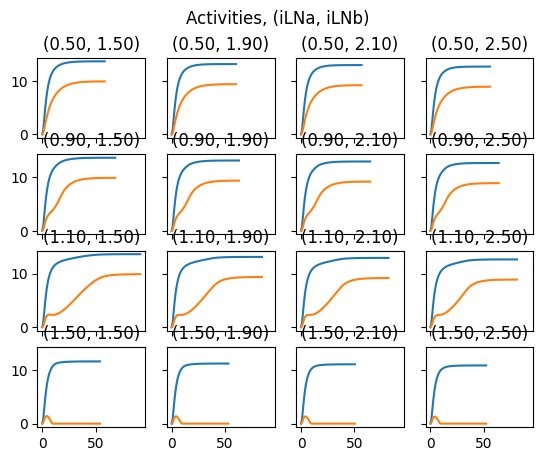

In [16]:
# Plots

def create_color_grid(N):
    j, i = np.meshgrid(np.arange(N), np.arange(N))
    return np.stack([1-j/N, i/N, .5*np.ones_like(i)], axis=2)

def plot_color_grid(ax, it1, it2):
    i, j = np.meshgrid(it1, it2)
    i, j= i.flatten(), j.flatten()
    mi, Mi = np.min(i), np.max(i)
    mj, Mj = np.min(j), np.max(j)
    ax.scatter(i,j, s=15, c=[(1-(y-mj)/(Mj-mj), (x-mi)/(Mi-mi), .5) for x, y in zip(i, j)])
    ax.set_xticks([mi,Mi])
    ax.set_yticks([mj,Mj])

def plot_phase_diagram(results, n_weights, title='fig. 3C : B1-B2 plane'):
    plt.figure()
    plt.title(title)
    plt.axis('equal')
    
    color_grid = create_color_grid(n_weights)
    for (i,iLNa), (j,iLNb) in itertools.product(enumerate(iLNa_iterator), enumerate(iLNb_iterator)):
        plt.plot(results[(iLNa, iLNb)].y[Neuron.B1,:], results[(iLNa, iLNb)].y[Neuron.B2,:], c=color_grid[i,j])

    subax = plt.gca().inset_axes([0.1,.65,.25,.25])
    plot_color_grid(subax, iLNa_iterator, iLNb_iterator)
    subax.axis('equal')
    subax.set_xlabel('iLNa')
    subax.set_ylabel('iLNb')
    plt.show()

plot_phase_diagram(results, n_weights)

idx_arr = [0, 4, 6, 10]

_, axs = plt.subplots(4, 4, sharex=True, sharey=True)
for i, j in itertools.product(range(4), range(4)):
    result = results[(iLNa_iterator[idx_arr[i]], iLNb_iterator[idx_arr[j]])]
    axs[i,j].plot(result.y[Neuron.B1,:], result.y[Neuron.B2,:], c=(1-idx_arr[j]/n_weights, idx_arr[i]/n_weights, .5))
    axs[i,j].set_title('({:.2f}, {:.2f})'.format(iLNa_iterator[idx_arr[i]], iLNb_iterator[idx_arr[j]]))
plt.suptitle('fig. 3D : B1-B2 plane, (iLNa, iLNb)')
plt.show()

_, axs = plt.subplots(4, 4, sharex=True, sharey=True)
for i, j in itertools.product(range(4), range(4)):
    result = results[(iLNa_iterator[idx_arr[i]], iLNb_iterator[idx_arr[j]])]
    axs[i,j].plot(result.t, result.y[Neuron.B1,:])
    axs[i,j].plot(result.t, result.y[Neuron.B2,:])
    axs[i,j].set_title('({:.2f}, {:.2f})'.format(iLNa_iterator[idx_arr[i]], iLNb_iterator[idx_arr[j]]))
plt.suptitle('Activities, (iLNa, iLNb)')
plt.show()


## Reproduce figure 3E, 3F

In [17]:
# Computations

rng = default_rng()
iLNa_arr, iLNb_arr = rng.uniform(.5,1.5,size=1000), rng.uniform(1.5,2.5,size=1000)

t_max = 450
results = []

for iLNa, iLNb in zip(iLNa_arr, iLNb_arr):
    model = Model(iLNa, iLNb)
    initial_state = np.zeros(N)

    sol = model.run(initial_state, t_max)

    results.append(sol.y[:,-1])
results = np.vstack(results)

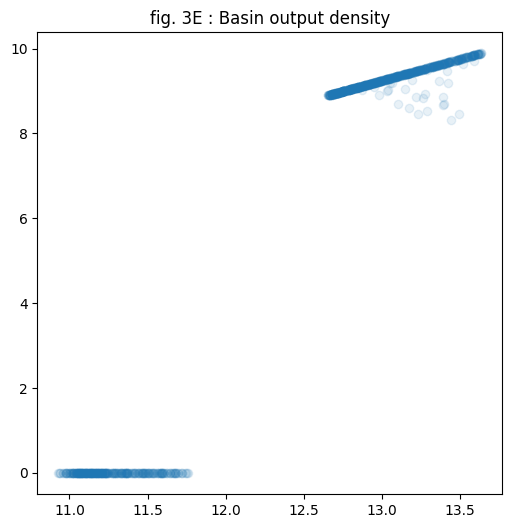

In [18]:
plt.figure(figsize=(6,6))
plt.title('fig. 3E : Basin output density')
plt.scatter(results[:,Neuron.B1], results[:,Neuron.B2], alpha=.1)
plt.show()

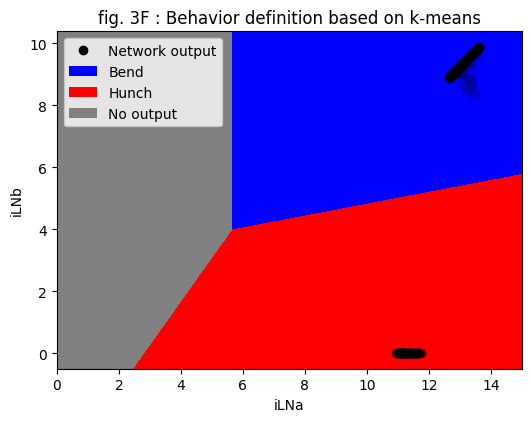

In [19]:
max_B1 = results[:,Neuron.B1].max()
max_B2 = results[:,Neuron.B2].max()

classifier = KMeans(n_clusters=3, init=np.array([[0,0], [max_B1, max_B2], [max_B1, 0]]), n_init=1)
classifier.fit(np.vstack([np.zeros((1,2)), results[:,[Neuron.B1, Neuron.B2]]]))
label = classifier.predict(results[:,[Neuron.B1, Neuron.B2]])

n_grid = 1000
xx, yy = np.meshgrid(np.linspace(0,1.1*max_B1,n_grid), np.linspace(-.05*max_B2,1.05*max_B2,n_grid))
grid = np.vstack((xx.flatten(), yy.flatten())).transpose()
label = classifier.predict(grid).reshape(n_grid,n_grid)
plt.figure(figsize=(6,6))
plt.imshow(label, extent=(0,1.1*max_B1,-.05*max_B2,1.05*max_B2), cmap=LinearSegmentedColormap.from_list('', ['grey', 'r', 'b'], N=3))
plt.scatter(results[:,Neuron.B1], results[:,Neuron.B2], c='k', alpha=.1)
plt.xlabel('iLNa')
plt.ylabel('iLNb')
plt.legend(handles=[Line2D([0], [0], marker='o', markerfacecolor='k', markeredgecolor='k', color=(0,0,0,0)), Patch(facecolor='b'), Patch(facecolor='r'), Patch(facecolor='grey')], 
           labels=['Network output', 'Bend', 'Hunch', 'No output'])
plt.title('fig. 3F : Behavior definition based on k-means')
plt.show()

In [20]:
# Computations

n_weights = 50
iLNa_arr = np.linspace(.5,1.5,n_weights)
iLNb_arr = np.linspace(1.5,2.5,n_weights)

t_max = 450
results = []

total = len(iLNa_arr)*len(iLNb_arr)
current = 0
for i, iLNa in enumerate(iLNa_arr):
    results.append([])
    for j, iLNb in enumerate(iLNb_arr):
        current += 1
        if not(current%(total//10)):
            print(current//(total//10), end='')
        
        model = Model(iLNa, iLNb)
        initial_state = np.zeros(N)

        sol = model.run(initial_state, t_max)

        results[-1].append(sol)

12345678910

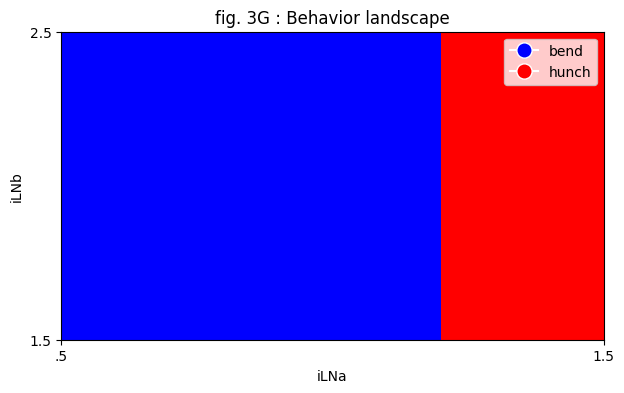

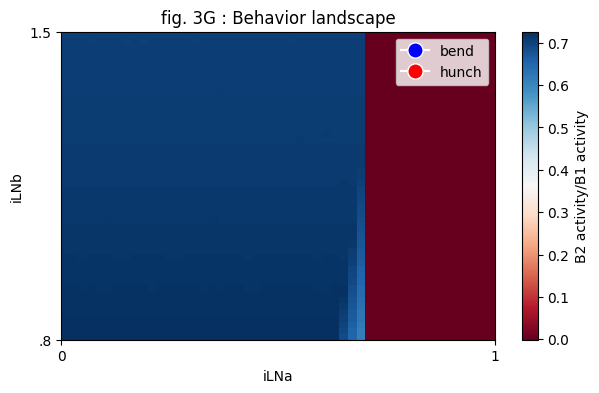

In [21]:
i_arr, j_arr = np.meshgrid(np.arange(n_weights, dtype=int), np.arange(n_weights, dtype=int))
i_arr, j_arr = i_arr.flatten(), j_arr.flatten()
end_states = np.vstack([results[i][j].y[[Neuron.B1, Neuron.B2], -1]for i, j in zip(i_arr,j_arr)])
ratios = end_states.reshape(-1,2)
ratios = ratios[:,1]/ratios[:, 0]
behavior = classifier.predict(end_states.reshape(-1,2))

i, j = np.meshgrid(iLNa_arr, iLNb_arr)
i, j= i.flatten(), j.flatten()
mi, Mi = np.min(i), np.max(i)
mj, Mj = np.min(j), np.max(j)

plt.figure(figsize=(7,4))
plt.title('fig. 3G : Behavior landscape')
plt.axis('equal')
plt.imshow(behavior.reshape(n_weights, n_weights), extent=[.5,1.5,1.5,2.5], origin='lower', aspect='auto', cmap=ListedColormap(['b', 'r']))
# plt.scatter(i,j,c=['r' if b == 2 else 'b' for b in behavior])
plt.legend(handles=[Line2D([0],[0],marker='o',color='w',markerfacecolor='b', markersize=11),
                    Line2D([0],[0],marker='o',color='w',markerfacecolor='r', markersize=11)],
           labels=['bend', 'hunch'], loc='upper right')
plt.xticks([.5,1.5], labels=['.5','1.5'])
plt.yticks([1.5,2.5], labels=['1.5','2.5'])
plt.xlabel('iLNa')
plt.ylabel('iLNb')
plt.show()

plt.figure(figsize=(7,4))
plt.title('fig. 3G : Behavior landscape')

plt.imshow(ratios.reshape(n_weights, n_weights), extent=[0,1,.8,1.5], origin='lower', aspect='auto', cmap='RdBu')
plt.colorbar().set_label('B2 activity/B1 activity')
plt.legend(handles=[Line2D([0],[0],marker='o',color='w',markerfacecolor='b', markersize=11),
                    Line2D([0],[0],marker='o',color='w',markerfacecolor='r', markersize=11)],
           labels=['bend', 'hunch'], loc='upper right')
plt.xticks([0, 1], labels=['0', '1'])
plt.yticks([.8,1.5], labels=['.8','1.5'])
plt.xlabel('iLNa')
plt.ylabel('iLNb')
plt.show()

# Hypothesis 1 : Sucrose presence induces an incoming current to fbLNHb which sensibilizes it to excitatory input

Modelling interpretation : $i$ contains a nonnegative term for fbLNHb in the sucrose state

## Reproducing behavior observations

Desired outcomes in presence of sucrose :
- frequency of hunch diminishes
- frequency of bend increases

$\implies$ modelling by varying Hb bias to model presence of sucrose and LNa coupling to model the variability in stimuli. 

$\implies$ The decision boundary should shift to increase the size of the bend domain as Hb input current augments.



In [22]:
# Computations

n_weights = 20

iLNb_initializer = SimpleInitializer(iLNb=2)
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
Hb_iterator = ParameterIterator(np.linspace(0,20,n_weights), lambda model, current : model.set_exogenous_current(Neuron.fbLNHb, current))

results = Model.compute_states_on_grid([iLNb_initializer], [iLNa_iterator, Hb_iterator])


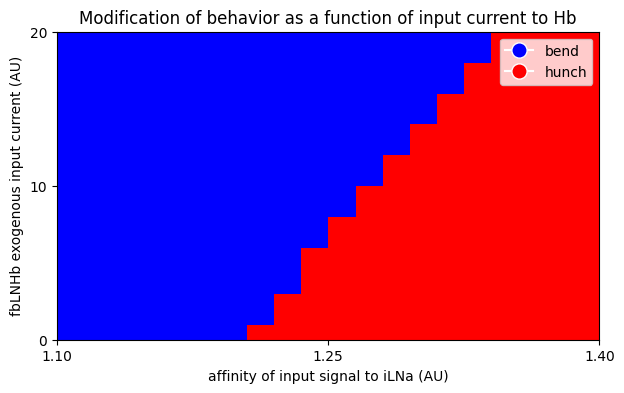

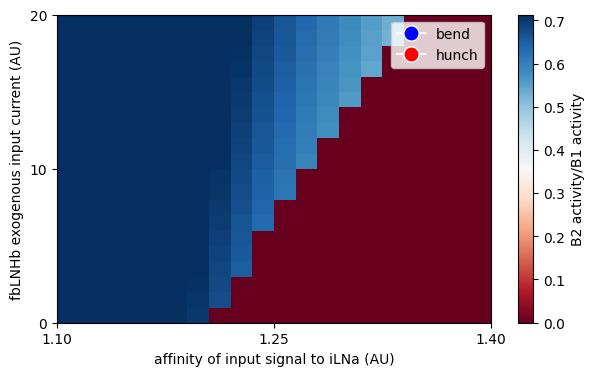

In [23]:
results.plot_behavior_diagram(classifier)
plt.title('Modification of behavior as a function of input current to Hb')
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('fbLNHb exogenous input current (AU)')
plt.savefig('outputs/behavior_phase_diagram_with_input_current_to_handleB.pdf')
plt.show()

results.plot_ratio_diagram()
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('fbLNHb exogenous input current (AU)')
plt.savefig('outputs/ratios_phase_diagram_with_input_current_to_handleB.pdf')
plt.show()

The basic prediction is verified. The size of the bend domain increases as Hb input current augments.

Tihana is also interested in verifying that iLNa activity decreases as input current increases. Let's look into it.

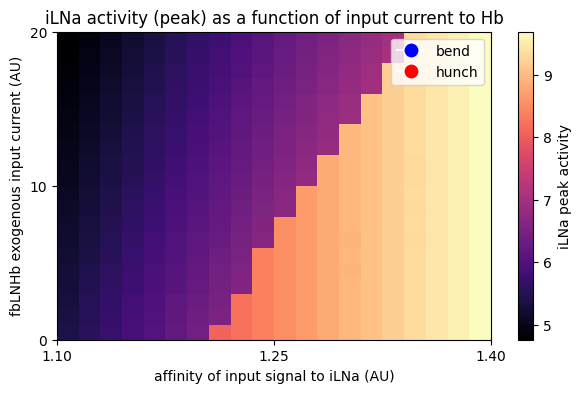

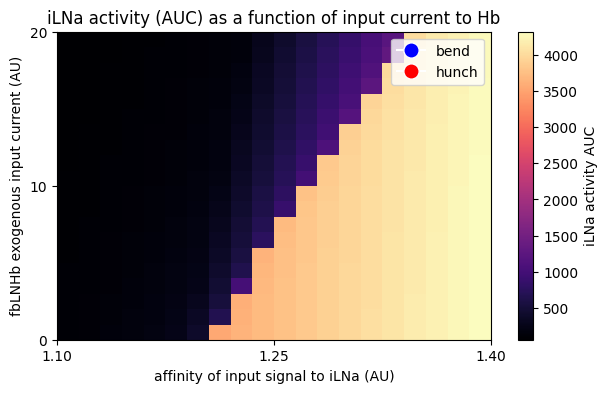

In [24]:
results.plot_output_diagram(lambda r: r.y[Neuron.iLNa,:].max(), cmap='magma', label='iLNa peak activity')

plt.title('iLNa activity (peak) as a function of input current to Hb')
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('fbLNHb exogenous input current (AU)')
plt.savefig('outputs/iLNa_peak_diagram_with_input_current_to_handleB.pdf')
plt.show()


def AUC(r):
    return np.sum(np.convolve(r.y[Neuron.iLNa,:], [0.5,0.5], mode='valid')*np.diff(r.t)) + (results.t_max-r.t[-1])*r.y[Neuron.iLNa, -1]
results.plot_output_diagram(AUC, cmap='magma', label='iLNa activity AUC')
plt.title('iLNa activity (AUC) as a function of input current to Hb')
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('fbLNHb exogenous input current (AU)')
plt.show()

As input current increases, iLna activity decreases, with a very sharp transition towards a lower level at the boundary between behaviors.

 Let's look at silencing experiments.

## Silencing experiments 

1. silencing fbLNHb in presence of sucrose results in increased activity of LNa 
2. silencing LNA in fed state results in increased activity of Hb
3. silencing LNA in sucrose state results in no change of Hb activity

We model the fed state as having no input current on Hb and the sucrose state as having a 10 AU input current on Hb. We compare the trajectories with and without silencing across the range of iLNa inputs.

### Reproducing first silencing experiment : silencing fbLNHb in presence of sucrose results in increased activity of LNa 

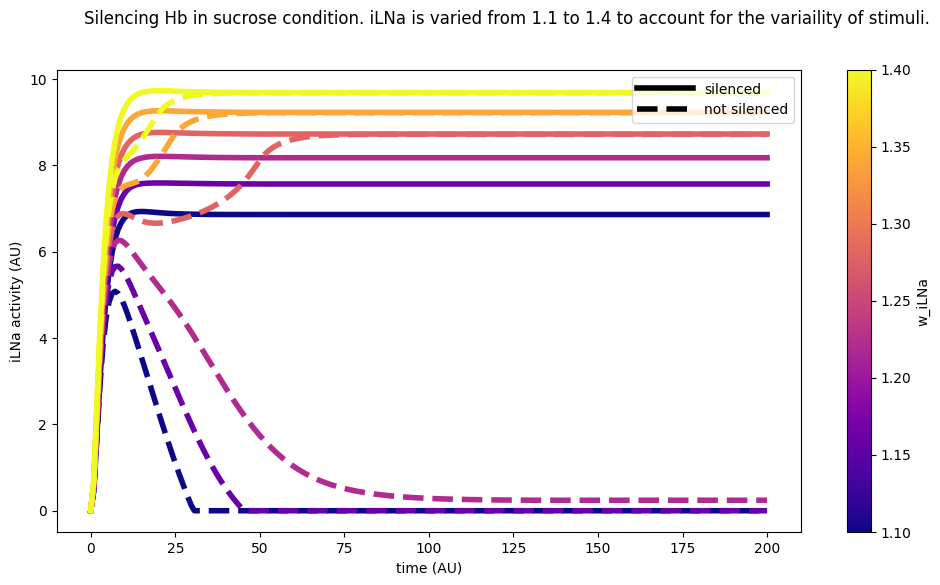

In [25]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)
currentHb_initializer = ModelInitializer(lambda model: model.set_exogenous_current(Neuron.fbLNHb, 10))

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencingHb_iterator = SilencingIterator(Neuron.fbLNHb)

results = Model.compute_states_on_grid([iLNb_initializer, currentHb_initializer],
                                [iLNa_iterator, silencingHb_iterator])

fig = results.plot_silencing_curves(Neuron.iLNa, xlabel='time (AU)', ylabel='iLNa activity (AU)', prefix='iLNa = ', max_time=200)
fig.suptitle('Silencing Hb in sucrose condition. iLNa is varied from 1.1 to 1.4 to account for the variaility of stimuli.')
plt.savefig('outputs/model_input_current_to_handleB/handleB_silencing_in_sucrose_state_with_input_current_to_handleB.pdf')
plt.show()

The result is reproduced : silencing Hb in the sucrose state increases the activity of Hb.

### Reproducing the second silencing experiment : silencing LNA in fed state results in increased activity of Hb

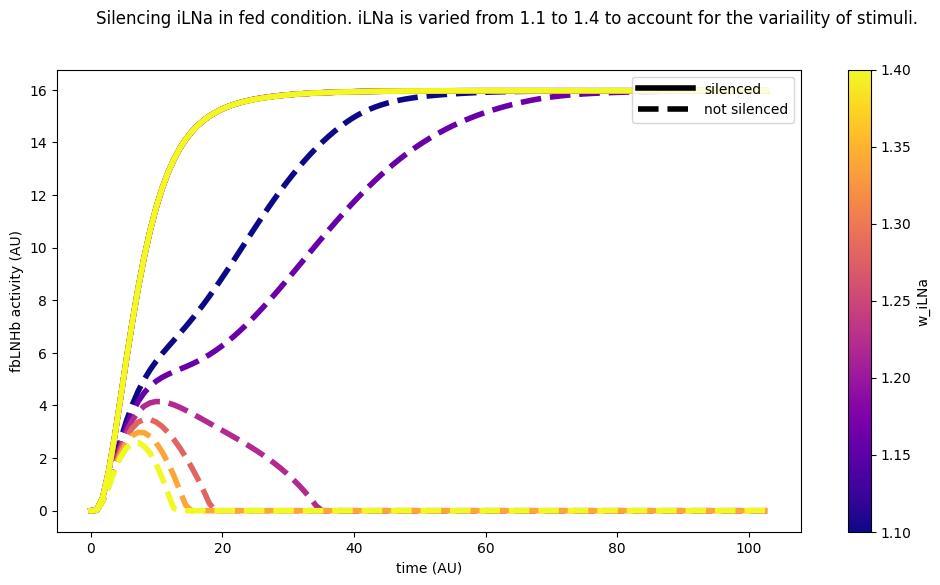

In [26]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencingiLNa_iterator = SilencingIterator(Neuron.iLNa)

results = Model.compute_states_on_grid([iLNb_initializer],
                                [iLNa_iterator, silencingiLNa_iterator])

fig = results.plot_silencing_curves(Neuron.fbLNHb, xlabel='time (AU)', ylabel='fbLNHb activity (AU)', prefix='iLNa = ', max_time=200)
fig.suptitle('Silencing iLNa in fed condition. iLNa is varied from 1.1 to 1.4 to account for the variaility of stimuli.')
plt.savefig('outputs/model_input_current_to_handleB/iLNA_silencing__in_fed_state_with_input_current_to_handleB.pdf')
plt.show()

The result is reproduced : silencing iLNa in the fed state increase Hb activity.

### Reproducing third silencing experiment : silencing LNA in sucrose state results in no change of Hb activity

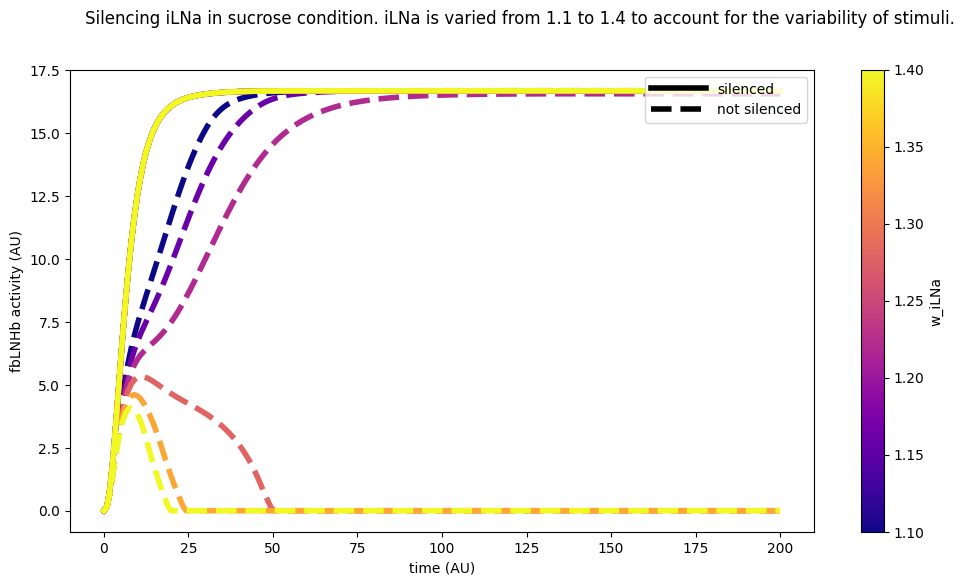

In [27]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)
currentHb_initializer = ModelInitializer(lambda model: model.set_exogenous_current(Neuron.fbLNHb, 10))

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencingiLNa_iterator = SilencingIterator(Neuron.iLNa)

results = Model.compute_states_on_grid([iLNb_initializer, currentHb_initializer],
                                [iLNa_iterator, silencingiLNa_iterator])

fig = results.plot_silencing_curves(Neuron.fbLNHb, xlabel='time (AU)', ylabel='fbLNHb activity (AU)', prefix='iLNa = ', max_time=200)
plt.savefig('outputs/model_input_current_to_handleB/iLNA_silencing_in_sucrose_state_with_input_current_to_handleB.pdf')
fig.suptitle('Silencing iLNa in sucrose condition. iLNa is varied from 1.1 to 1.4 to account for the variability of stimuli.')
plt.show()

The result is **not** reproduced by the model in the sucrose/iLNa silencing experiment : silencing iLNa has a large impact on Hb activity.

## Silencing Handle B in fed state

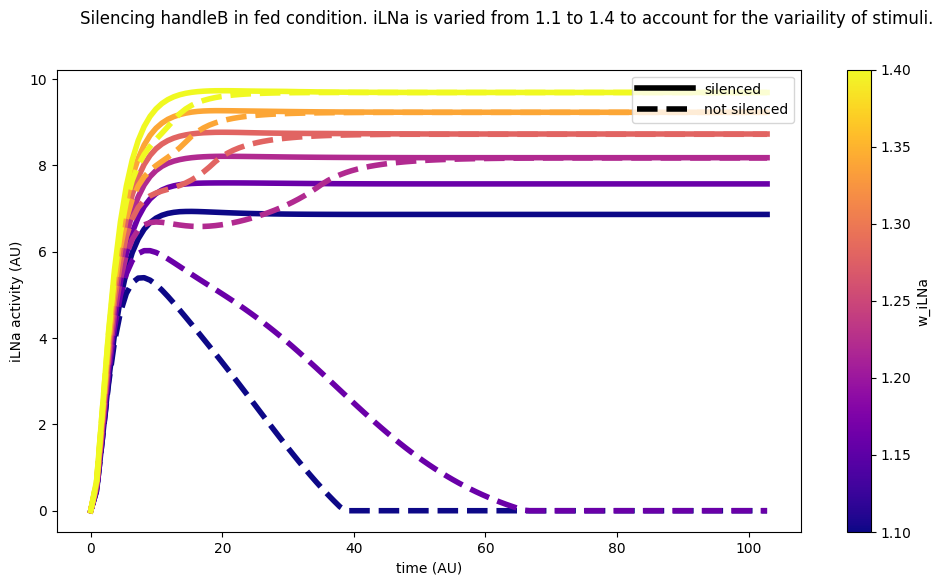

In [28]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencinghandleB_iterator = SilencingIterator(Neuron.fbLNHb)

results = Model.compute_states_on_grid([iLNb_initializer],
                                [iLNa_iterator, silencinghandleB_iterator])

fig = results.plot_silencing_curves(Neuron.iLNa, xlabel='time (AU)', ylabel='iLNa activity (AU)', prefix='iLNa = ', max_time=200)
fig.suptitle('Silencing handleB in fed condition. iLNa is varied from 1.1 to 1.4 to account for the variaility of stimuli.')
plt.savefig('outputs/model_input_current_to_handleB/handleB_silencing_in_fed_state_with_input_current_to_handleB.pdf')
plt.show()

## Phase diagram modification on silencing

### Effect on behaviour output of HandleB silencing.

Let us compute full behavior diagrams for fed/sucrose states, with HandleB silenced/not silenced, with the sucrose state defined as an input current of 10 AU as for the other silencing experiments.

In [18]:
n_weights = 100

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, "excitatory", np.linspace(.5,1.5,n_weights))
iLNb_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNb, "excitatory", np.linspace(1.5,2.5,n_weights))
silencingHb_iterator = SilencingIterator(Neuron.fbLNHb)
internalStateIterator = ParameterIterator(["fed", "sucrose"], lambda m, p : m.set_exogenous_current(Neuron.fbLNHb, 0 if p == "fed" else 10))

results = Model.compute_states_on_grid([], [internalStateIterator, silencingHb_iterator, iLNa_iterator, iLNb_iterator])

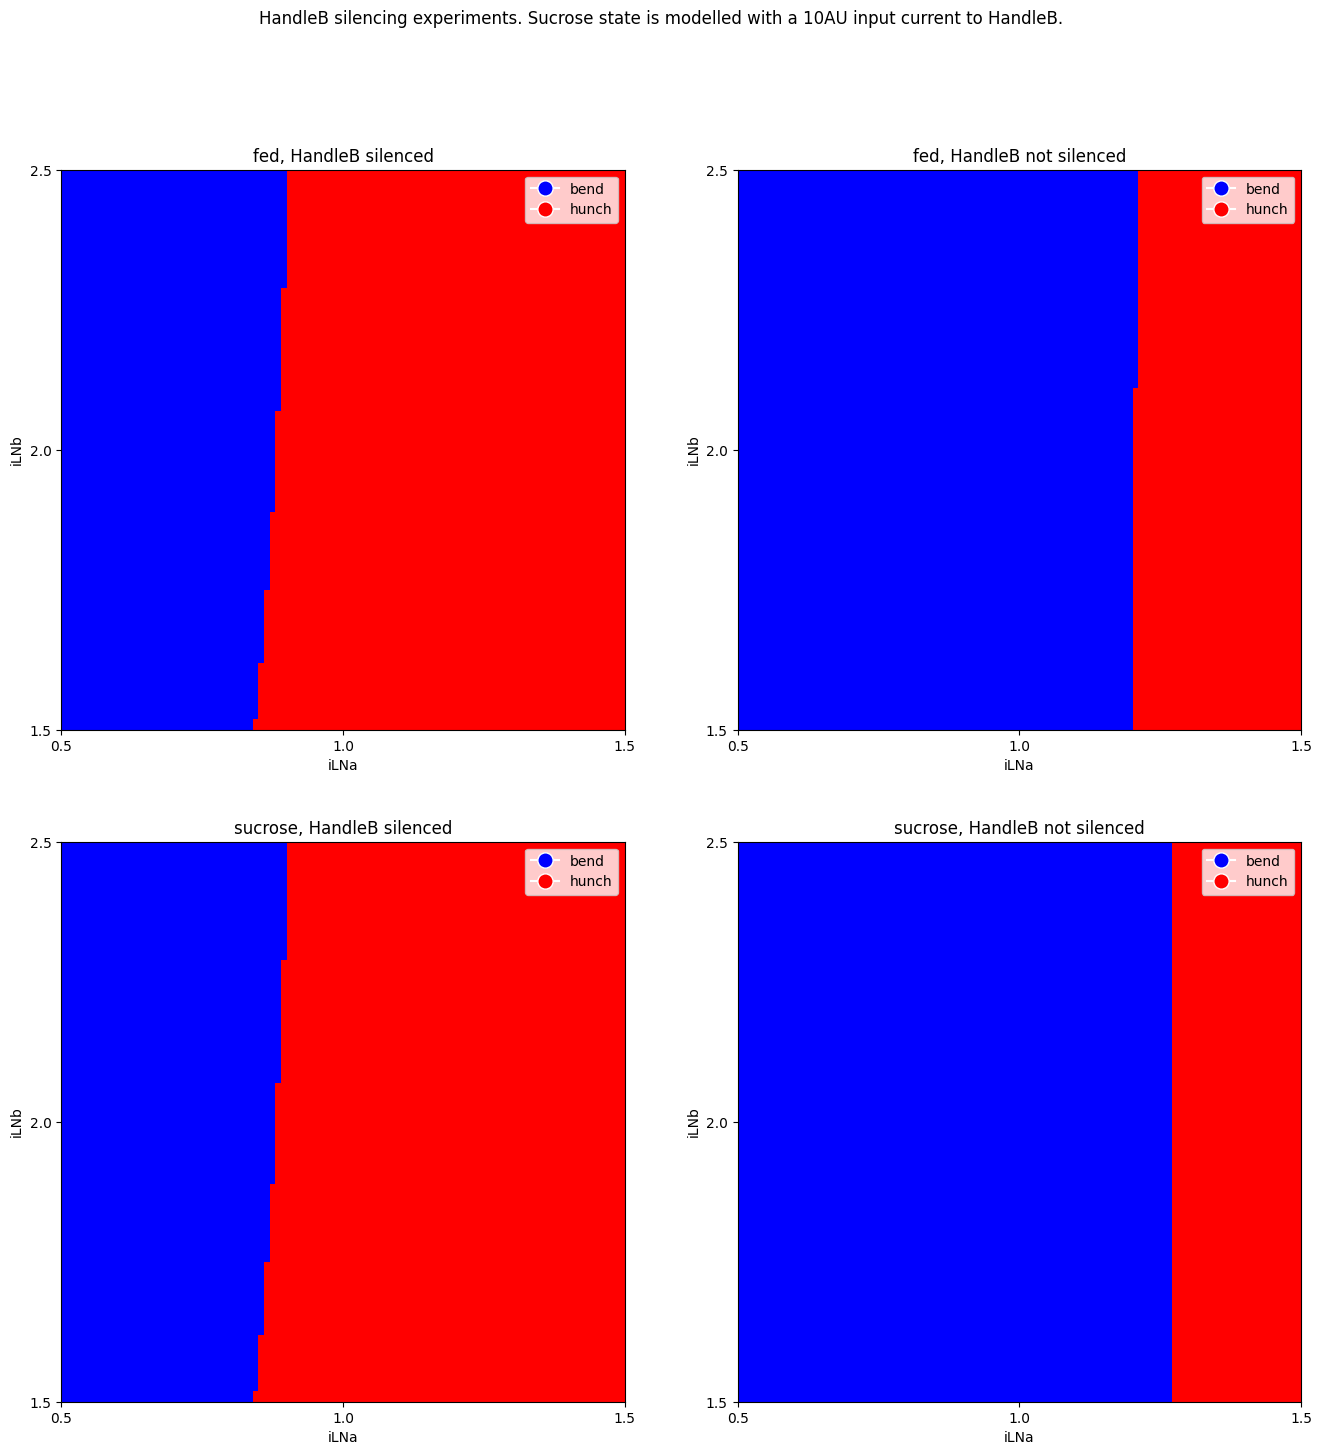

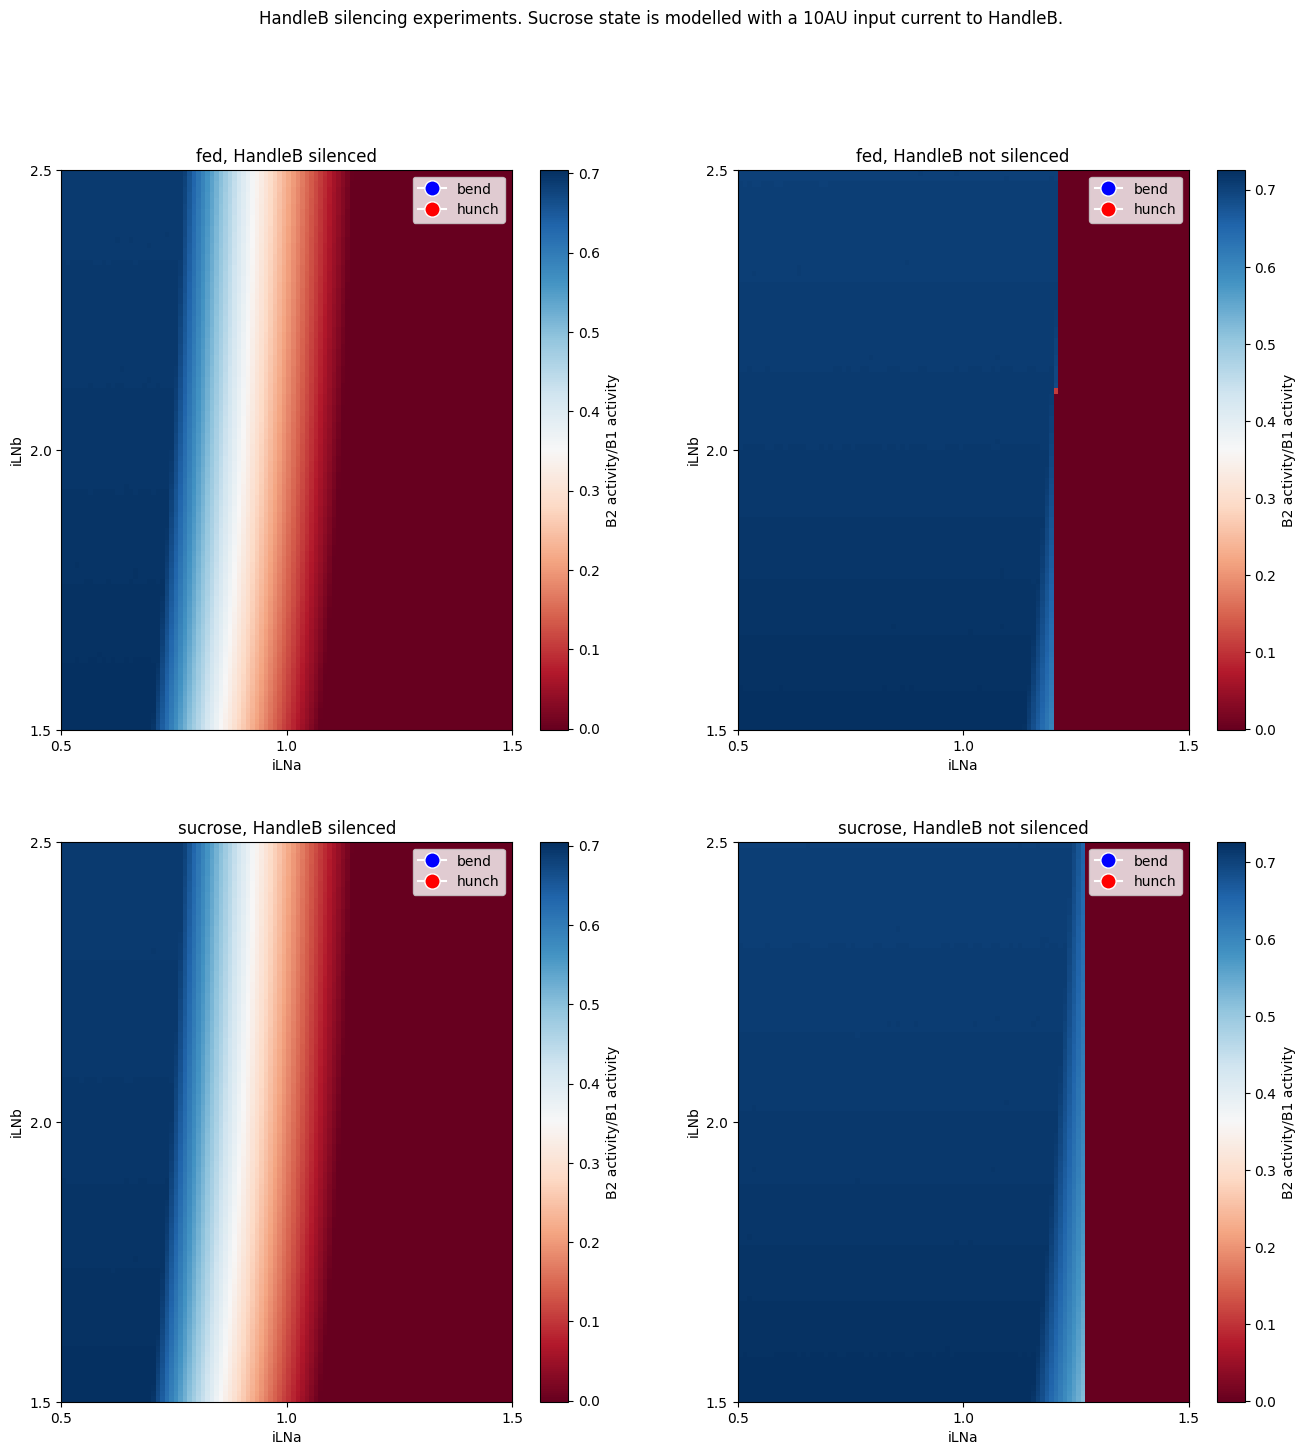

In [19]:
import itertools

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('HandleB silencing experiments. Sucrose state is modelled with a 10AU input current to HandleB.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_behavior_diagram(classifier, [iLNa_iterator, iLNb_iterator], (condition, silencing), ax)

    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', HandleB ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/behavior_phase_diagram_modification_under_HandleB_silencing_with_input_current_to_handleB.pdf')
plt.show()

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('HandleB silencing experiments. Sucrose state is modelled with a 10AU input current to HandleB.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_ratio_diagram([iLNa_iterator, iLNb_iterator], (condition, silencing), ax)
    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', HandleB ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/ratios_phase_diagram_modification_under_HandleB_silencing_with_input_current_to_handleB.pdf')
plt.show()

### Effect on behaviour output of iLNa silencing.

Let us compute full behavior diagrams for fed/sucrose states, with iLNa silenced/not silenced, with the sucrose state defined as an input current of 10 AU as for the other silencing experiments.

In [29]:
n_weights = 100

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, "excitatory", np.linspace(.5,1.5,n_weights))
iLNb_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNb, "excitatory", np.linspace(1.5,2.5,n_weights))
silencingiLNa_iterator = SilencingIterator(Neuron.iLNa)
internalStateIterator = ParameterIterator(["fed", "sucrose"], lambda m, p : m.set_exogenous_current(Neuron.fbLNHb, 0 if p == "fed" else 10))

results = Model.compute_states_on_grid([], [internalStateIterator, silencingiLNa_iterator, iLNa_iterator, iLNb_iterator])

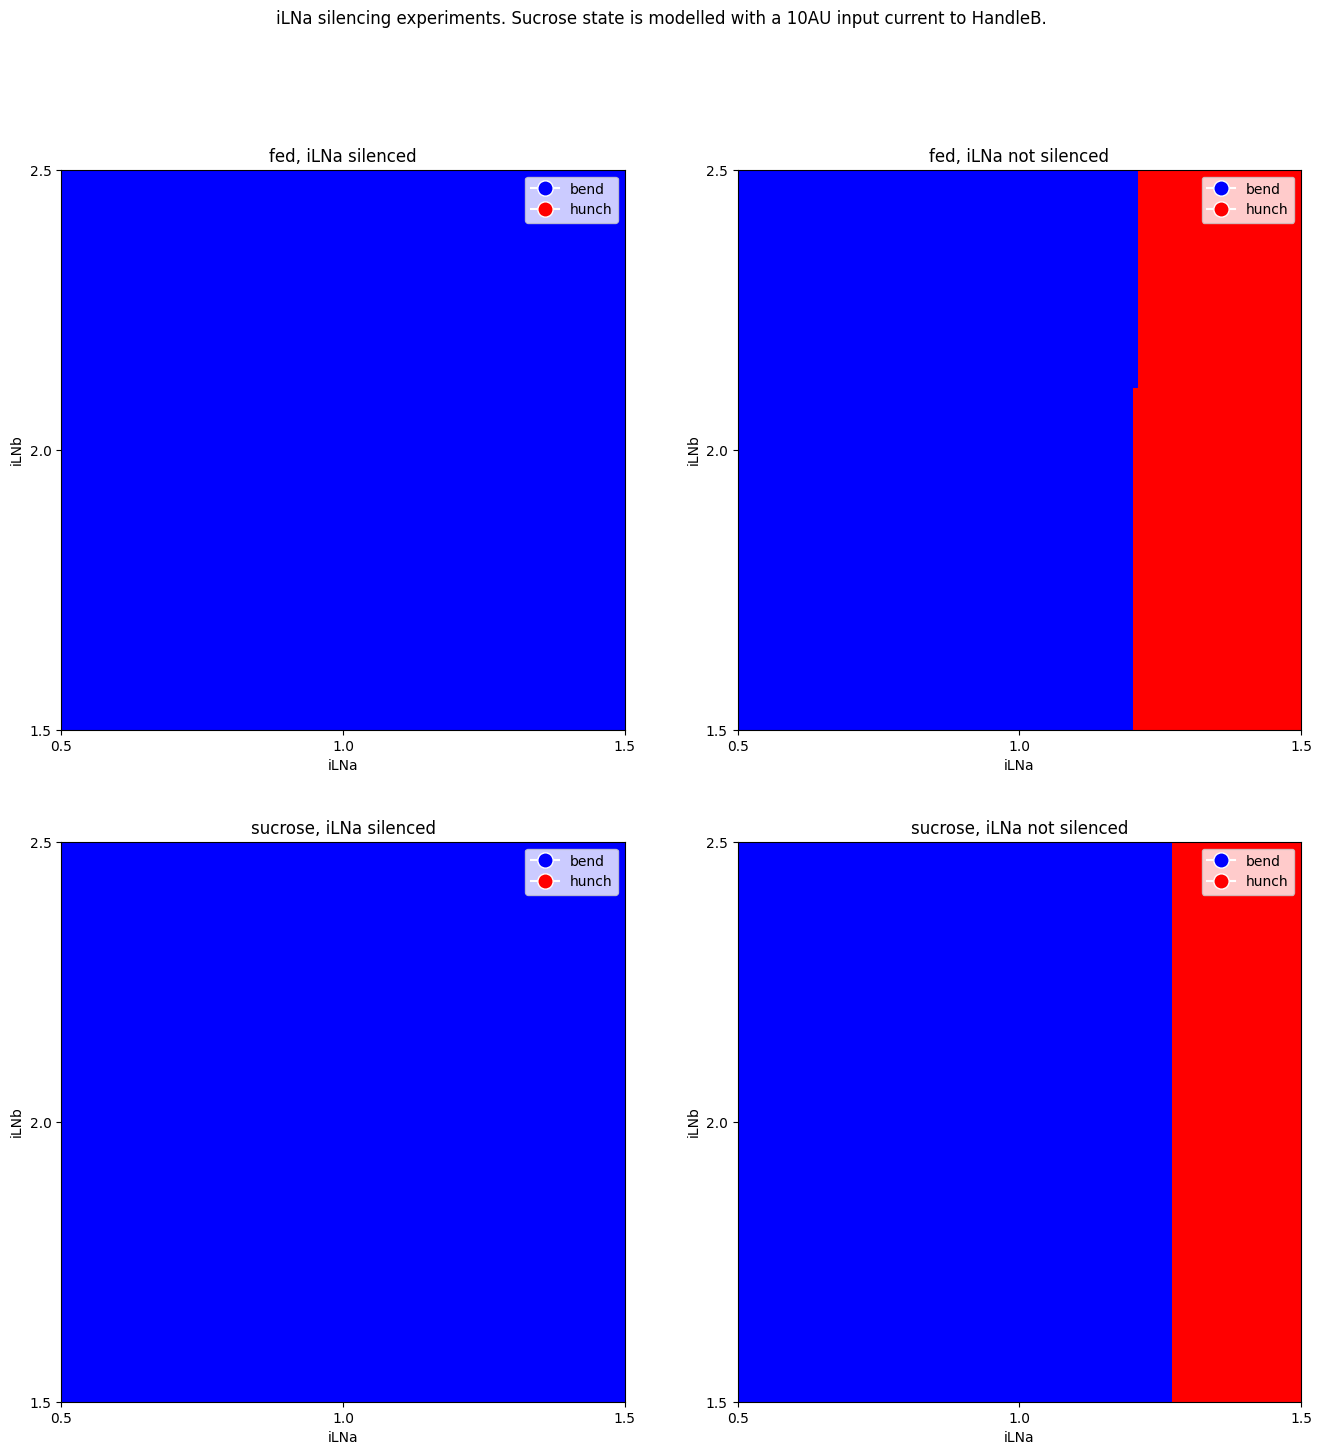

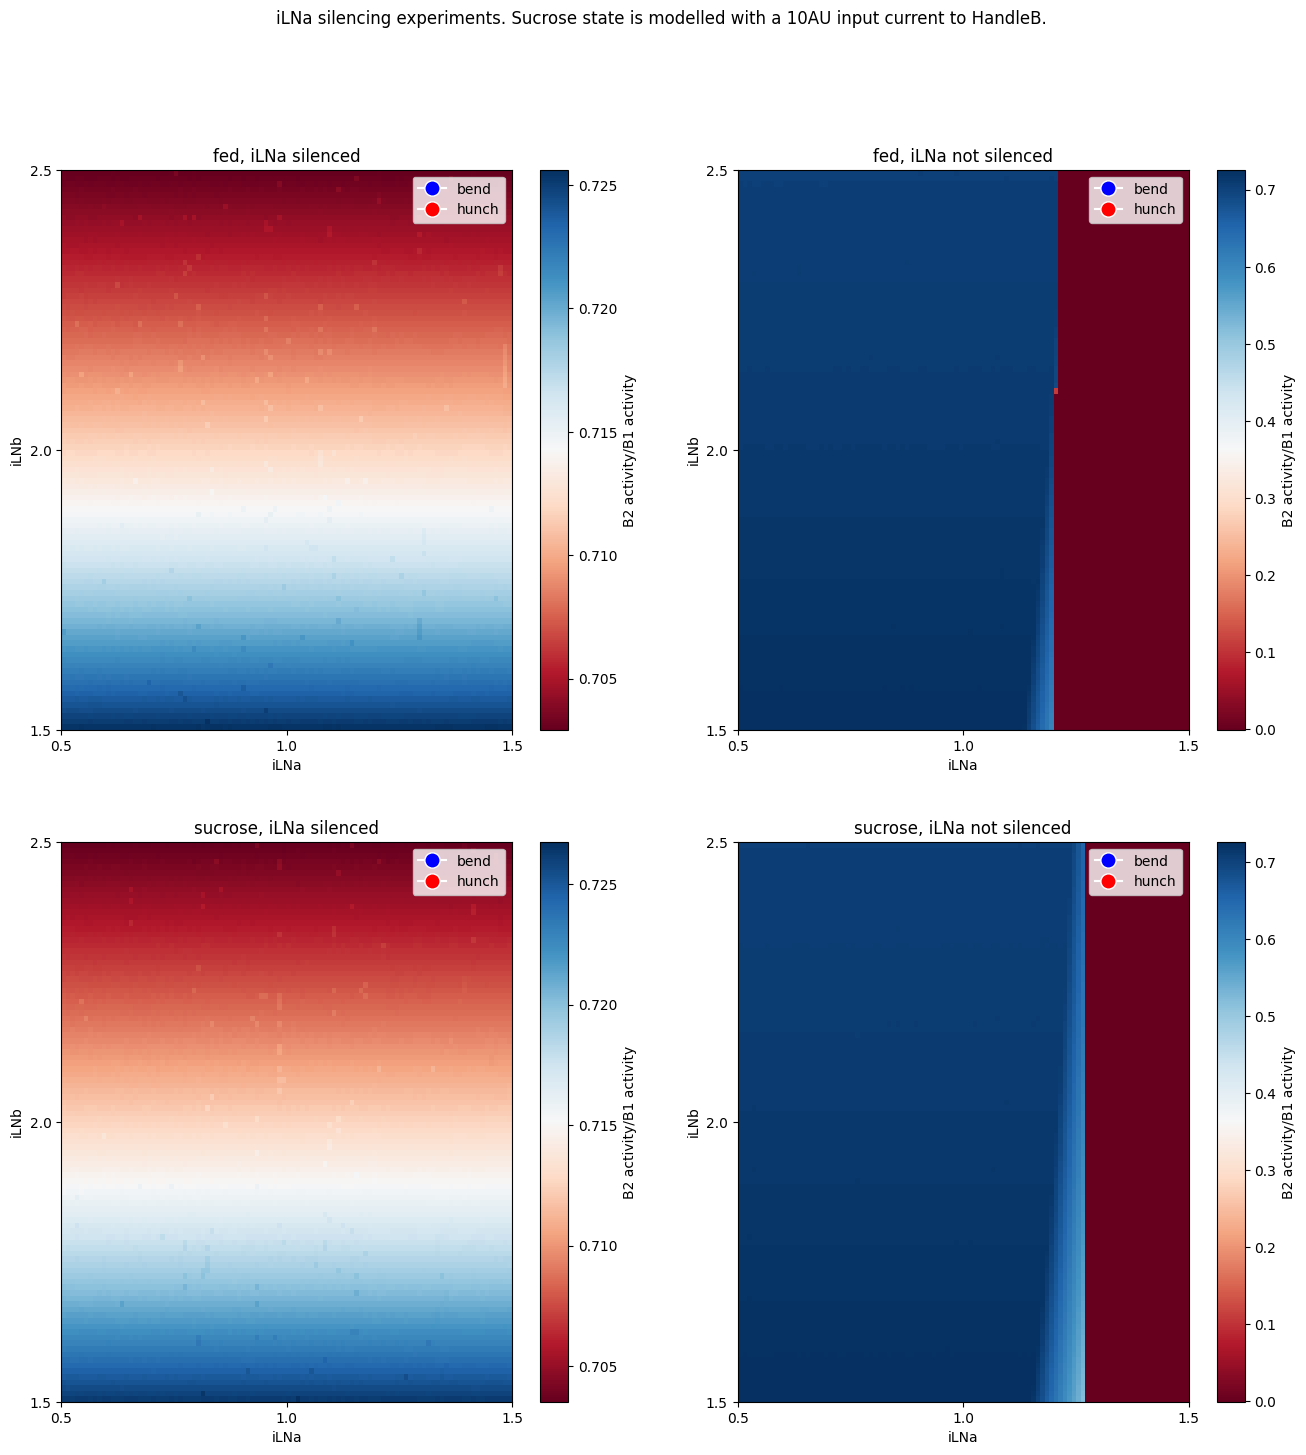

In [30]:
import itertools

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('iLNa silencing experiments. Sucrose state is modelled with a 10AU input current to HandleB.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_behavior_diagram(classifier, [iLNa_iterator, iLNb_iterator], (condition, silencing), ax)

    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', iLNa ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/model_input_current_to_handleB/behavior_phase_diagram_modification_under_iLNa_silencing_with_input_current_to_handleB.pdf')
plt.show()

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('iLNa silencing experiments. Sucrose state is modelled with a 10AU input current to HandleB.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_ratio_diagram([iLNa_iterator, iLNb_iterator], (condition, silencing), ax)
    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', iLNa ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/model_input_current_to_handleB/ratios_phase_diagram_modification_under_iLNa_silencing_with_input_current_to_handleB.pdf')
plt.show()

## Complete phase diagram

In [22]:
# Computations

n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
Hb_iterator = ParameterIterator(np.linspace(0,20,n_weights), lambda model, current : model.set_exogenous_current(Neuron.fbLNHb, current))

results = Model.compute_states_on_grid([iLNb_initializer], [iLNa_iterator, Hb_iterator])

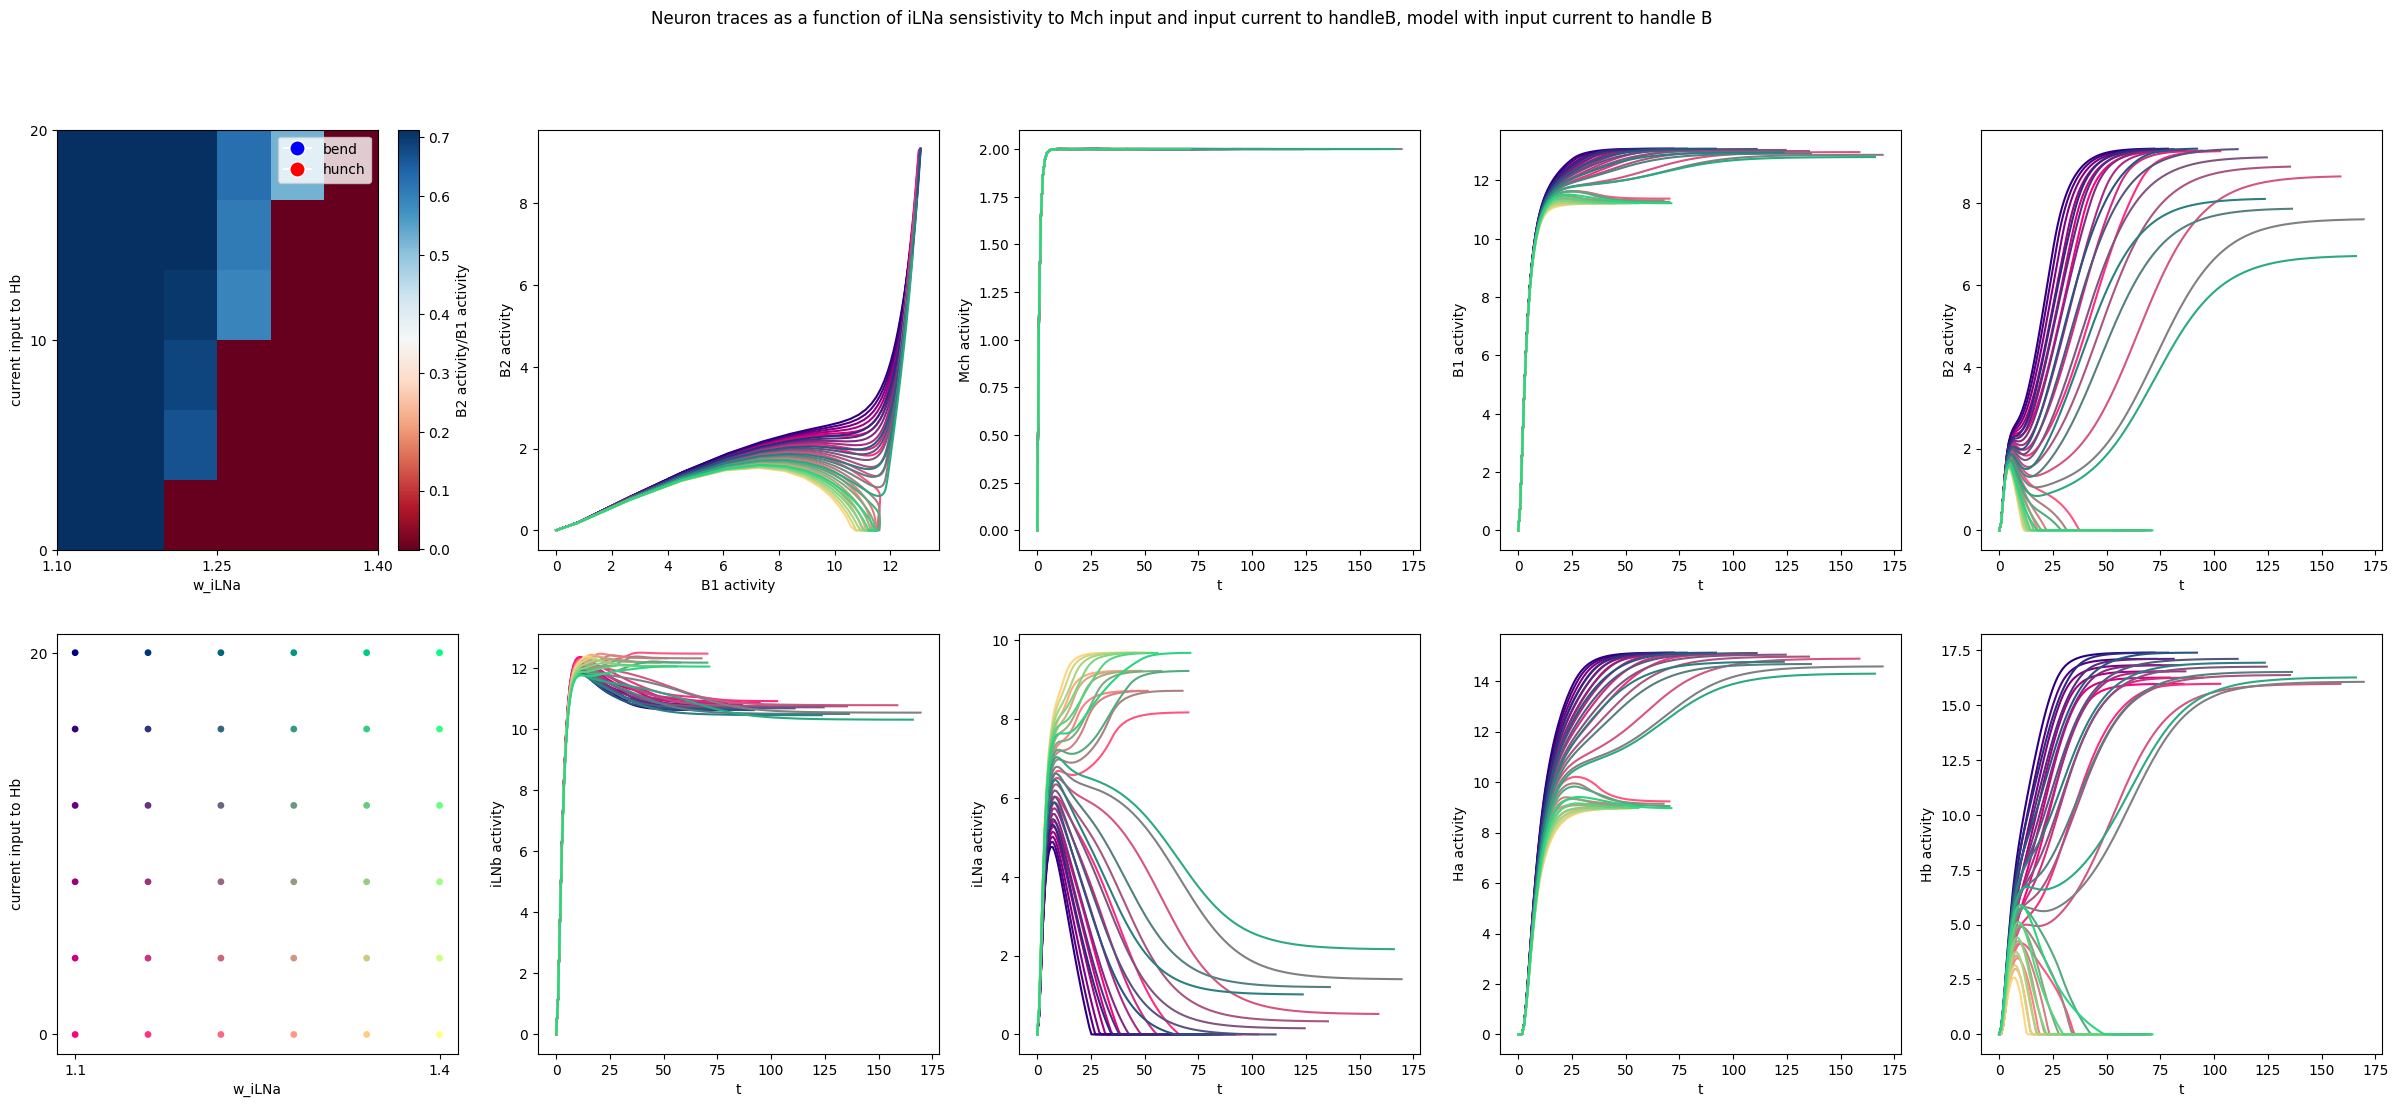

In [23]:
color_grid = create_color_grid(n_weights)

fig, axs = plt.subplots(2,5, figsize=(30,12))

results.plot_ratio_diagram(axs[0,0])
axs[0,0].set_xlabel('w_iLNa')
axs[0,0].set_ylabel('current input to Hb')
plot_color_grid(axs[1,0], iLNa_iterator, Hb_iterator)
axs[1,0].set_xlabel('w_iLNa')
axs[1,0].set_ylabel('current input to Hb')

for (iLNa, Hb_curr), c in zip(itertools.product(iLNa_iterator, Hb_iterator), color_grid.reshape(-1,3)):
    res = results[(iLNa, Hb_curr)]
    axs[0,1].plot(res.y[Neuron.B1], res.y[Neuron.B2], c=c)

    for ax_idx, neuron, neuron_name in zip([(0,2), (0,3), (0,4), (1,1), (1,2), (1,3), (1,4)],
                                           range(7),
                                           ['Mch', 'B1', 'B2', 'iLNb','iLNa', 'Ha', 'Hb']):
        axs[ax_idx].plot(res.t, res.y[neuron], c=c)

for ax_idx, neuron_name in zip([(0,2), (0,3), (0,4), (1,1), (1,2), (1,3), (1,4)],
                               ['Mch', 'B1', 'B2', 'iLNb','iLNa', 'Ha', 'Hb']):
        axs[ax_idx].set_xlabel('t')
        axs[ax_idx].set_ylabel(neuron_name + ' activity')
axs[0,1].set_xlabel('B1 activity')
axs[0,1].set_ylabel('B2 activity')

fig.suptitle('Neuron traces as a function of iLNa sensistivity to Mch input and input current to handleB, model with input current to handle B')
plt.savefig('outputs/model_input_current_to_handleB/phase_diagram_with_neuron_traces_with_input_current_to_handleB.pdf')  

plt.show()

## Compare fed and sucrose neuron trajectories

In [24]:
n_weights = 10

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, "excitatory", np.linspace(.5,1.5,n_weights))
iLNb_initializer = SimpleInitializer(iLNb=2)
internalStateIterator = ParameterIterator(["fed", "sucrose"], lambda m, p : m.set_exogenous_current(Neuron.fbLNHb, 0 if p == "fed" else 10))

results = Model.compute_states_on_grid([iLNb_initializer], [internalStateIterator, iLNa_iterator])

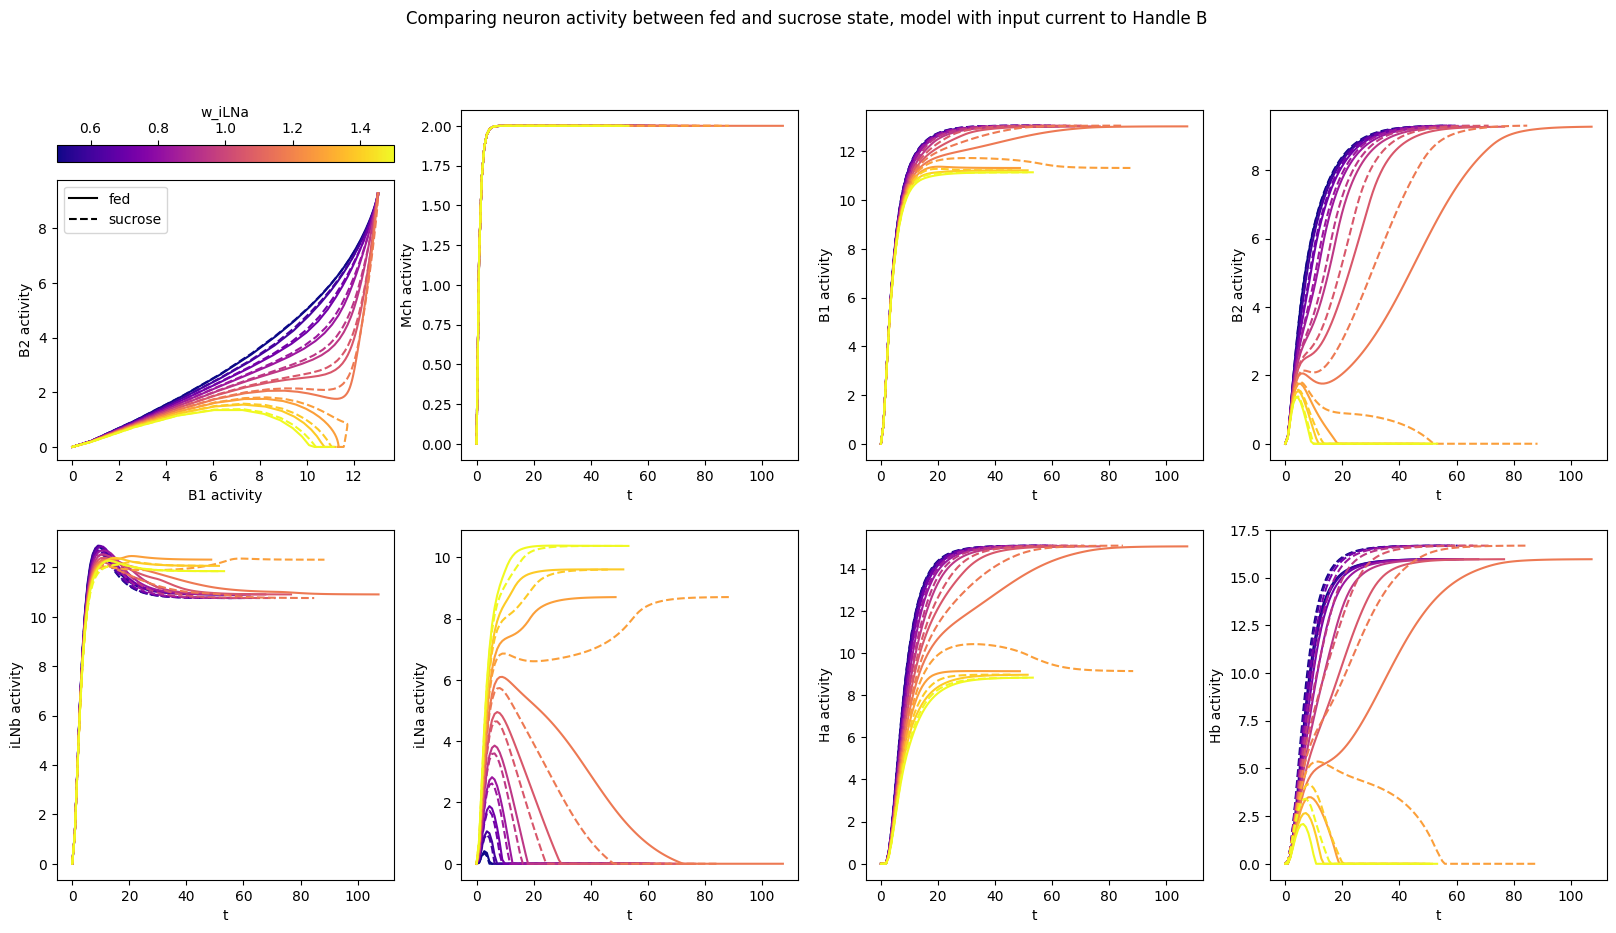

In [25]:
from matplotlib import colormaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = colormaps['plasma']
norm = Normalize(vmin=min(iLNa_iterator), vmax=max(iLNa_iterator))

fig, axs = plt.subplots(2,4, figsize=(20,10))

for iLNa in iLNa_iterator:
    r_fed = results[("fed", iLNa)]
    s_fed = results[("sucrose", iLNa)]
    axs[0,0].plot(r_fed.y[Neuron.B1], r_fed.y[Neuron.B2], color=cmap(norm(iLNa)), ls='-')
    axs[0,0].plot(s_fed.y[Neuron.B1], s_fed.y[Neuron.B2], color=cmap(norm(iLNa)), ls='--')

    for neuron, ax in zip(range(7), axs.ravel()[1:]):
        ax.plot(r_fed.t, r_fed.y[neuron], color=cmap(norm(iLNa)), ls='-')
        ax.plot(s_fed.t, s_fed.y[neuron], color=cmap(norm(iLNa)), ls='--')

axs[0,0].legend(handles=[Line2D([0],[0],ls='-',c='k'), Line2D([0],[0], ls='--', c='k')], labels=['fed', 'sucrose'])
plt.colorbar(ScalarMappable(norm, cmap), ax=axs[0,0], label='w_iLNa', location='top')
axs[0,0].set_xlabel('B1 activity')
axs[0,0].set_ylabel('B2 activity')

for neuron_name, ax in zip(['Mch', 'B1', 'B2', 'iLNb','iLNa', 'Ha', 'Hb'], axs.ravel()[1:]):
    ax.set_xlabel('t')
    ax.set_ylabel(neuron_name+' activity')
    
fig.suptitle('Comparing neuron activity between fed and sucrose state, model with input current to Handle B')
plt.savefig('outputs/model_input_current_to_handleB/fed_vs_sucrose_neuron_activities_with_input_current_to_handleB.pdf')
plt.show()

# Hypothesis 2 : Sucrose reduces peak activity in iLNa

iLNa caanot spike as much, which coincides with a decreased $r_{max}$

![](griddle2_GCaMP.png)

Looking at the peak values in Calcium imaging it seems that peak activity is divided by a factor of 3.3 (from 127px to 38px).

Accordingly, I propose to divide the value of $r_{max}$ such that the average ratio between peaks is roughly equal to this. The two following code cells allows calibration by hand. I end up using a $r_{max}$ of 14.


In [26]:
# Computations

n_weights = 20
iLNa_arr = np.linspace(.5,1.5,n_weights)
iLNb_arr = np.linspace(1.5,2.5,n_weights)

modified_rmax = 14

t_max = 450
results = []
results_modified_rmax = []

total = len(iLNa_arr)*len(iLNb_arr)
current = 0
for i, iLNa in enumerate(iLNa_arr):
    results.append([])
    results_modified_rmax.append([])
    for j, iLNb in enumerate(iLNb_arr):
        current += 1
        if not(current%(total//10)):
            print(current//(total//10), end='')
        
        model = Model(iLNa, iLNb)
        initial_state = np.zeros(N)
        sol = model.run(initial_state, t_max)
        results[-1].append(sol)

        model = Model(iLNa, iLNb)
        model.set_r_max(Neuron.iLNa, modified_rmax)
        initial_state = np.zeros(N)
        sol = model.run(initial_state, t_max)
        results_modified_rmax[-1].append(sol)

12345678910

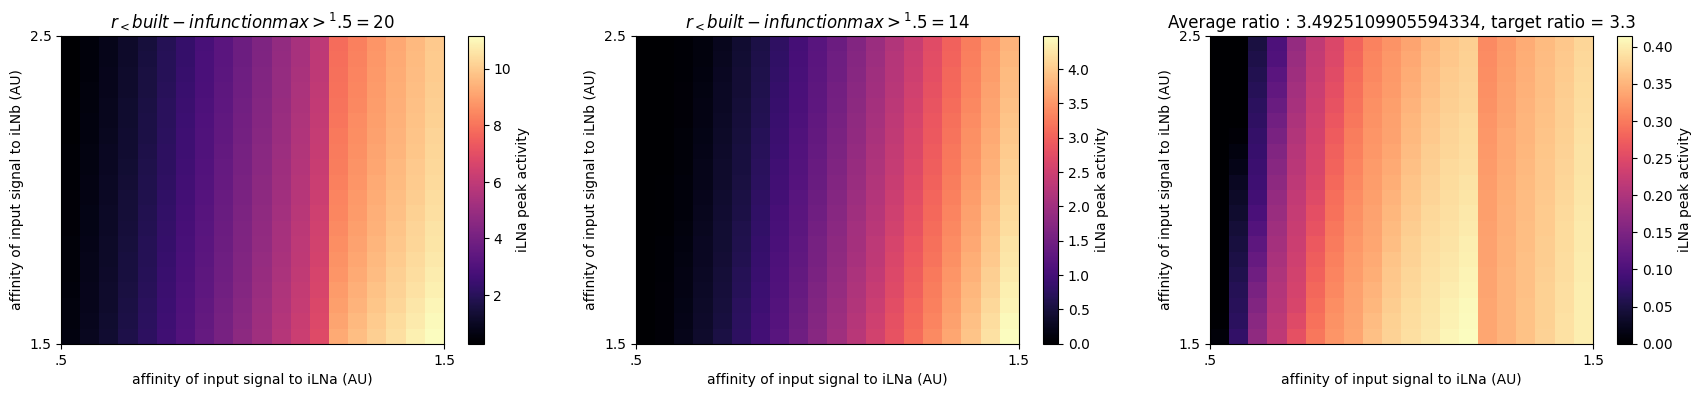

In [27]:
i_arr, j_arr = np.meshgrid(np.arange(n_weights, dtype=int), np.arange(n_weights, dtype=int))
i_arr, j_arr = i_arr.flatten(), j_arr.flatten()


iLNa_max_modified_rmax = np.vstack([results_modified_rmax[i][j].y[Neuron.iLNa].max() for i, j in zip(i_arr, j_arr)])
iLNa_max = np.vstack([results[i][j].y[Neuron.iLNa].max() for i, j in zip(i_arr, j_arr)])


i, j = np.meshgrid(iLNa_arr, iLNb_arr)
i, j= i.flatten(), j.flatten()
mi, Mi = np.min(i), np.max(i)
mj, Mj = np.min(j), np.max(j)

_, axs = plt.subplots(1,3,figsize=(21,4))

im0 = axs[0].imshow(iLNa_max.reshape(n_weights, n_weights), extent=[.5,1.5,1.5,2.5], origin='lower', aspect='auto', cmap='magma')
plt.colorbar(im0, ax=axs[0]).set_label('iLNa peak activity')
axs[0].set_title(f'$r_{max}^{iLNa} = 20$')

axs[0].set_xticks([.5, 1.5], labels=['.5', '1.5'])
axs[0].set_yticks([1.5,2.5], labels=['1.5','2.5'])
axs[0].set_xlabel('affinity of input signal to iLNa (AU)')
axs[0].set_ylabel('affinity of input signal to iLNb (AU)')

im1 = axs[1].imshow(iLNa_max_modified_rmax.reshape(n_weights, n_weights), extent=[.5,1.5,1.5,2.5], origin='lower', aspect='auto', cmap='magma')
plt.colorbar(im1, ax=axs[1]).set_label('iLNa peak activity')
axs[1].set_title(f'$r_{max}^{iLNa} = '+f'{modified_rmax}$')

axs[1].set_xticks([.5, 1.5], labels=['.5', '1.5'])
axs[1].set_yticks([1.5,2.5], labels=['1.5','2.5'])
axs[1].set_xlabel('affinity of input signal to iLNa (AU)')
axs[1].set_ylabel('affinity of input signal to iLNb (AU)')


ratio = iLNa_max_modified_rmax/iLNa_max
im2 = axs[2].imshow(ratio.reshape(n_weights, n_weights), extent=[.5,1.5,1.5,2.5], origin='lower', aspect='auto', cmap='magma')
axs[2].set_title(f'Average ratio : {1/ratio.mean()}, target ratio = 3.3')
plt.colorbar(im2, ax=axs[2]).set_label('iLNa peak activity')
axs[2].set_xticks([.5, 1.5], labels=['.5', '1.5'])
axs[2].set_yticks([1.5,2.5], labels=['1.5','2.5'])
axs[2].set_xlabel('affinity of input signal to iLNa (AU)')
axs[2].set_ylabel('affinity of input signal to iLNb (AU)')

plt.show()

## Reproducing behavior observations

Desired outcomes in presence of sucrose :
- frequency of hunch diminishes
- frequency of bend increases

In [28]:
# Computations

n_weights = 20

r_max_initializer = ModelInitializer(lambda model: model.set_r_max(Neuron.iLNa, 14))
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(.5,1.5,n_weights))
iLNb_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNb, 'excitatory', np.linspace(1.5,2.5,n_weights))

results = Model.compute_states_on_grid([r_max_initializer], [iLNa_iterator, iLNb_iterator])


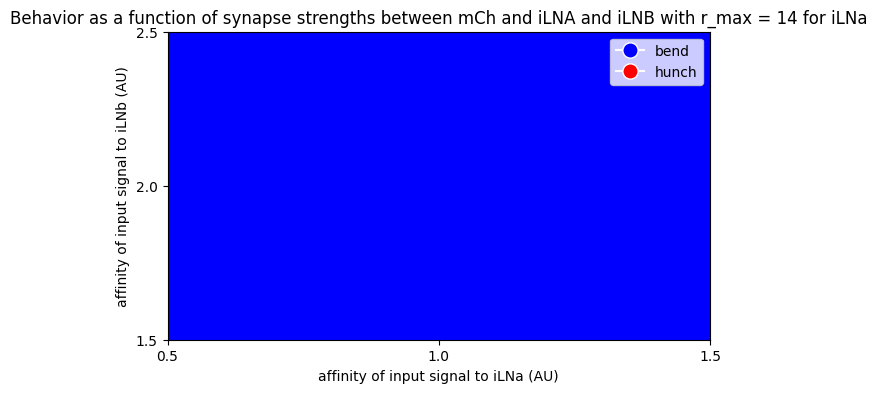

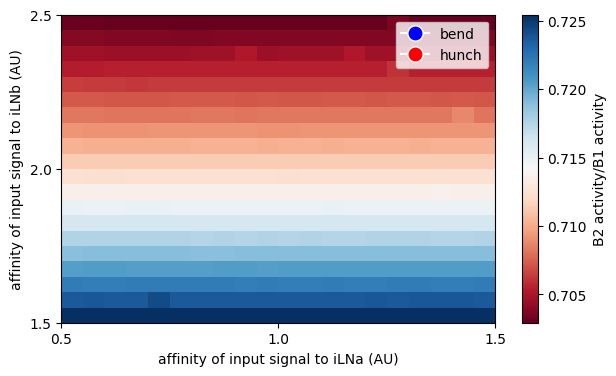

In [29]:
results.plot_behavior_diagram(classifier)
plt.title('Behavior as a function of synapse strengths between mCh and iLNA and iLNB with r_max = 14 for iLNa')
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('affinity of input signal to iLNb (AU)')
plt.show()

results.plot_ratio_diagram()
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('affinity of input signal to iLNb (AU)')
plt.show()

The basic prediction is verified as hunches completely disappear in favour of bends.

The next logical question would be how the behavior depend on $r_{max}$, varying this coefficient from 20 to 14 instead of having it fixed at 14. We vary $r_{max}$ from 20 to 14 in .5 increments and plot the activity.

In [30]:
# Computations

n_weights = 20
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(.5,1.5,n_weights))
iLNb_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNb, 'excitatory', np.linspace(1.5,2.5,n_weights))
r_max_iterator = ParameterIterator(np.linspace(17,20,12), lambda model, r_max: model.set_r_max(Neuron.iLNa, r_max))

results = Model.compute_states_on_grid([], [r_max_iterator, iLNa_iterator, iLNb_iterator])



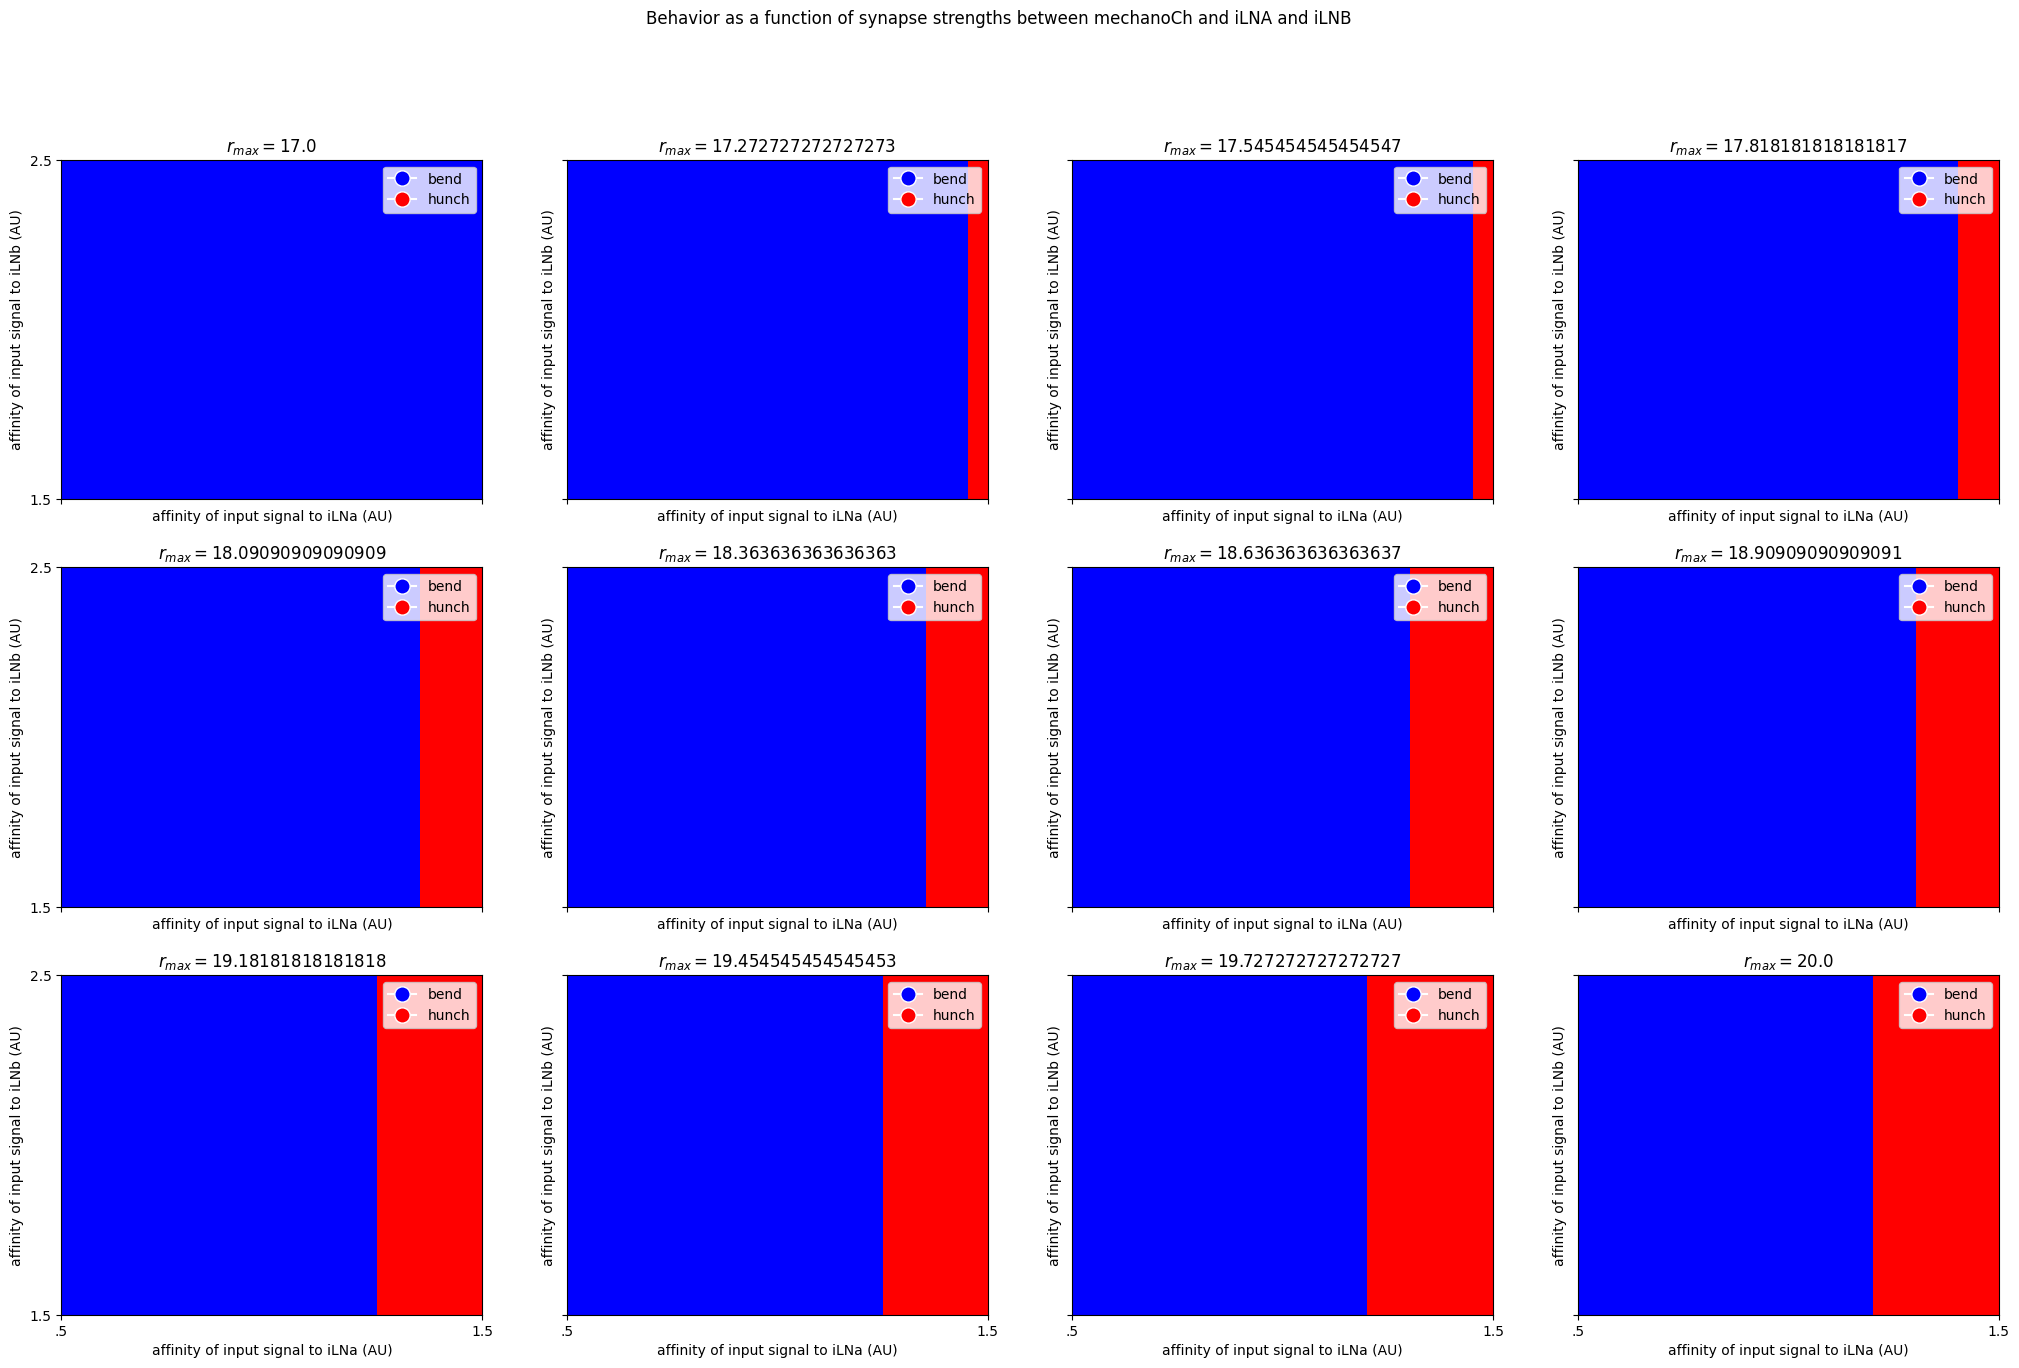

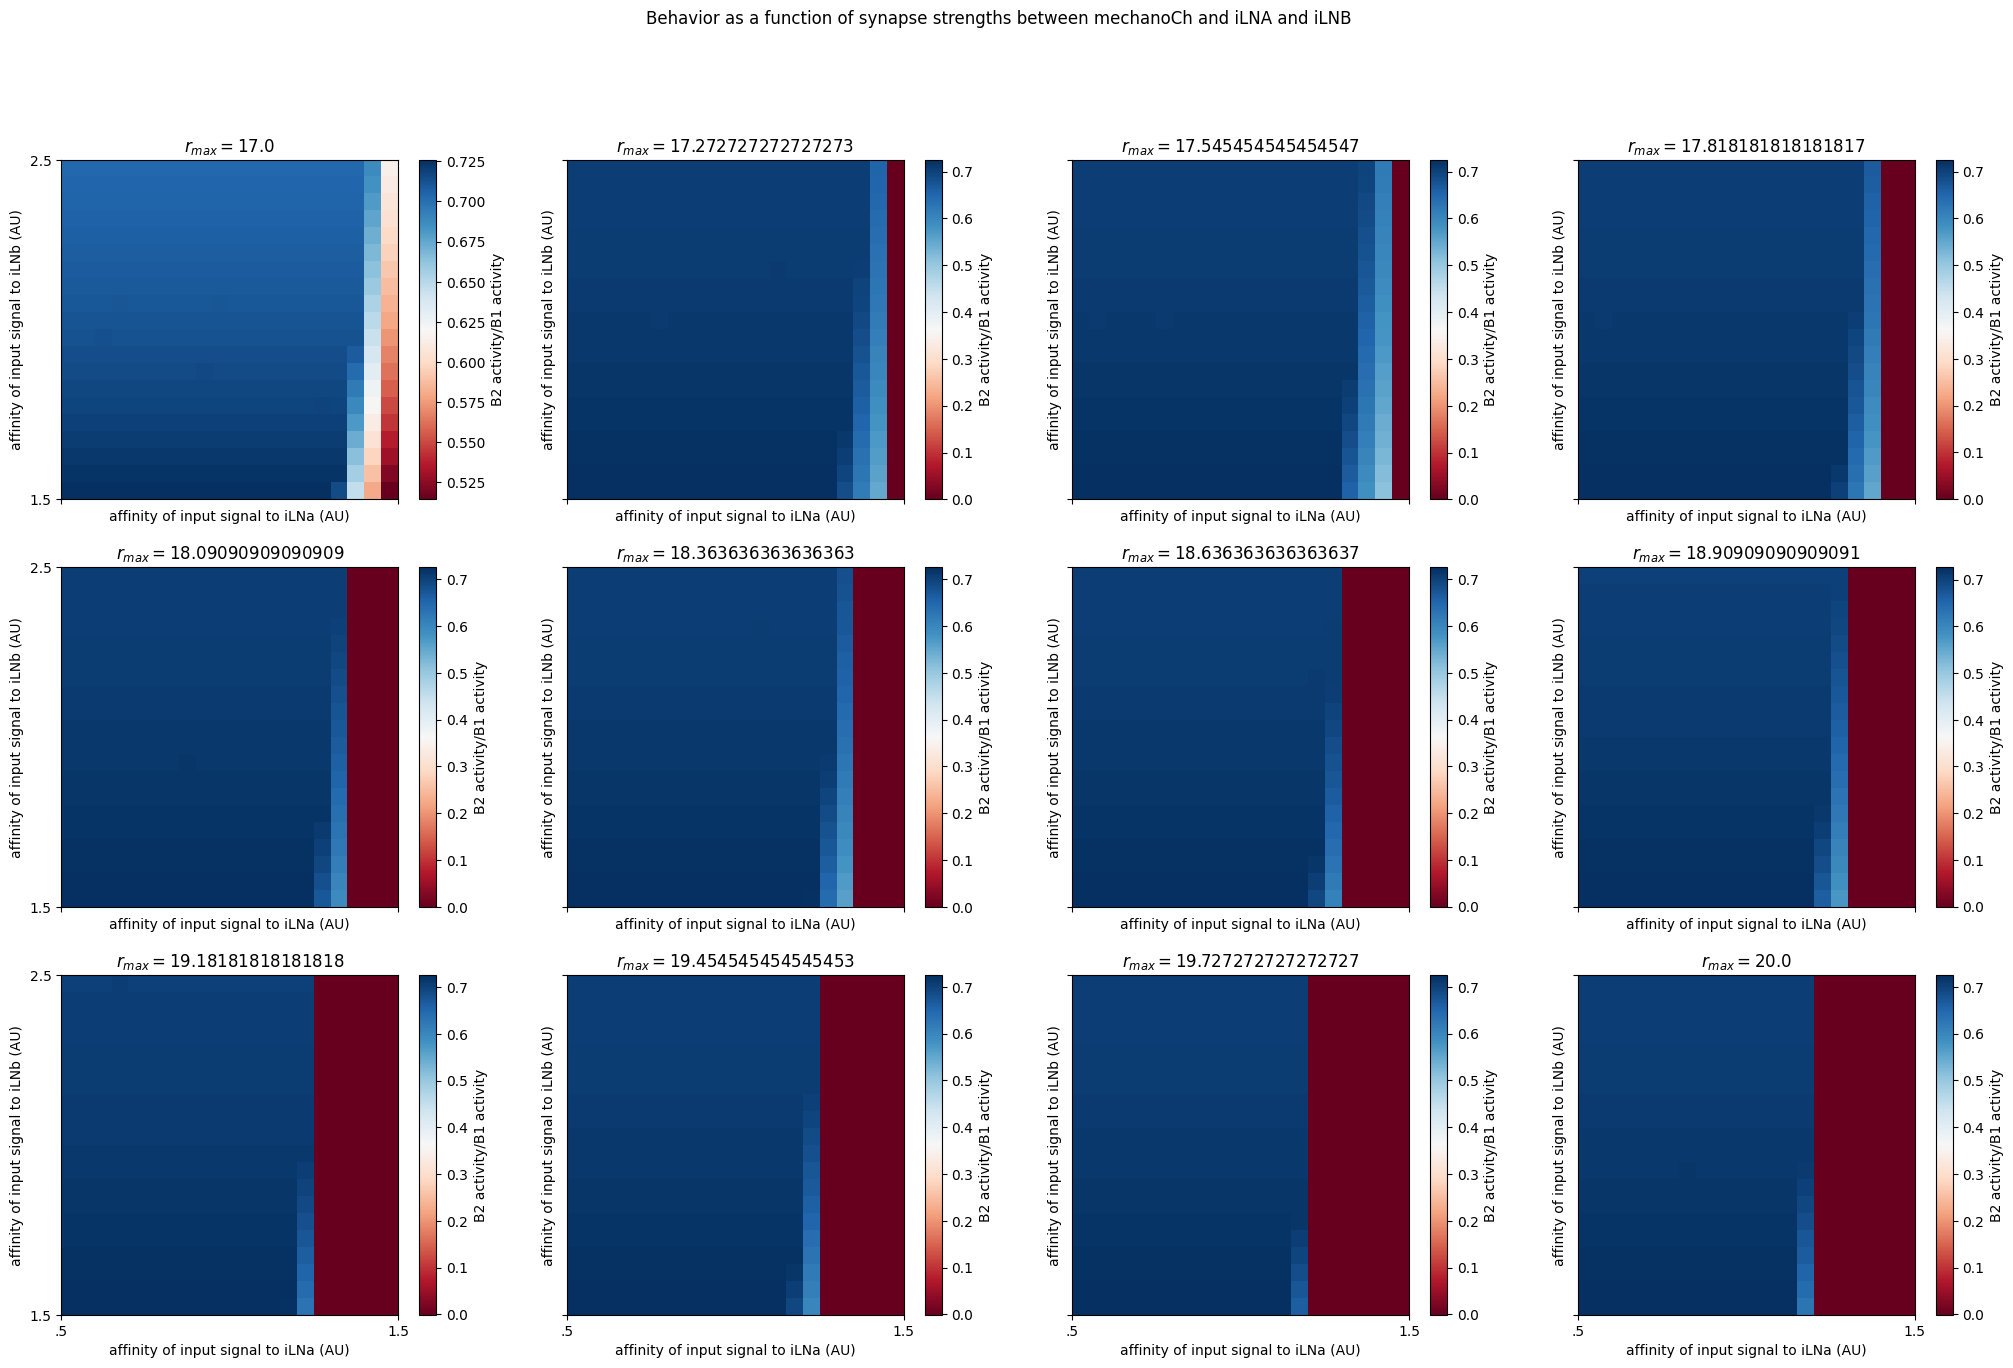

In [31]:
end_states = np.array([[[results.results[(rmax, wiLNa, wiLNb)].y[[Neuron.B1, Neuron.B2], -1] for wiLNb in iLNb_iterator] for wiLNa in iLNa_iterator] for rmax in r_max_iterator])
ratios = end_states[:,:,:,1]/end_states[:,:,:,0]
behavior = classifier.predict(end_states.reshape(-1,2)).reshape(ratios.shape)
ratios = ratios.transpose(0,2,1)
behavior = behavior.transpose(0,2,1)

_, axs = plt.subplots(3,4, sharex=True, sharey=True, figsize=(25, 15))
plt.suptitle('Behavior as a function of synapse strengths between mechanoCh and iLNA and iLNB')

# TODO : rewrite using partial behavior plot ?

for rmax, ax, behavior in zip(r_max_iterator, axs.ravel(), behavior):
    ax.imshow(behavior.reshape(n_weights, n_weights), extent=[.5,1.5,1.5,2.5], origin='lower', aspect='auto', cmap=ListedColormap(['b', 'r']))
    ax.legend(handles=[Line2D([0],[0],marker='o',color='w',markerfacecolor='b', markersize=11),
                        Line2D([0],[0],marker='o',color='w',markerfacecolor='r', markersize=11)],
            labels=['bend', 'hunch'], loc='upper right')
    ax.set_title('$r_{max} = '+ f'{rmax}$')
    ax.set_xticks([.5, 1.5], labels=['.5', '1.5'])
    ax.set_yticks([1.5,2.5], labels=['1.5','2.5'])
    ax.set_xlabel('affinity of input signal to iLNa (AU)')
    ax.set_ylabel('affinity of input signal to iLNb (AU)')
plt.show()


_, axs = plt.subplots(3,4, sharex=True, sharey=True, figsize=(25, 15))
plt.suptitle('Behavior as a function of synapse strengths between mechanoCh and iLNA and iLNB')

for rmax, ax, ratios in zip(r_max_iterator, axs.ravel(), ratios):
    im = ax.imshow(ratios.reshape(n_weights, n_weights), extent=[.5,1.5,1.5,2.5], origin='lower', aspect='auto', cmap='RdBu')
    plt.colorbar(im, ax=ax).set_label('B2 activity/B1 activity')
    ax.set_title('$r_{max} = '+ f'{rmax}$')
    ax.set_xticks([.5, 1.5], labels=['.5', '1.5'])
    ax.set_yticks([1.5,2.5], labels=['1.5','2.5'])
    ax.set_xlabel('affinity of input signal to iLNa (AU)')
    ax.set_ylabel('affinity of input signal to iLNb (AU)')
plt.show()

Clearly, decreasing $r_{max}$ for LNa indeed increases the region of bends. The region of bends once again depends very little on the iLNb synapse. So we would be well advised to construct the same kinds of diagrams as before, fixing $w(mCh \rightarrow iLNb) = 2$, and plotting behavior output with $w(mCh \rightarrow iLNa)$ on the x axis and $r_{max}^{iLNa}$ on the y axis.

In [32]:
# Computations

n_weights = 100
iLNb_initializer = SimpleInitializer(iLNb=2)
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(.5,1.5,n_weights))
r_max_iterator = ParameterIterator(np.linspace(17,20,n_weights), lambda model, r_max: model.set_r_max(Neuron.iLNa, r_max))

results = Model.compute_states_on_grid([iLNb_initializer], [iLNa_iterator, r_max_iterator])

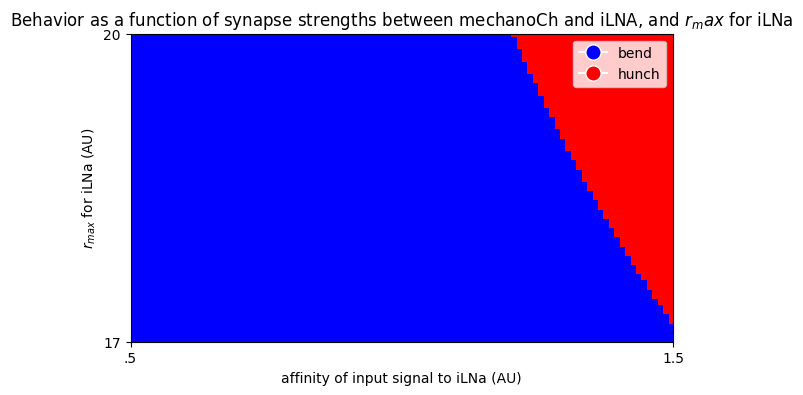

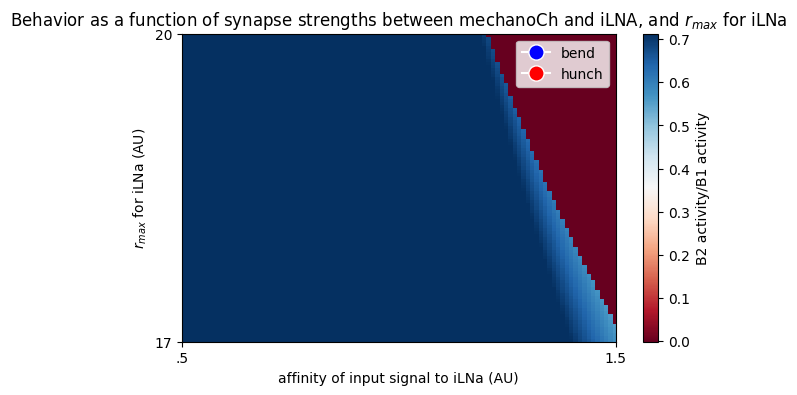

In [33]:
results.plot_behavior_diagram(classifier)
plt.title('Behavior as a function of synapse strengths between mechanoCh and iLNA, and $r_max$ for iLNa')
plt.legend(handles=[Line2D([0],[0],marker='o',color='w',markerfacecolor='b', markersize=11),
                    Line2D([0],[0],marker='o',color='w',markerfacecolor='r', markersize=11)],
           labels=['bend', 'hunch'], loc='upper right')
plt.xticks([.5, 1.5], labels=['.5', '1.5'])
plt.yticks([17,20], labels=['17','20'])
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('$r_{max}$ for iLNa (AU)')
plt.savefig('outputs/behavior_phase_diagram_with_decreased_rmax_to_iLNa.pdf')
plt.show()


results.plot_ratio_diagram()
plt.title('Behavior as a function of synapse strengths between mechanoCh and iLNA, and $r_{max}$ for iLNa')
plt.legend(handles=[Line2D([0],[0],marker='o',color='w',markerfacecolor='b', markersize=11),
                    Line2D([0],[0],marker='o',color='w',markerfacecolor='r', markersize=11)],
           labels=['bend', 'hunch'], loc='upper right')
plt.xticks([.5, 1.5], labels=['.5', '1.5'])
plt.yticks([17,20], labels=['17','20'])
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('$r_{max}$ for iLNa (AU)')
plt.savefig('outputs/ratios_phase_diagram_with_decreased_rmax_to_iLNa.pdf')
plt.show()


Once again, we show that as $r_{max}^{iLNa}$ is decreased, the bend region increases. This is merely another formulation of what was seen earlier.

It can be of interest, in this representation, to visualize the maximum activity of iLNA for each set of parameters.

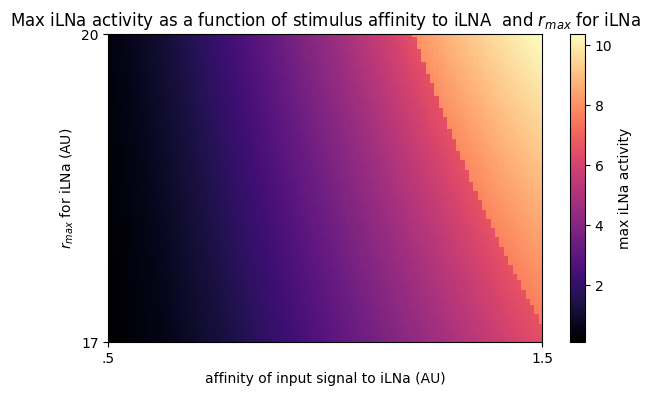

In [34]:
max_iLNa = np.array([results.results[t].y[Neuron.iLNa].max() for t in itertools.product(*results.iterators)]).reshape(results.shape).transpose()

plt.figure(figsize=(7,4))
plt.title('Max iLNa activity as a function of stimulus affinity to iLNA  and $r_{max}$ for iLNa')

plt.imshow(max_iLNa.reshape(n_weights, n_weights), extent=[.5,1.5,17,20], origin='lower', aspect='auto', cmap='magma')
plt.colorbar().set_label('max iLNa activity')
plt.xticks([.5, 1.5], labels=['.5', '1.5'])
plt.yticks([17,20], labels=['17','20'])
plt.xlabel('affinity of input signal to iLNa (AU)')
plt.ylabel('$r_{max}$ for iLNa (AU)')
plt.savefig('outputs/iLNa_peak_diagram_with_decreased_rmax_to_iLNa.pdf')
plt.show()

As input current increases, iLna activity decreases, with a very sharp transition towards a lower level at the boundary between behaviors. The maximum activity is preserved but is shofted to the left.

 Let's look at silencing experiments.

## Silencing experiments 

1. silencing fbLNHb in presence of sucrose results in increased activity of LNa 
2. silencing LNA in fed state results in increased activity of Hb
3. silencing LNA in sucrose state results in no change of Hb activity

We model the fed state as having $r_{max}^{iLNa}$ equal to 20 and the sucrose state as having $r_{max}^{iLNa}$ equal to 18. We compare the trajectories with and without silencing across the range of iLNa inputs.

### Reproducing first silencing experiment

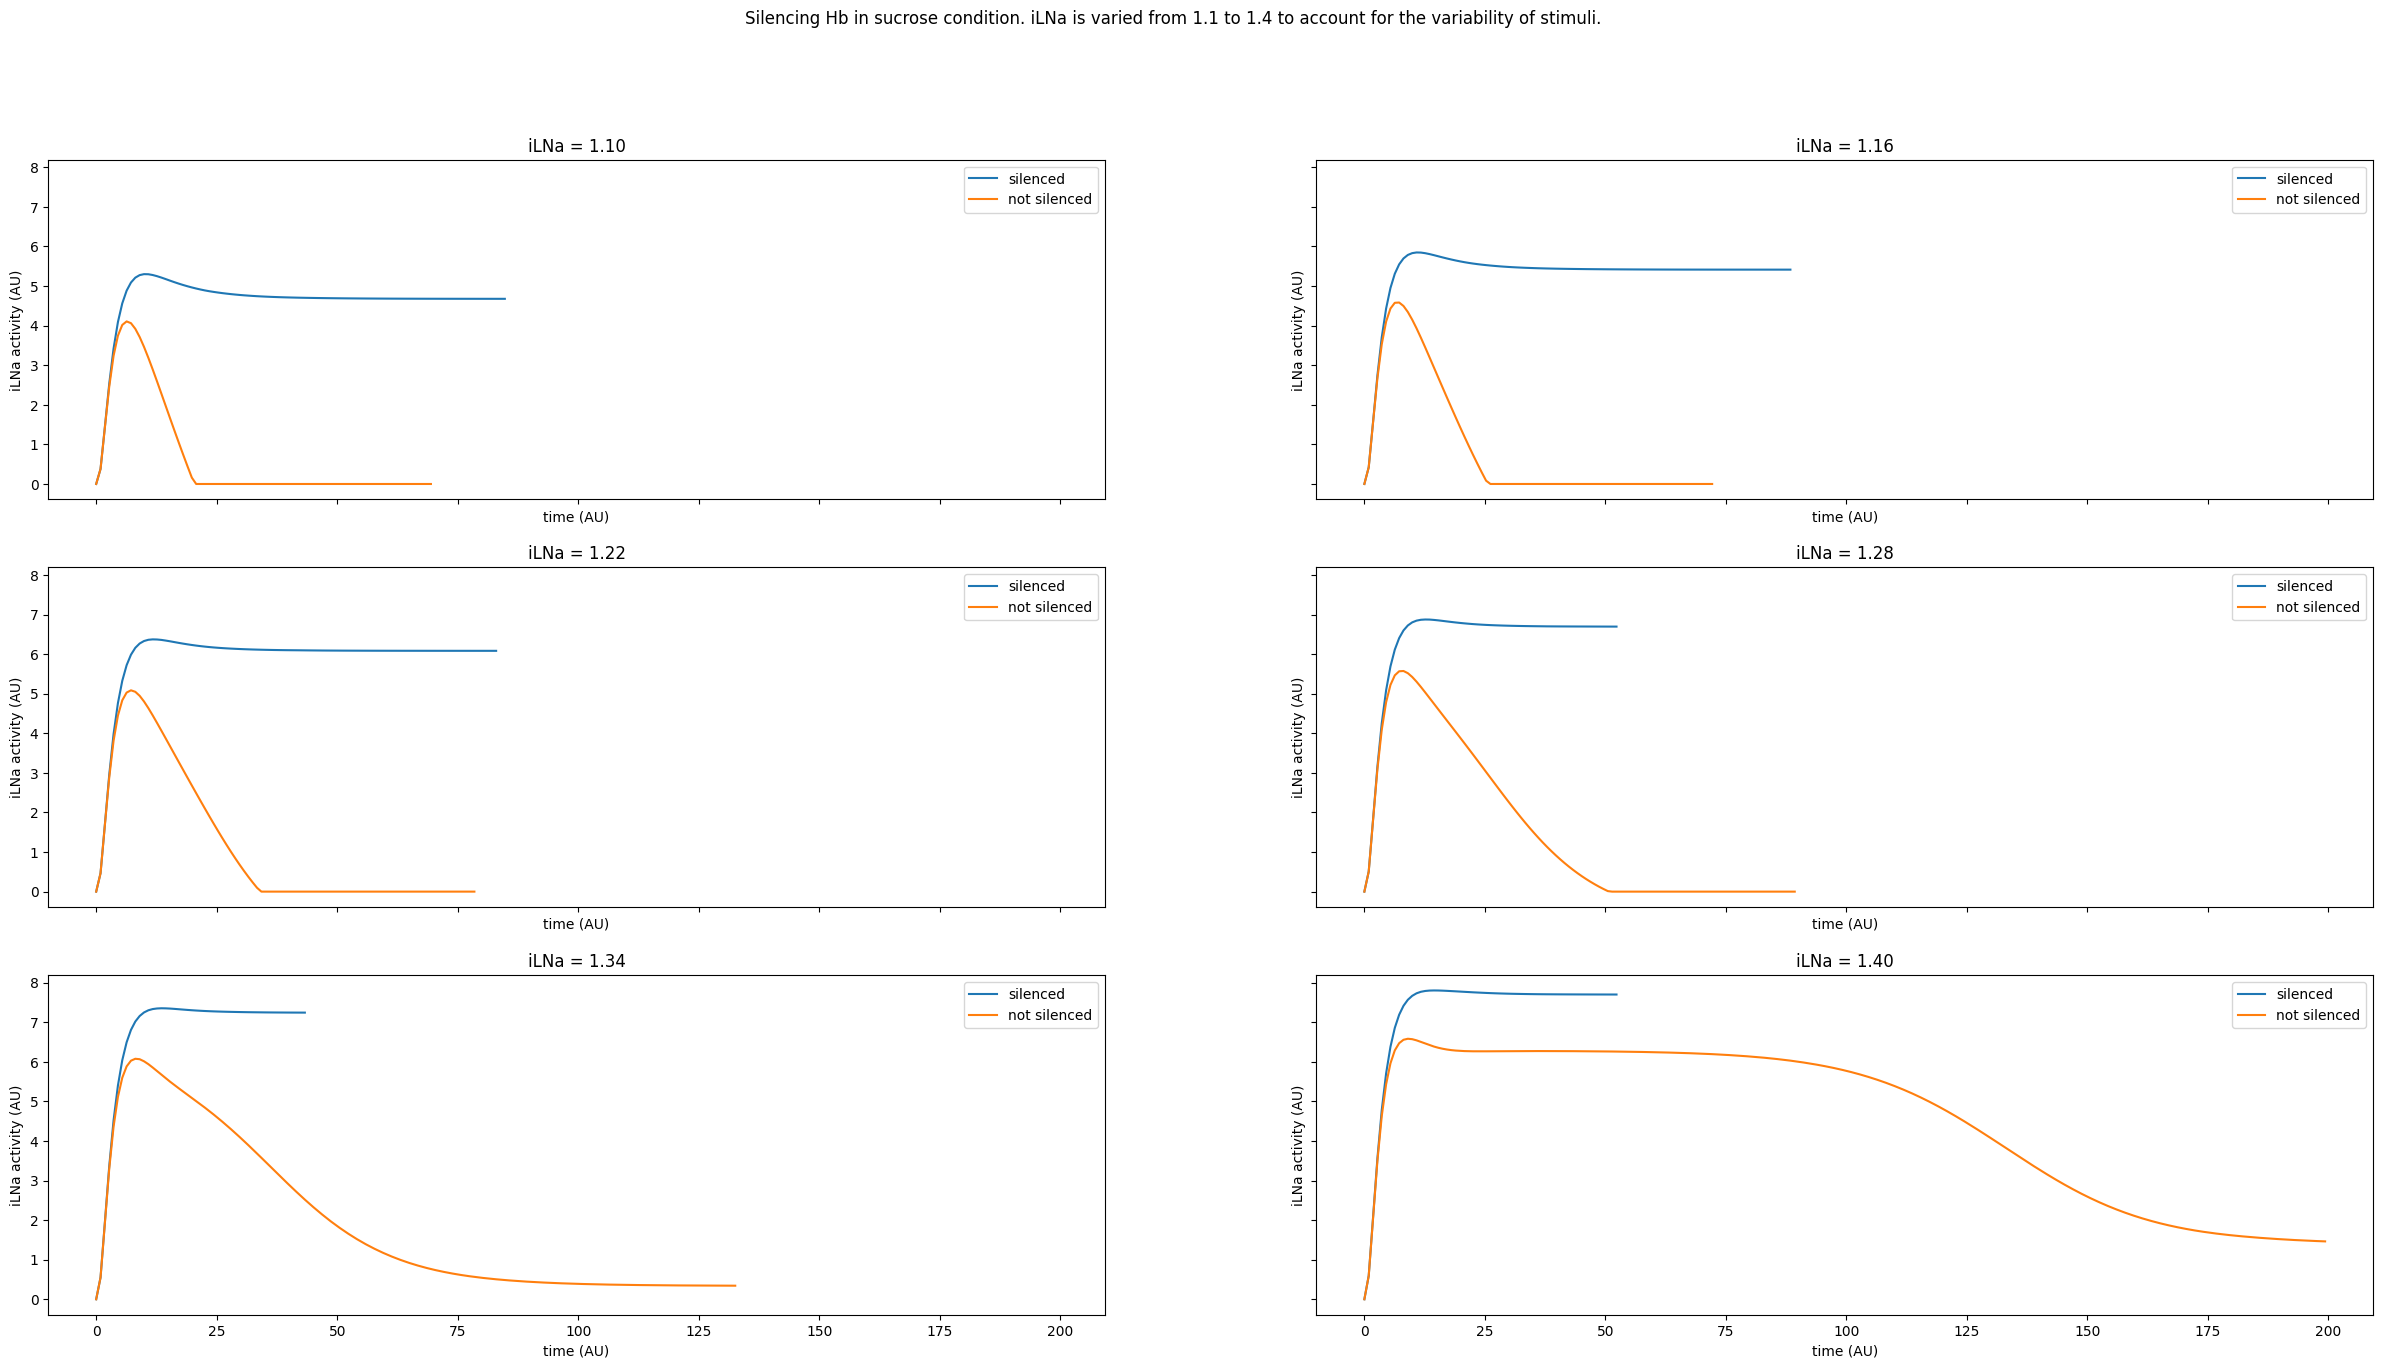

In [35]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)
rmaxiLNa_initializer = ModelInitializer(lambda model: model.set_r_max(Neuron.iLNa, 18))

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencingHb_iterator = SilencingIterator(Neuron.fbLNHb)

results = Model.compute_states_on_grid([iLNb_initializer, rmaxiLNa_initializer],
                                [iLNa_iterator, silencingHb_iterator])

fig = results.plot_silencing_curves(Neuron.iLNa, xlabel='time (AU)', ylabel='iLNa activity (AU)', prefix='iLNa = ', max_time=200)
fig.suptitle('Silencing Hb in sucrose condition. iLNa is varied from 1.1 to 1.4 to account for the variability of stimuli.')
plt.savefig('outputs/model_decreased_rmax_to_iLNa/handleB_silencing_in_sucrose_state_with_decreased_rmax_to_iLNa.pdf')
plt.show()

The result is reproduced : silencing Hb in the sucrose state increases the activity of Hb.

### Reproducing the second silencing experiment

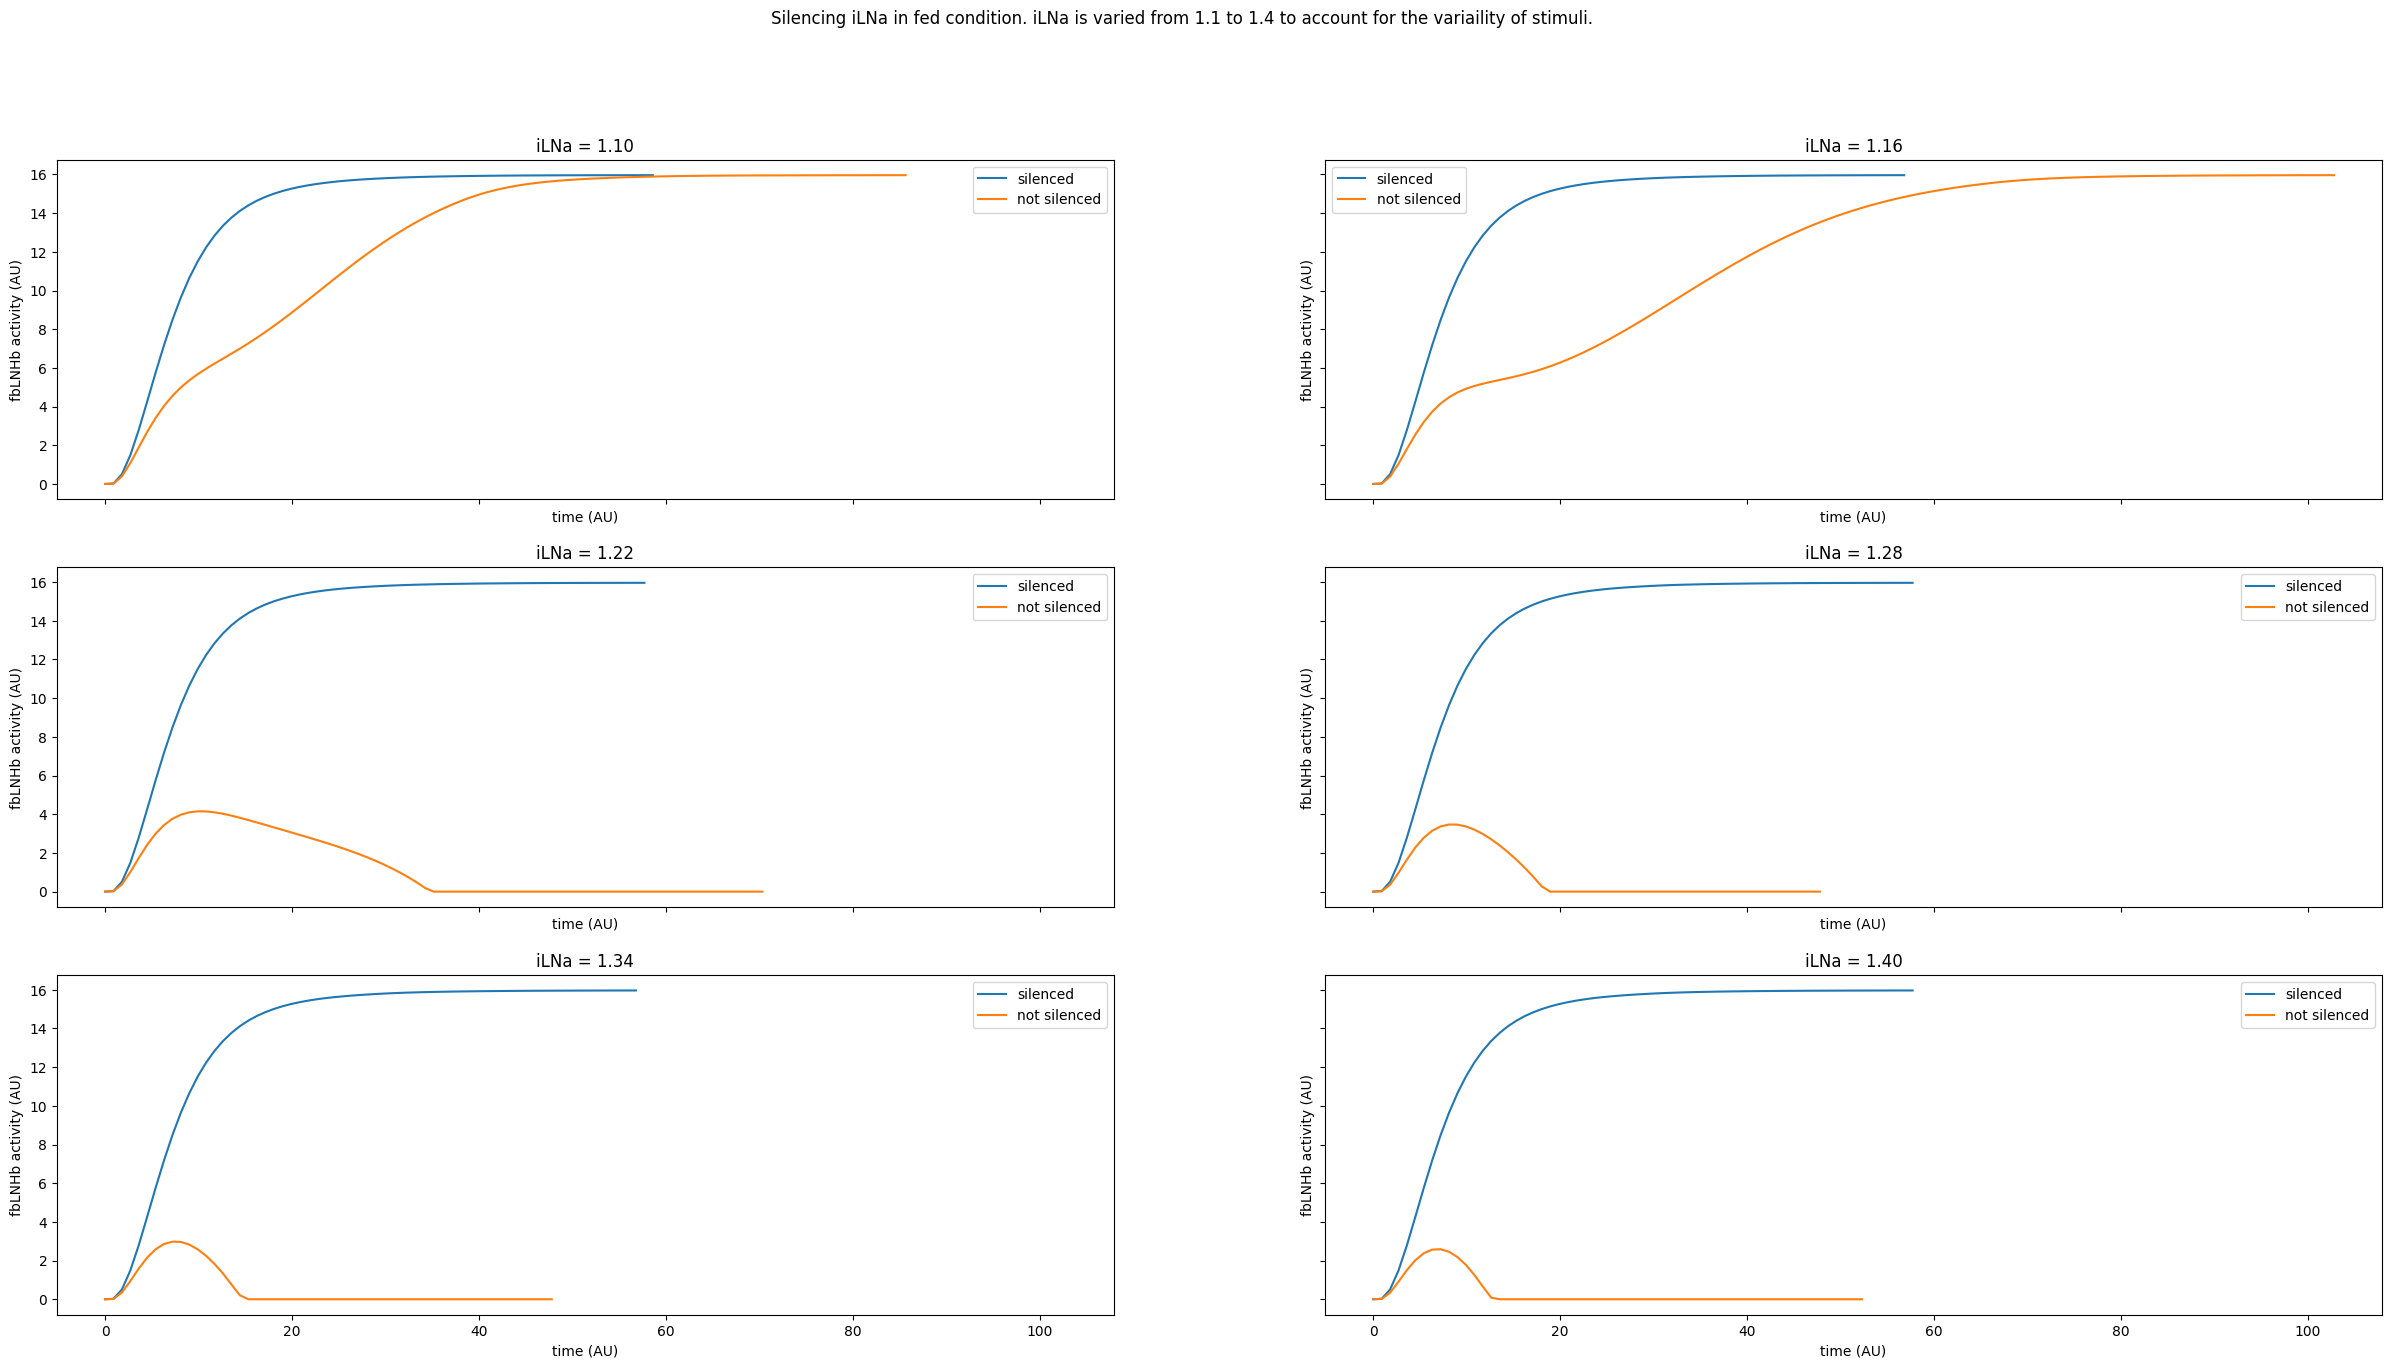

In [36]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencingiLNa_iterator = SilencingIterator(Neuron.iLNa)

results = Model.compute_states_on_grid([iLNb_initializer],
                                [iLNa_iterator, silencingiLNa_iterator])

fig = results.plot_silencing_curves(Neuron.fbLNHb, xlabel='time (AU)', ylabel='fbLNHb activity (AU)', prefix='iLNa = ', max_time=200)
fig.suptitle('Silencing iLNa in fed condition. iLNa is varied from 1.1 to 1.4 to account for the variaility of stimuli.')
plt.savefig('outputs/model_decreased_rmax_to_iLNa/iLNA_silencing_in_fed_state_with_decreased_rmax_to_iLNa.pdf')
plt.show()

The result is reproduced : silencing iLNa in the fed state increase Hb activity.

### Reproducing third silencing experiment

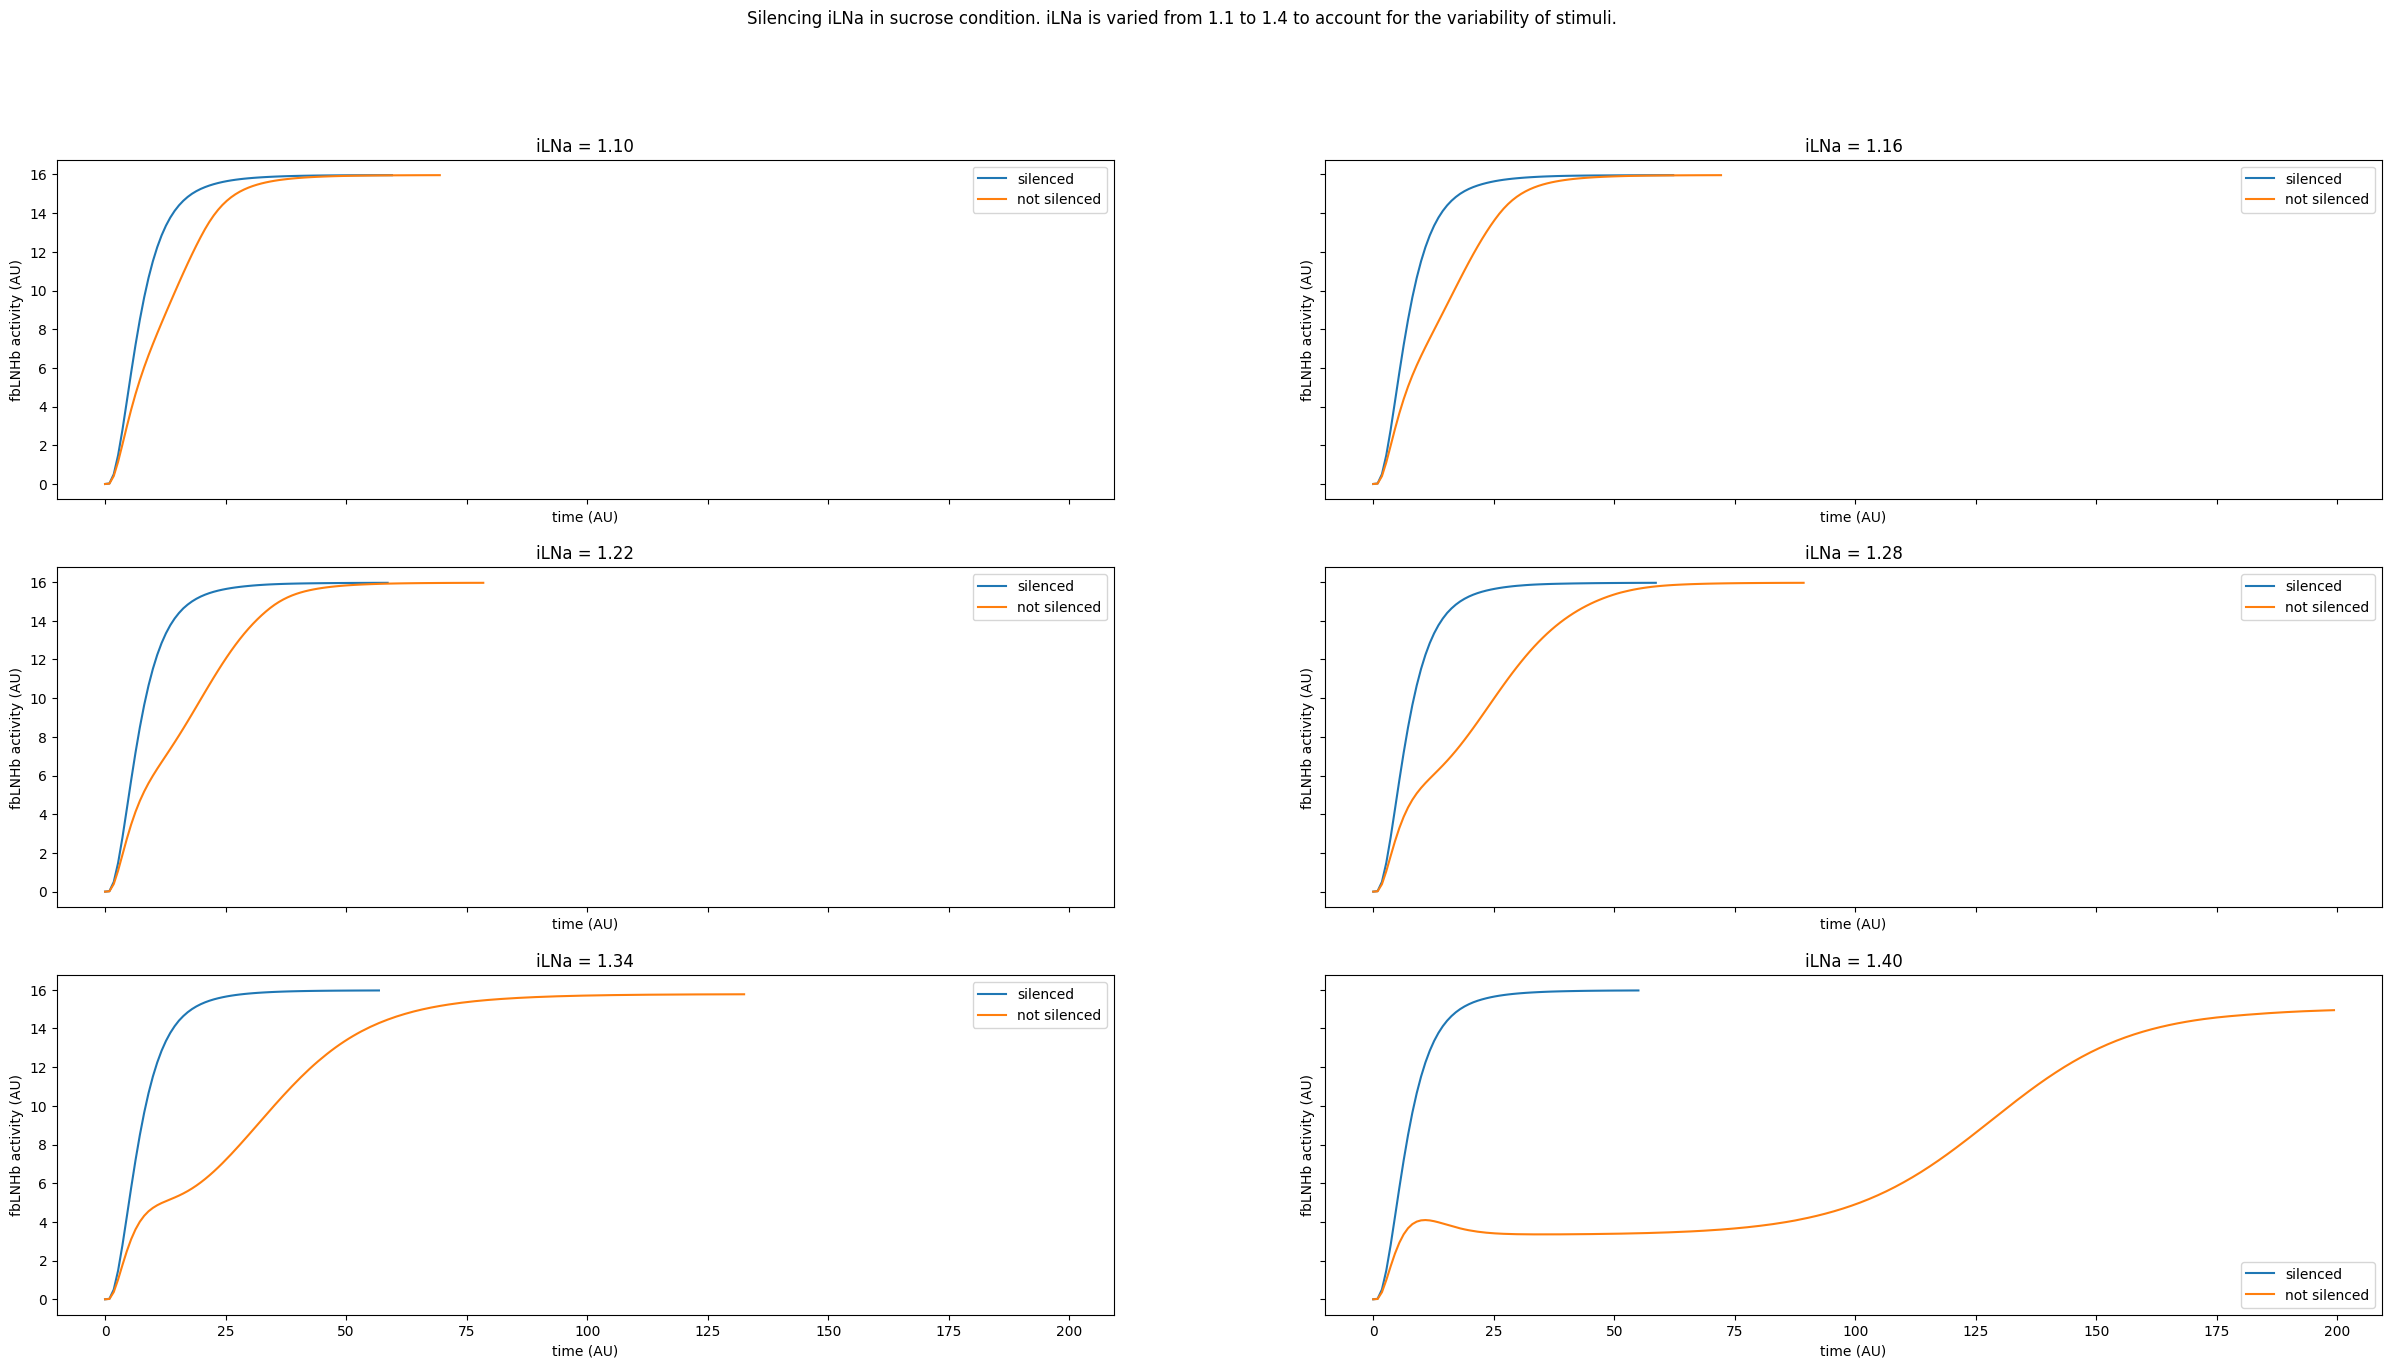

In [37]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)
rmaxiLNa_initializer = ModelInitializer(lambda model: model.set_r_max(Neuron.iLNa, 18))

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencingiLNa_iterator = SilencingIterator(Neuron.iLNa)

results = Model.compute_states_on_grid([iLNb_initializer, rmaxiLNa_initializer],
                                [iLNa_iterator, silencingiLNa_iterator])

fig = results.plot_silencing_curves(Neuron.fbLNHb, xlabel='time (AU)', ylabel='fbLNHb activity (AU)', prefix='iLNa = ', max_time=200)
plt.savefig('outputs/model_decreased_rmax_to_iLNa/iLNA_silencing_in_sucrose_state_with_decreased_rmax_to_iLNa.pdf')
fig.suptitle('Silencing iLNa in sucrose condition. iLNa is varied from 1.1 to 1.4 to account for the variability of stimuli.')
plt.show()

The result is **not** reproduced by the model in the sucrose/iLNa silencing experiment : silencing iLNa has a large impact on Hb activity.

### Silencing Handle B in fed state

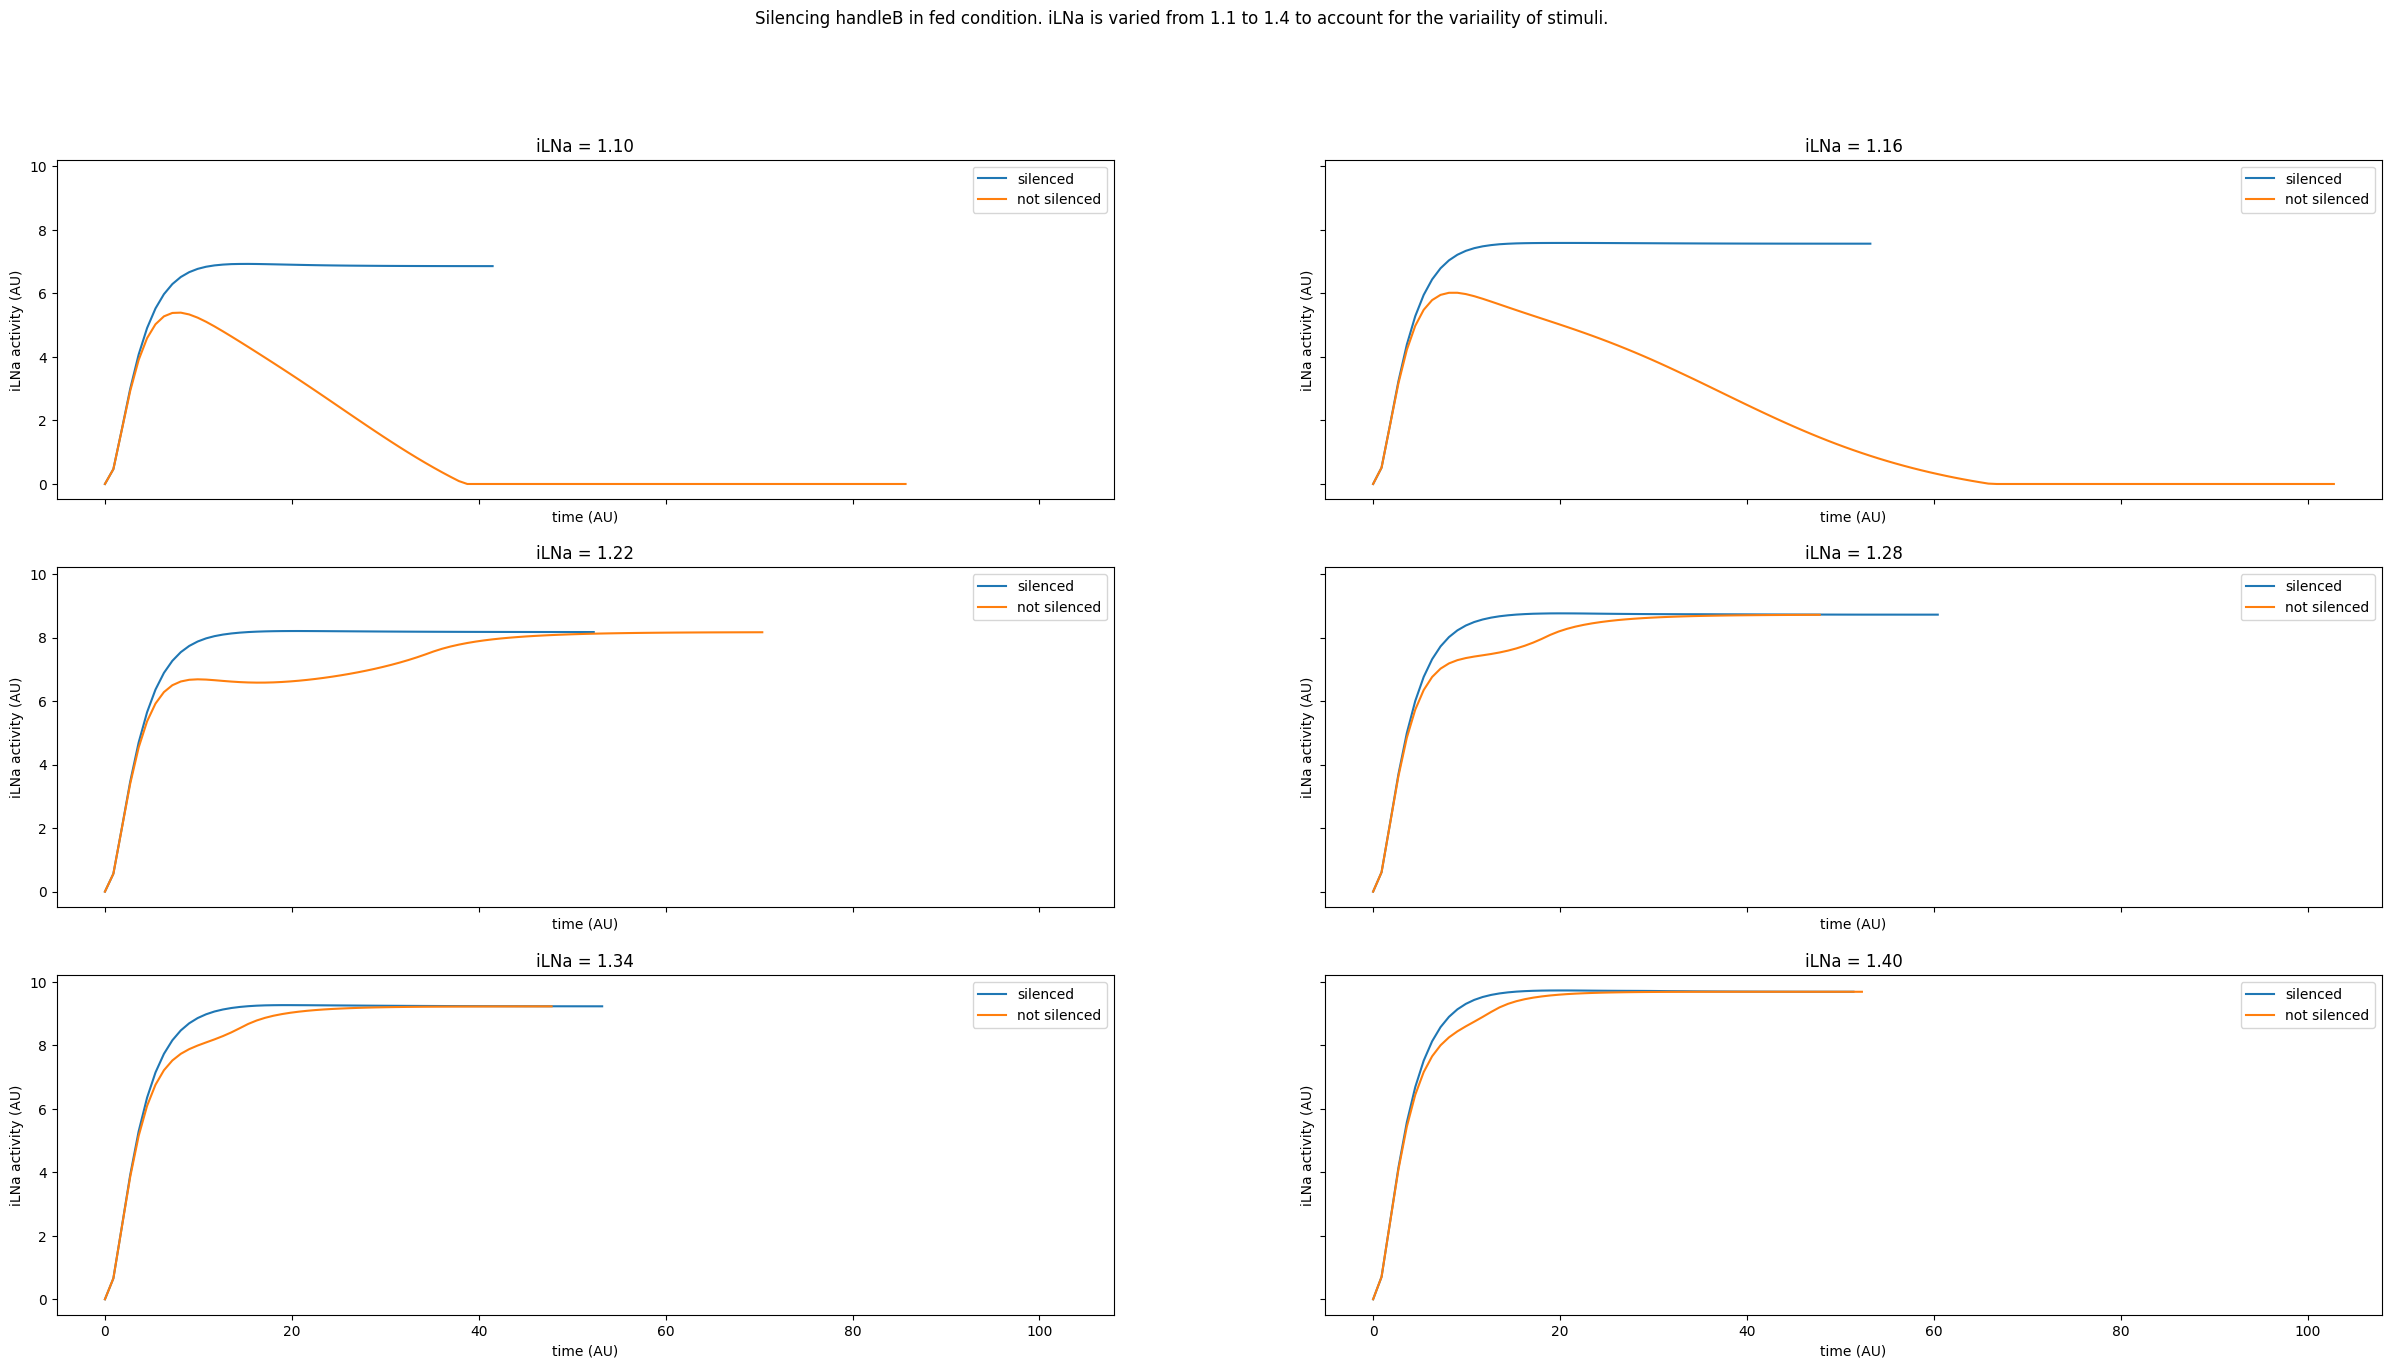

In [38]:
n_weights = 6

iLNb_initializer = SimpleInitializer(iLNb=2)

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
silencinghandleB_iterator = SilencingIterator(Neuron.fbLNHb)

results = Model.compute_states_on_grid([iLNb_initializer],
                                [iLNa_iterator, silencinghandleB_iterator])

fig = results.plot_silencing_curves(Neuron.iLNa, xlabel='time (AU)', ylabel='iLNa activity (AU)', prefix='iLNa = ', max_time=200)
fig.suptitle('Silencing handleB in fed condition. iLNa is varied from 1.1 to 1.4 to account for the variaility of stimuli.')
plt.savefig('outputs/model_decreased_rmax_to_iLNa/handleB_silencing_in_fed_state_with_decreased_rmax_to_iLNa.pdf')
plt.show()

## Phase diagram modification on silencing

### Effect on behaviour output of HandleB silencing.

Let us compute full behavior diagrams for fed/sucrose states, with HandleB silenced/not silenced, with the sucrose state defined as $r_{max}$ being reduced from 20 to 18 for iLNa/Griddle2.

In [39]:
n_weights = 100

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, "excitatory", np.linspace(.5,1.5,n_weights))
iLNb_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNb, "excitatory", np.linspace(1.5,2.5,n_weights))
silencingHb_iterator = SilencingIterator(Neuron.fbLNHb)
internalStateIterator = ParameterIterator(["fed", "sucrose"], lambda m, p : m.set_r_max(Neuron.iLNa, 20 if p == "fed" else 18))

results = Model.compute_states_on_grid([], [internalStateIterator, silencingHb_iterator, iLNa_iterator, iLNb_iterator])

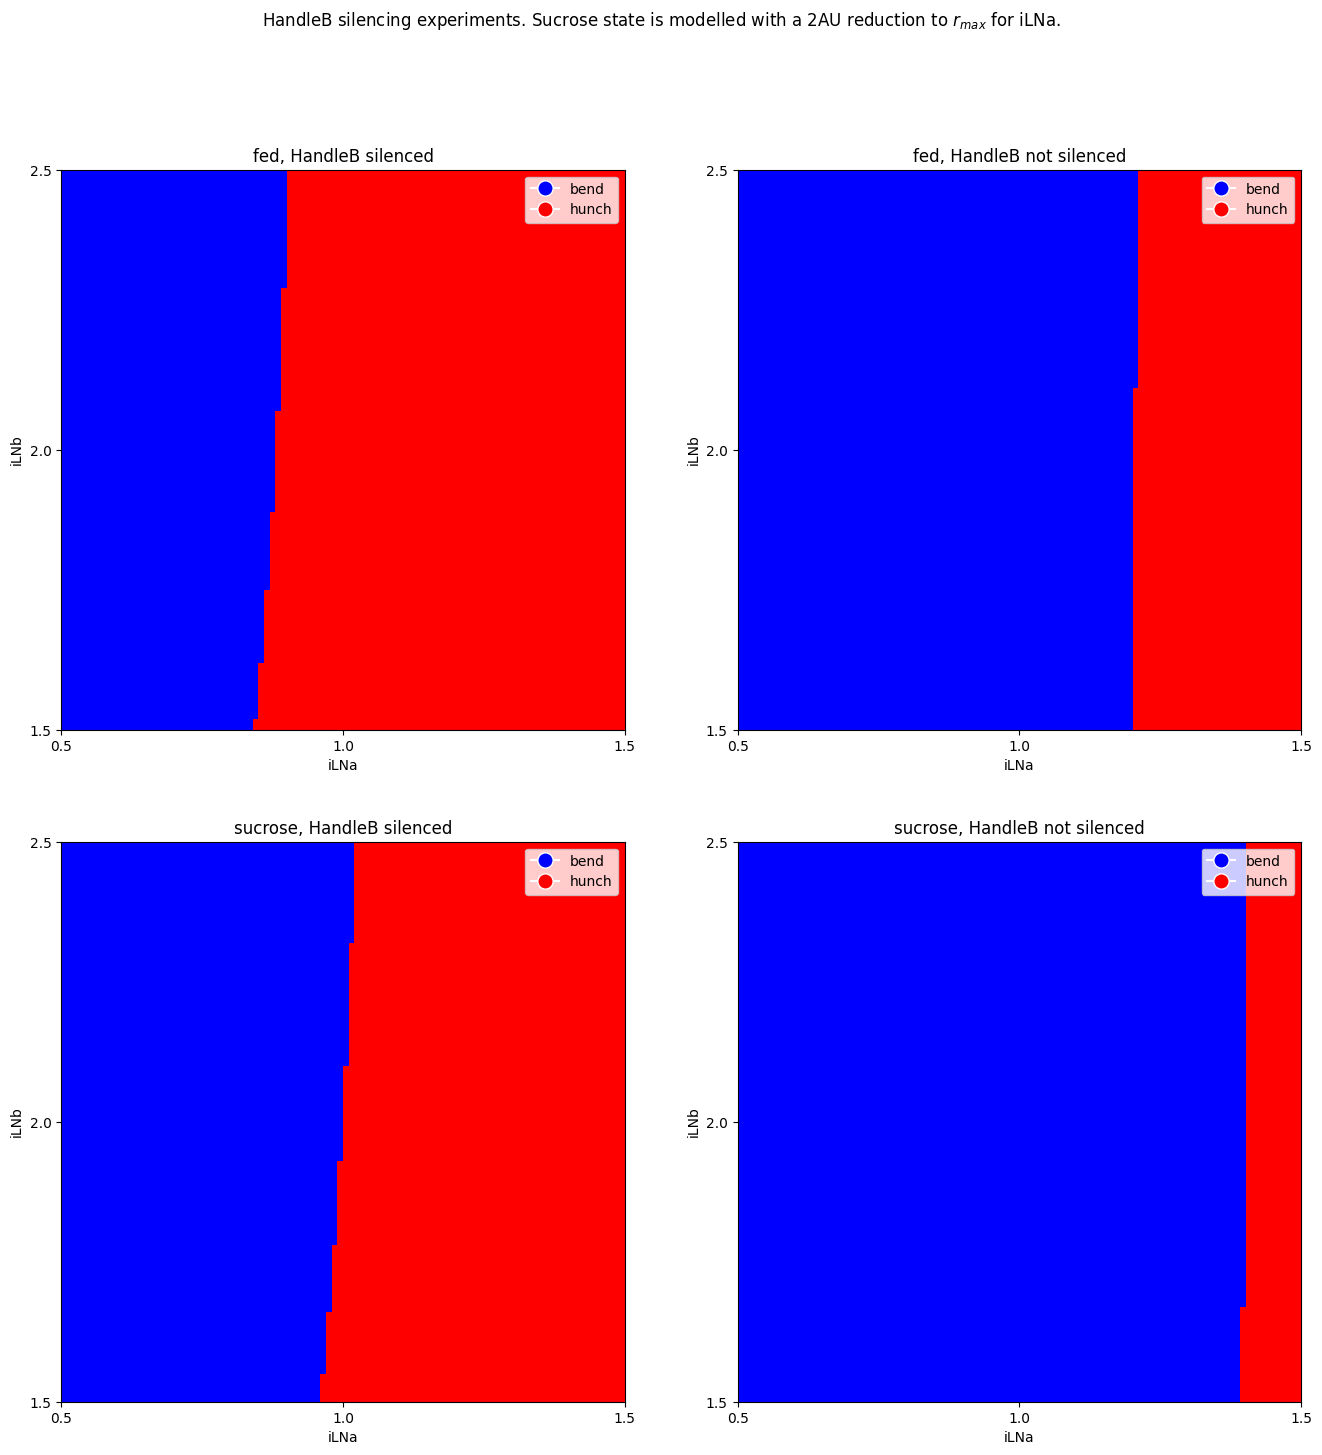

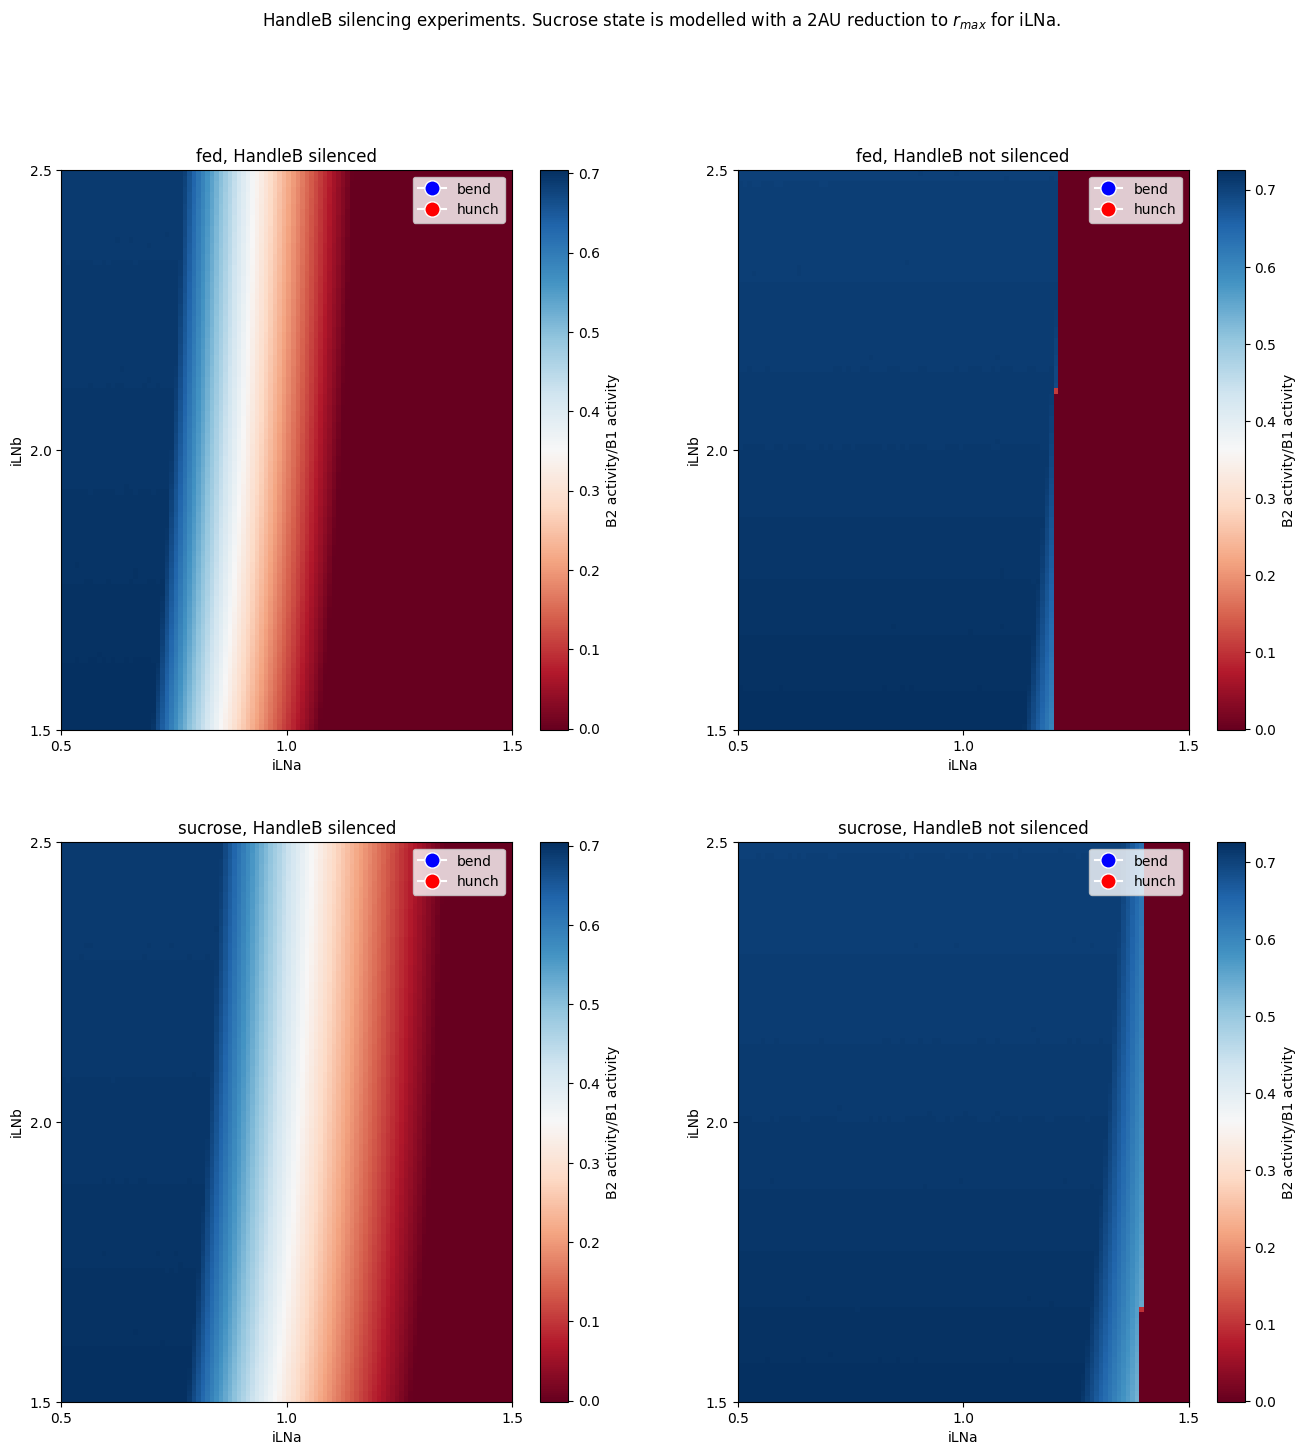

In [40]:
import itertools

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('HandleB silencing experiments. Sucrose state is modelled with a 2AU reduction to $r_{max}$ for iLNa.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_behavior_diagram(classifier, [iLNa_iterator, iLNb_iterator], (condition, silencing), ax)

    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', HandleB ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/model_decreased_rmax_to_iLNa/behavior_phase_diagram_modification_under_HandleB_silencing_with_decreased_rmax_to_iLNa.pdf')
plt.show()

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('HandleB silencing experiments. Sucrose state is modelled with a 2AU reduction to $r_{max}$ for iLNa.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_ratio_diagram([iLNa_iterator, iLNb_iterator], (condition, silencing), ax)
    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', HandleB ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/model_decreased_rmax_to_iLNa/ratios_phase_diagram_modification_under_HandleB_silencing_with_decreased_rmax_to_iLNa.pdf')
plt.show()

### Effect on behaviour output of iLNa silencing.

Let us compute full behavior diagrams for fed/sucrose states, with iLNa silenced/not silenced, with the sucrose state defined as $r_{max}$ being reduced from 20 to 18 for iLNa/Griddle2.

In [41]:
n_weights = 100

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, "excitatory", np.linspace(.5,1.5,n_weights))
iLNb_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNb, "excitatory", np.linspace(1.5,2.5,n_weights))
silencingiLNa_iterator = SilencingIterator(Neuron.iLNa)
internalStateIterator = ParameterIterator(["fed", "sucrose"], lambda m, p : m.set_r_max(Neuron.iLNa, 20 if p == "fed" else 18))

results = Model.compute_states_on_grid([], [internalStateIterator, silencingiLNa_iterator, iLNa_iterator, iLNb_iterator])

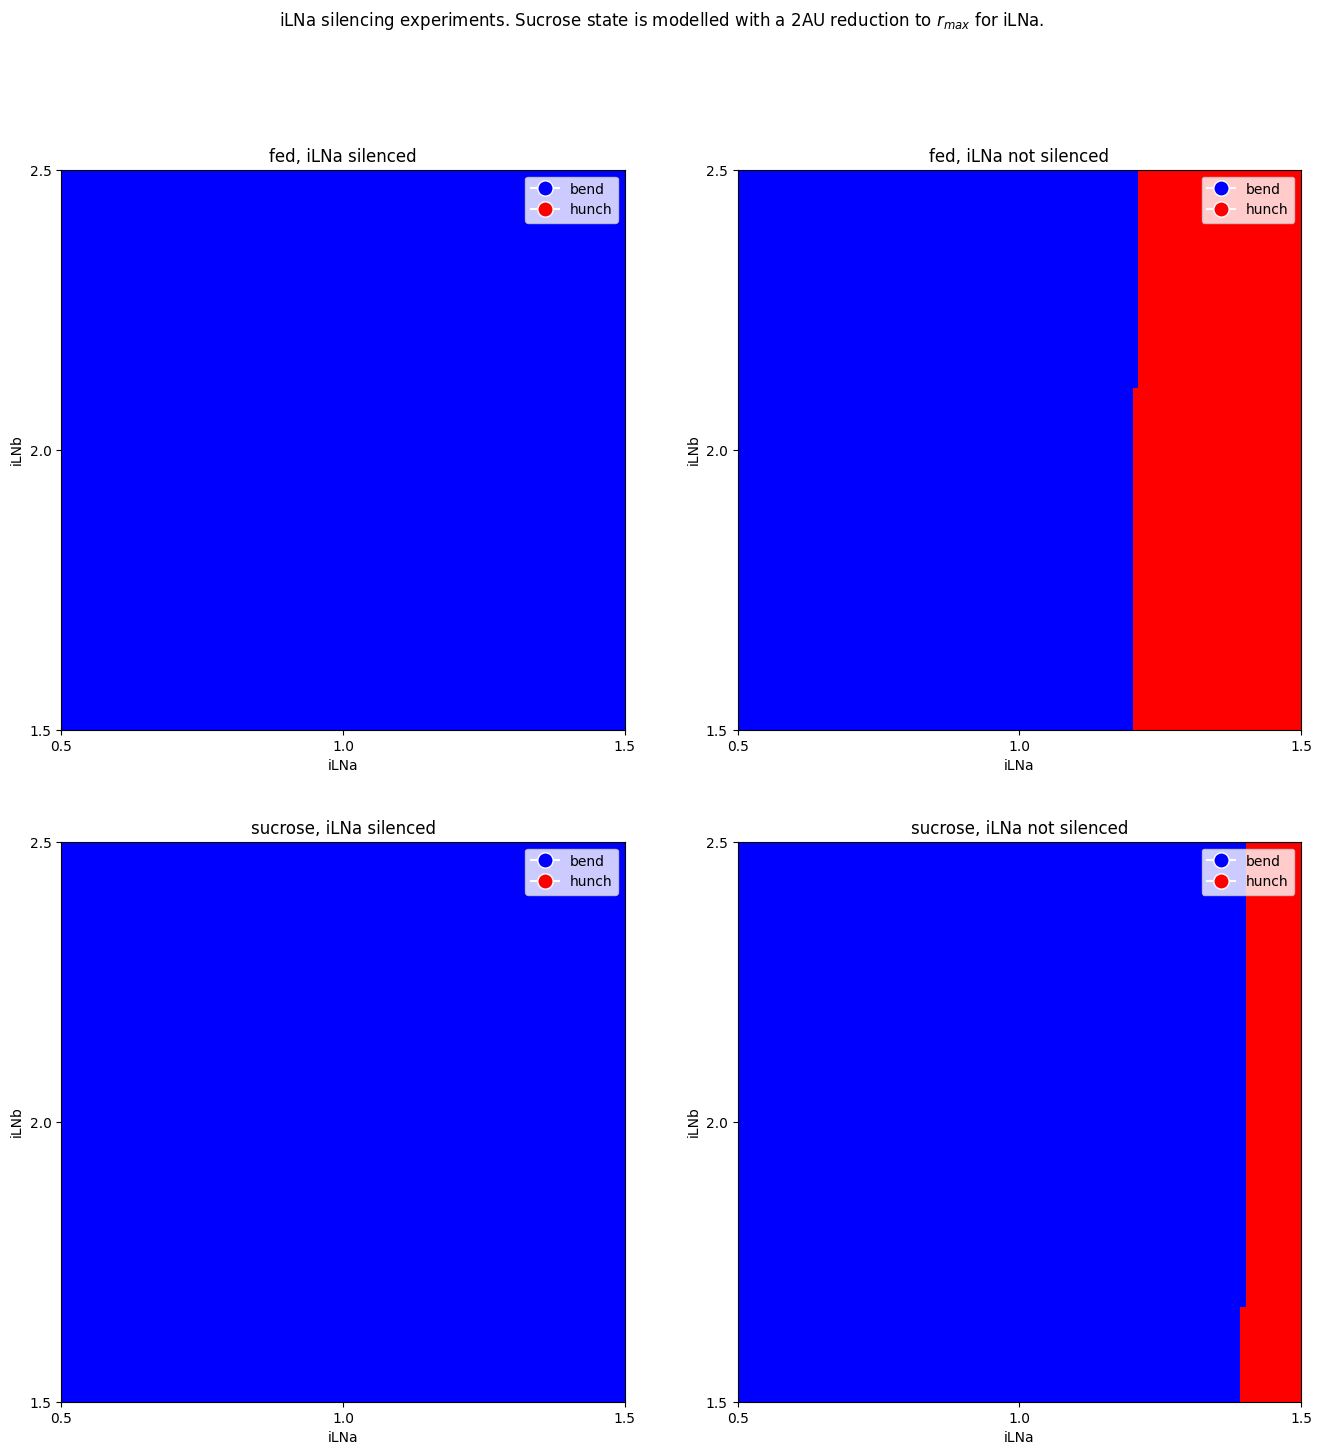

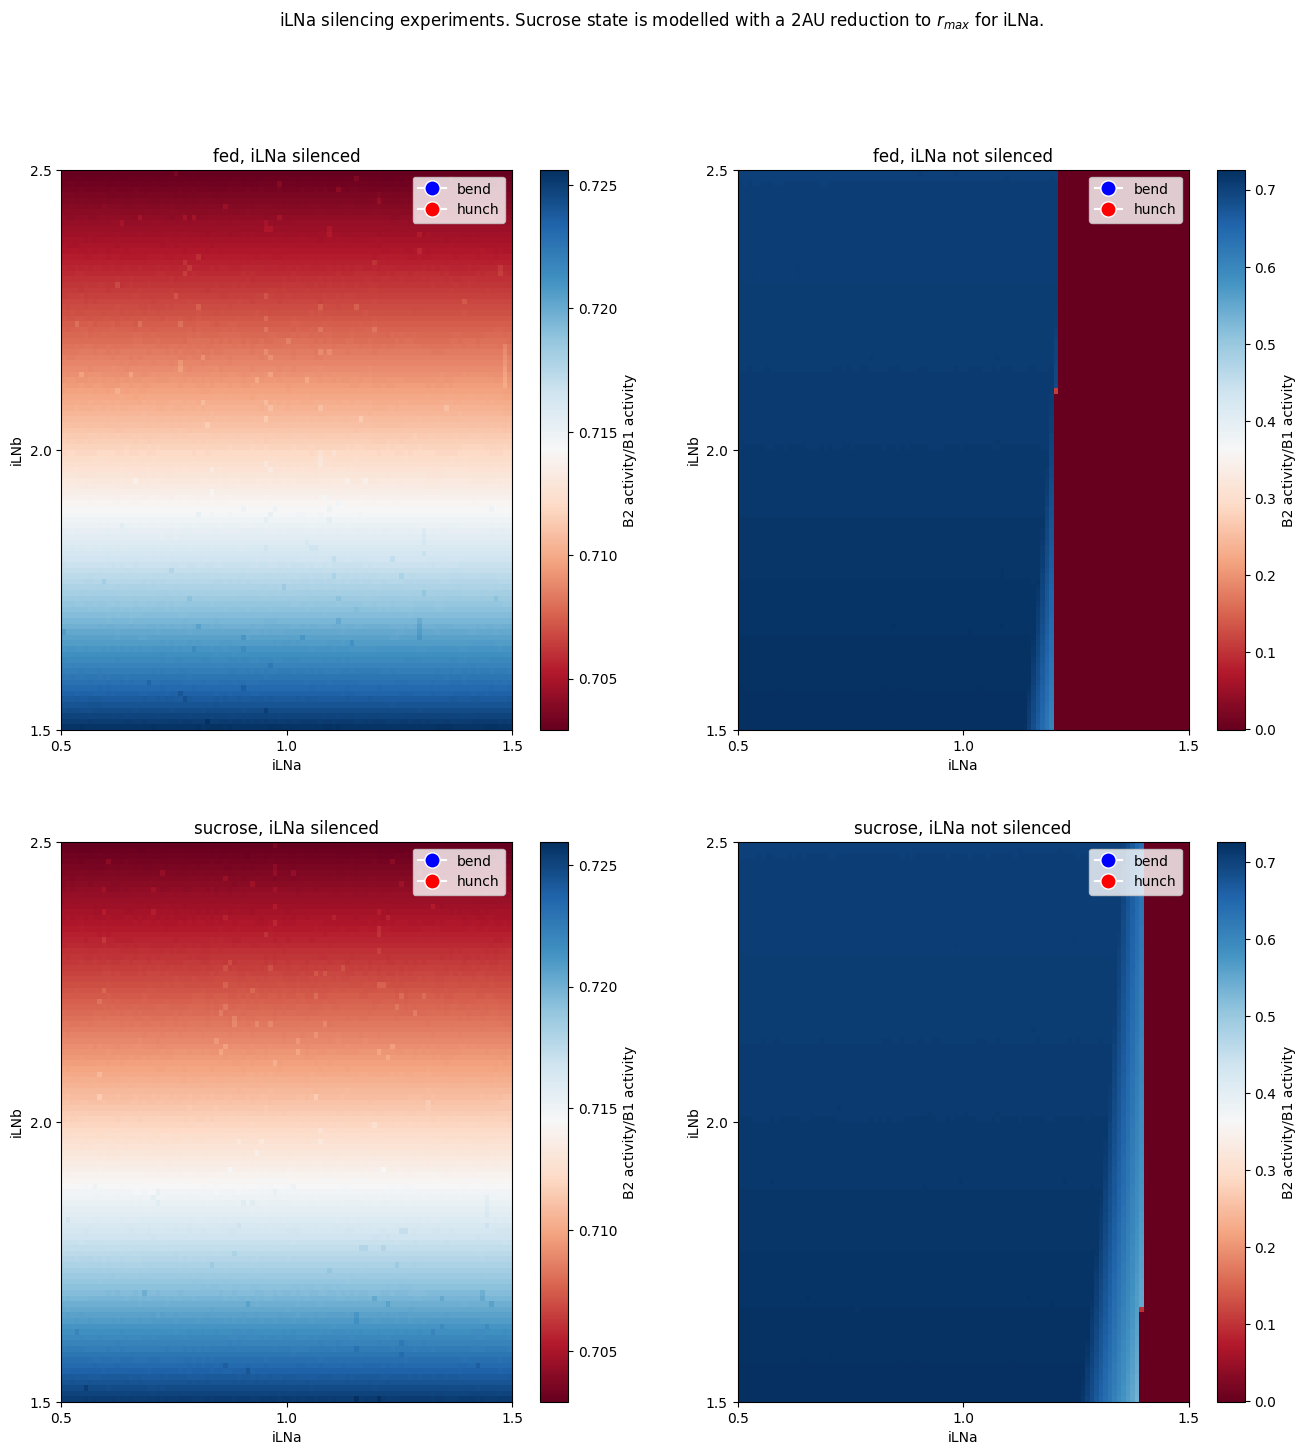

In [42]:
import itertools

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('iLNa silencing experiments. Sucrose state is modelled with a 2AU reduction to $r_{max}$ for iLNa.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_behavior_diagram(classifier, [iLNa_iterator, iLNb_iterator], (condition, silencing), ax)

    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', iLNa ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/model_decreased_rmax_to_iLNa/behavior_phase_diagram_modification_under_iLNa_silencing_with_decreased_rmax_to_iLNa.pdf')
plt.show()

_, axs = plt.subplots(2, 2, figsize=(16,16))
plt.suptitle('iLNa silencing experiments. Sucrose state is modelled with a 2AU reduction to $r_{max}$ for iLNa.')
for ax, (condition, silencing) in zip(axs.ravel(), itertools.product(('fed', 'sucrose'), (True, False))):
    results.plot_partial_ratio_diagram([iLNa_iterator, iLNb_iterator], (condition, silencing), ax)
    ax.set_xlabel('iLNa')
    ax.set_ylabel('iLNb')

    ax.set_title(condition + ', iLNa ' + ("" if silencing else "not ") + "silenced")
plt.savefig('outputs/model_decreased_rmax_to_iLNa/ratios_phase_diagram_modification_under_iLNa_silencing_with_decreased_rmax_to_iLNa.pdf')
plt.show()

## Complete phase diagram

In [43]:
# Computations

n_weights = 6
# Computations

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(.5,1.5,n_weights))
r_max_iterator = ParameterIterator(np.linspace(17,20,n_weights), lambda model, r_max: model.set_r_max(Neuron.iLNa, r_max))
iLNb_initializer = SimpleInitializer(iLNb=2)

results = Model.compute_states_on_grid([iLNb_initializer], [iLNa_iterator, r_max_iterator])

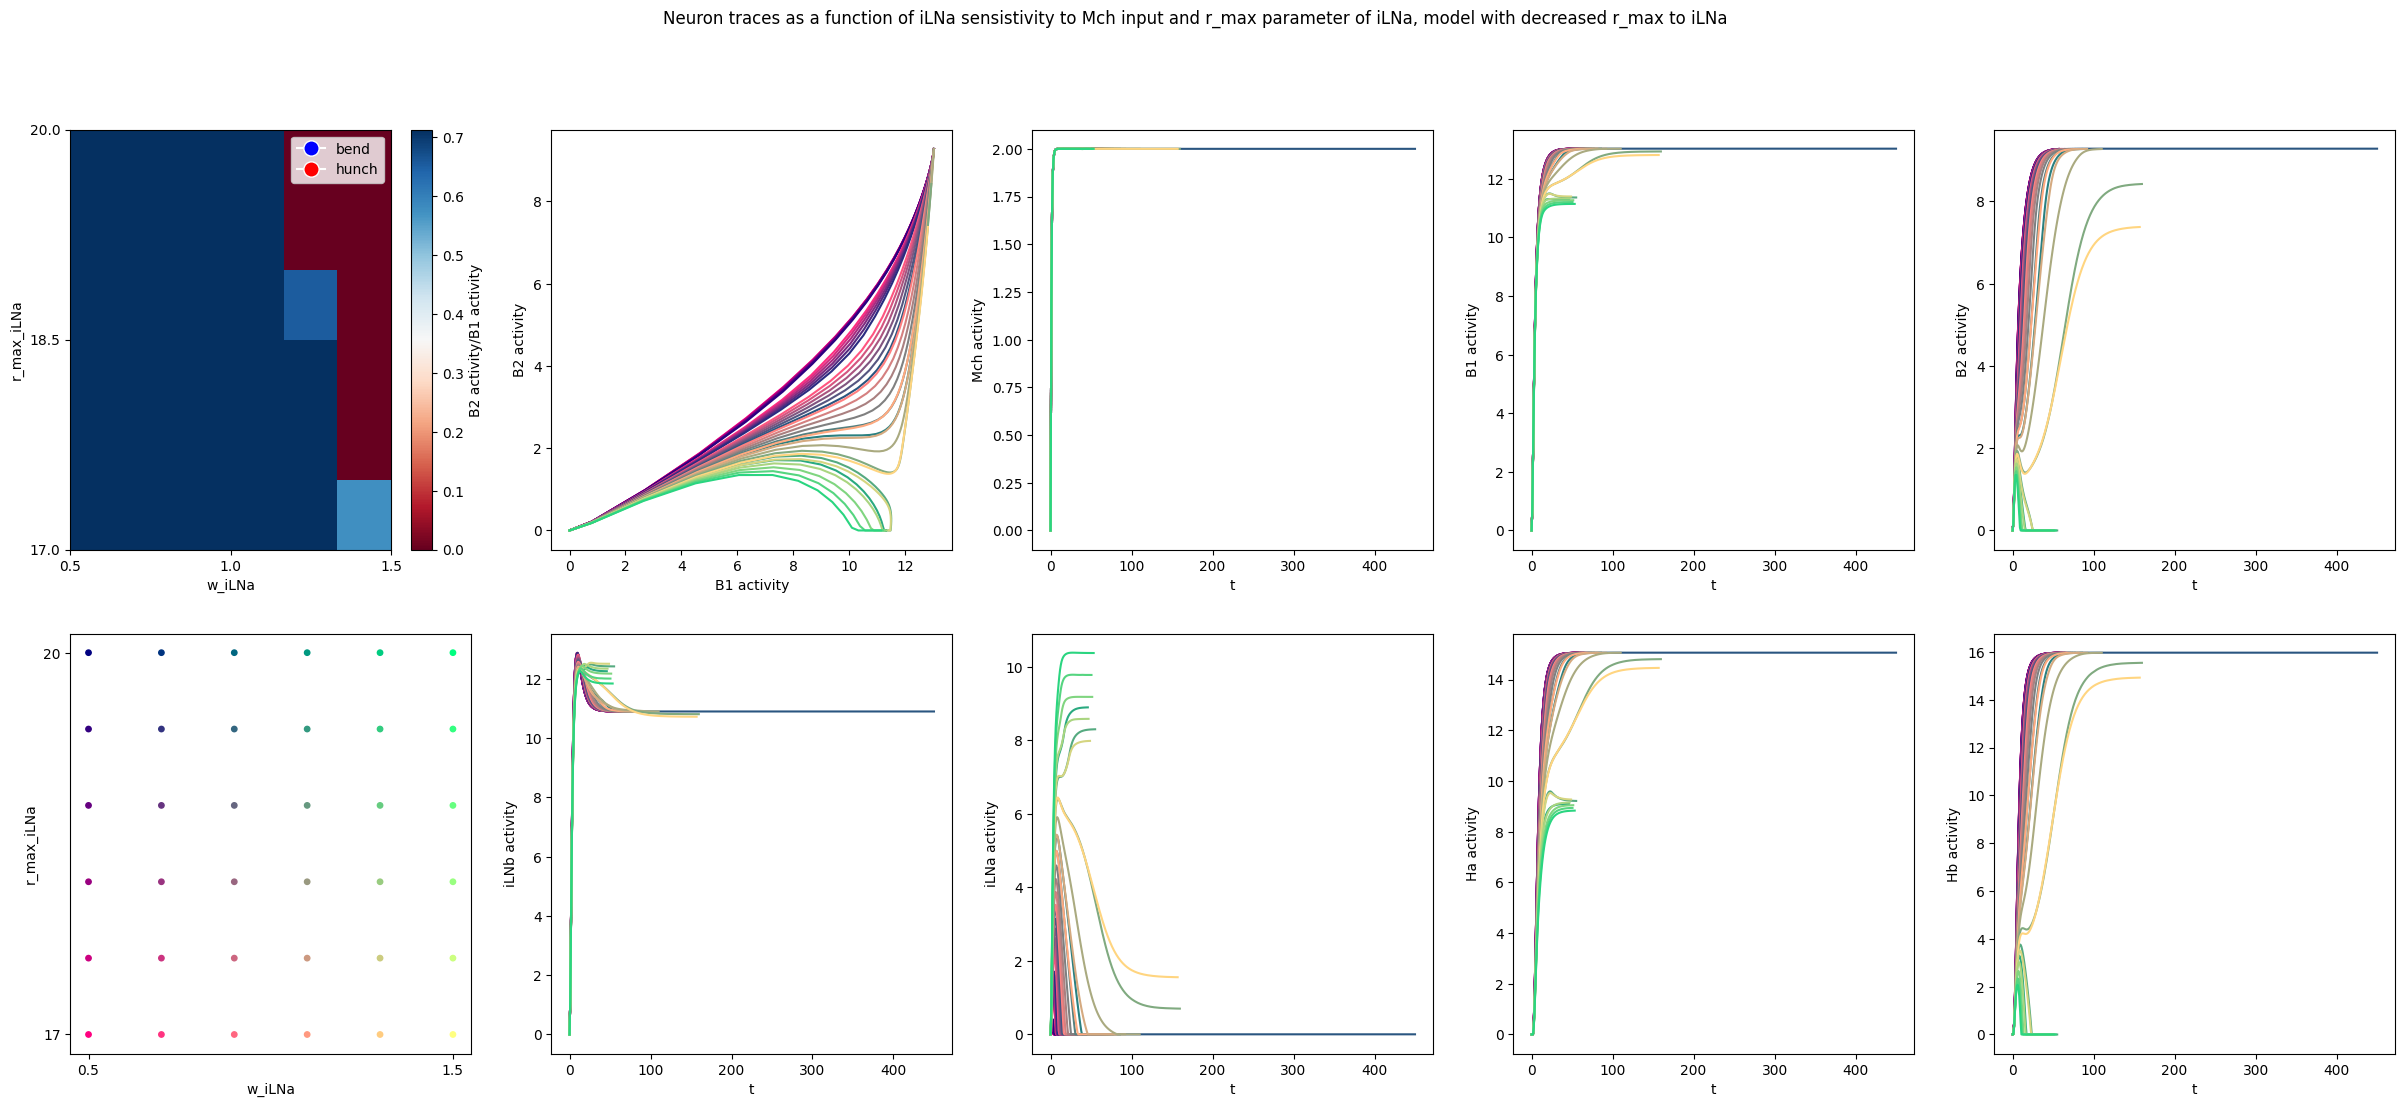

In [44]:
color_grid = create_color_grid(n_weights)

fig, axs = plt.subplots(2,5, figsize=(30,12))

results.plot_ratio_diagram(axs[0,0])
axs[0,0].set_xlabel('w_iLNa')
axs[0,0].set_ylabel('r_max_iLNa')
plot_color_grid(axs[1,0], iLNa_iterator, r_max_iterator)
axs[1,0].set_xlabel('w_iLNa')
axs[1,0].set_ylabel('r_max_iLNa')

for (iLNa, r_max), c in zip(itertools.product(iLNa_iterator, r_max_iterator), color_grid.reshape(-1,3)):
    res = results[(iLNa, r_max)]
    axs[0,1].plot(res.y[Neuron.B1], res.y[Neuron.B2], c=c)

    for ax_idx, neuron, neuron_name in zip([(0,2), (0,3), (0,4), (1,1), (1,2), (1,3), (1,4)],
                                           range(7),
                                           ['Mch', 'B1', 'B2', 'iLNb','iLNa', 'Ha', 'Hb']):
        axs[ax_idx].plot(res.t, res.y[neuron], c=c)

for ax_idx, neuron_name in zip([(0,2), (0,3), (0,4), (1,1), (1,2), (1,3), (1,4)],
                               ['Mch', 'B1', 'B2', 'iLNb','iLNa', 'Ha', 'Hb']):
        axs[ax_idx].set_xlabel('t')
        axs[ax_idx].set_ylabel(neuron_name + ' activity')
axs[0,1].set_xlabel('B1 activity')
axs[0,1].set_ylabel('B2 activity')

fig.suptitle('Neuron traces as a function of iLNa sensistivity to Mch input and r_max parameter of iLNa, model with decreased r_max to iLNa')
plt.savefig('outputs/model_decreased_rmax_to_iLNa/phase_diagram_with_neuron_traces_with_decreased_rmax_to_iLNa.pdf')  

plt.show()

## Compare fed and sucrose trajectories

In [45]:
n_weights = 10

iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, "excitatory", np.linspace(.5,1.5,n_weights))
iLNb_initializer = SimpleInitializer(iLNb=2)

def internalStateCallback(m, p):
    if p == 'fed':
        m.set_r_max(Neuron.iLNa, 18)
    else:
        m.set_r_max(Neuron.iLNa, 20)
internalStateIterator = ParameterIterator(["fed", "sucrose"], internalStateCallback)

results = Model.compute_states_on_grid([iLNb_initializer], [internalStateIterator, iLNa_iterator])

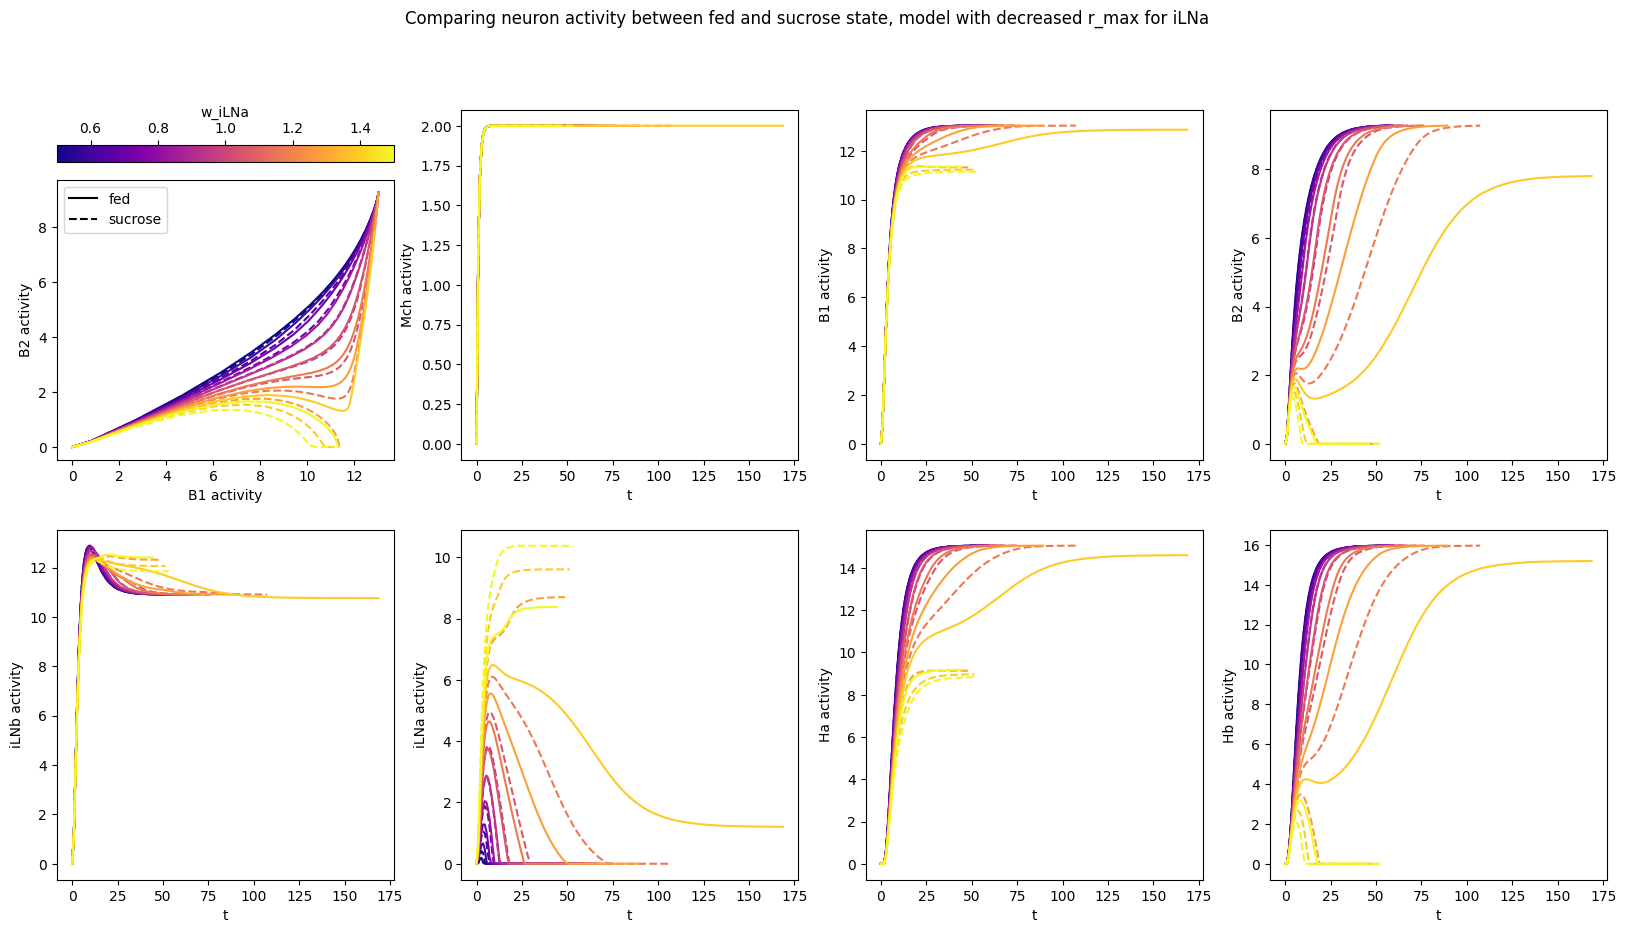

In [46]:
from matplotlib import colormaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = colormaps['plasma']
norm = Normalize(vmin=min(iLNa_iterator), vmax=max(iLNa_iterator))

fig, axs = plt.subplots(2,4, figsize=(20,10))

for iLNa in iLNa_iterator:
    r_fed = results[("fed", iLNa)]
    s_fed = results[("sucrose", iLNa)]
    axs[0,0].plot(r_fed.y[Neuron.B1], r_fed.y[Neuron.B2], color=cmap(norm(iLNa)), ls='-')
    axs[0,0].plot(s_fed.y[Neuron.B1], s_fed.y[Neuron.B2], color=cmap(norm(iLNa)), ls='--')

    for neuron, ax in zip(range(7), axs.ravel()[1:]):
        ax.plot(r_fed.t, r_fed.y[neuron], color=cmap(norm(iLNa)), ls='-')
        ax.plot(s_fed.t, s_fed.y[neuron], color=cmap(norm(iLNa)), ls='--')

axs[0,0].legend(handles=[Line2D([0],[0],ls='-',c='k'), Line2D([0],[0], ls='--', c='k')], labels=['fed', 'sucrose'])
plt.colorbar(ScalarMappable(norm, cmap), ax=axs[0,0], label='w_iLNa', location='top')
axs[0,0].set_xlabel('B1 activity')
axs[0,0].set_ylabel('B2 activity')

for neuron_name, ax in zip(['Mch', 'B1', 'B2', 'iLNb','iLNa', 'Ha', 'Hb'], axs.ravel()[1:]):
    ax.set_xlabel('t')
    ax.set_ylabel(neuron_name+' activity')
    
fig.suptitle('Comparing neuron activity between fed and sucrose state, model with decreased r_max for iLNa')
plt.savefig('outputs/model_decreased_rmax_to_iLNa/fed_vs_sucrose_neuron_activities_with_decreased_rmax_to_iLNa.pdf')
plt.show()

# Combining both hypotheses

Here we want to trace out the LNa threshold value as a function of $r_{max, iLNa}$ and input current to Hb.

We traverse a grid of those parameters and look for the threshold using a built in dichotomy routine.

First, we check that it works properly.

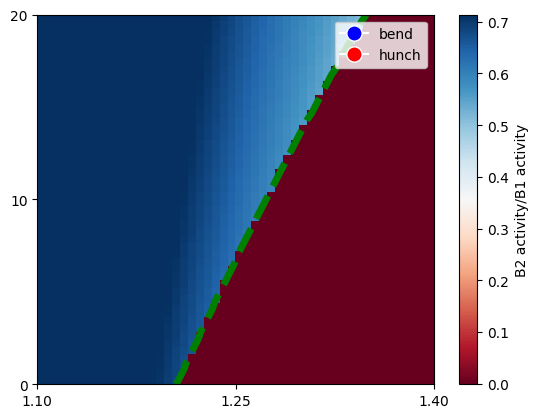

In [47]:
# Computations

n_weights = 50

iLNb_initializer = SimpleInitializer(iLNb=2)
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(1.1,1.4,n_weights))
Hb_iterator = ParameterIterator(np.linspace(0,20,n_weights), lambda model, current : model.set_exogenous_current(Neuron.fbLNHb, current))

results = Model.compute_states_on_grid([iLNb_initializer], [iLNa_iterator, Hb_iterator])

thresholds = Model.compute_thresholds_on_grid([iLNb_initializer], [Hb_iterator])
plt.figure()
results.plot_ratio_diagram(ax=plt.gca())
plt.plot([v for k, v in thresholds.results.items()], [k for k, v in thresholds.results.items()], 'g--', lw=5)
plt.show()

Seems to be working alright. Now let's get going computing threshold values.

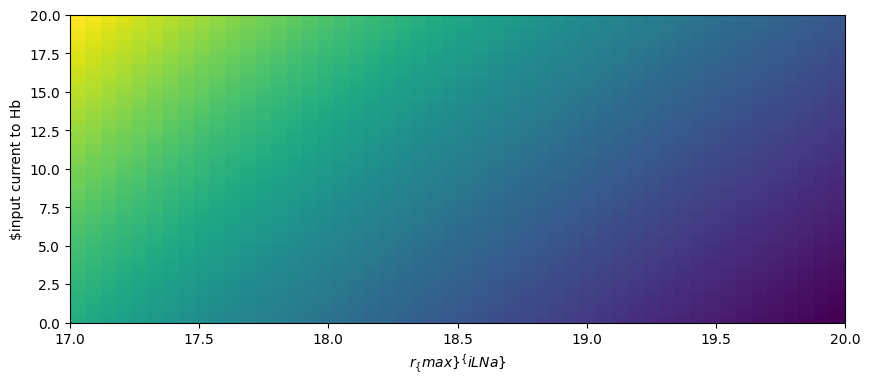

In [48]:
# Computations
from numpy.random import default_rng
rng = default_rng()
n_weights = 50

iLNb_initializer = SimpleInitializer(iLNb=2)
r_max_iterator = ParameterIterator(np.linspace(17,20,n_weights), lambda model, r_max: model.set_r_max(Neuron.iLNa, r_max))
Hb_iterator = ParameterIterator(np.linspace(0,20,n_weights), lambda model, current : model.set_exogenous_current(Neuron.fbLNHb, current))


ths = Model.compute_thresholds_on_grid([iLNb_initializer], [Hb_iterator, r_max_iterator], bracket=[.5,2.5])
thresholds = np.empty((n_weights, n_weights))
for ids, tup in zip(itertools.product(range(n_weights), range(n_weights)), itertools.product(Hb_iterator, r_max_iterator)):
    thresholds[ids] = ths.results[tup]
plt.figure(figsize=(10,4))
plt.imshow(thresholds, origin='lower', extent=[17, 20, 0, 20], aspect='auto')
plt.xlabel("$r_\{max\}^\{iLNa\}$")
plt.ylabel("$input current to Hb")
plt.show()

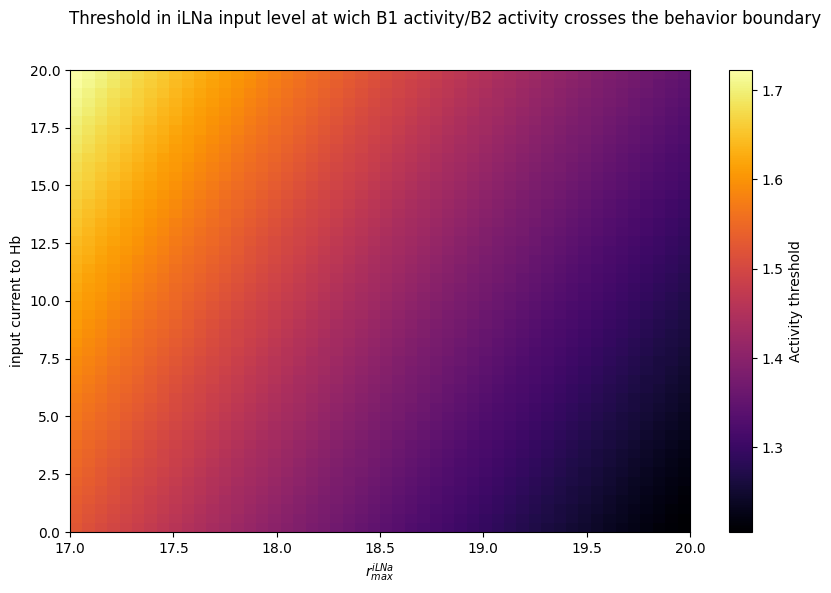

In [49]:
plt.figure(figsize=(10,6))
plt.imshow(thresholds, origin='lower', extent=[17, 20, 0, 20], aspect='auto', cmap='inferno')
plt.colorbar(label='Activity threshold')
plt.xlabel("$r_{max}^{iLNa}$")
plt.ylabel("input current to Hb")
plt.suptitle('Threshold in iLNa input level at wich B1 activity/B2 activity crosses the behavior boundary')
plt.savefig('outputs/combined_model/colormap_threshold.pdf')
plt.show()

In [50]:
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import root_scalar
import plotly.graph_objects as go
from matplotlib.colors import to_rgb
rmax, inputcurr = np.meshgrid(r_max_iterator, Hb_iterator)
th = RegularGridInterpolator((r_max_iterator.iterator, Hb_iterator.iterator), thresholds.transpose())

def solve_for_y(x,z):
      def aux(y):
            return th([x,y])-z
      return root_scalar(aux, method='brentq', bracket=[0,20], x0=10).root
print(solve_for_y(18.65, 1.35))
x_contour = [18.65,19.1,19.65]
z_contour = 3*[1.35]
y_contour = [solve_for_y(x,z) for x, z in zip(x_contour, z_contour)]

x_vert, y_vert, th_vert = 4*[18.5], 4*[8.5], th([18.5,8.5]).item()
z_vert = [th_vert-0.1, th_vert-0.01, th_vert+0.01, th_vert+0.1]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

data = [
        go.Surface(x=rmax, 
                   y=inputcurr, 
                   z=thresholds,
                   contours={'z' : {'show': True,
                                    'start':1.2,
                                    'end':1.7,
                                    'size': 0.075}},
                   opacity=0.7,
                   colorbar={'title':'behavior threshold'}),
      
        go.Scatter3d(x=x_contour,
                     y=y_contour,
                     z=z_contour,
                     marker={'size':4, 'color':'red'},
                     mode='markers',
                     showlegend=False),

        go.Scatter3d(x=[18.5,18.5],
                     y=[8.5,8.5],
                     z=[1.15,1.65],
                     line={'color':'darkblue',
                           'width':4},
                     mode='lines',
                     showlegend=False),

        go.Scatter3d(x=x_vert,
                     y=y_vert,
                     z=z_vert,
                     marker={'size':4, 'color':[to_rgb(c) for c in colors]},
                     mode='markers',
                     showlegend=False)
        
]

layout = {
      'scene': {
            'camera':{
                  'eye':{'x':.39, 'y':-2.47, 'z':.65}
                  },
            'xaxis_title': 'r_max for iLNa',
            'yaxis_title': 'Input current to Hb',
            'zaxis_title': 'Affinity between input and iLNa',

            },
            'autosize':False,
            'width':700,
            'height':700
}
fig = go.Figure(data=data, layout=layout)

fig.show()
fig.write_image('outputs/combined_model/3d_threshold_plotly.pdf')
fig.write_image('outputs/combined_model/3d_threshold_plotly.png')

2.857142857142808


Now that the 3d plot is ready I must prepare the accompanying plots. Let us start with the 4 dots on a vertical line.

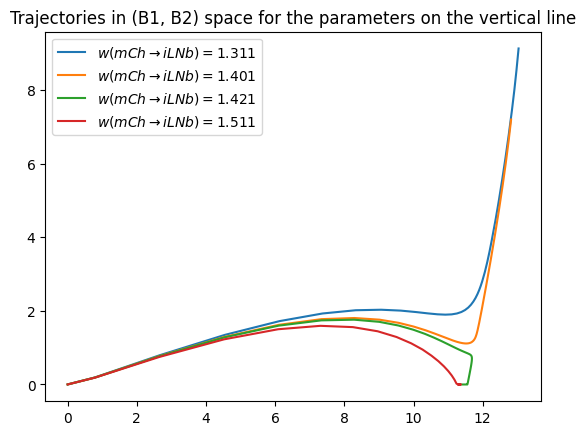

In [51]:
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', z_vert)
iLNb_initializer = SimpleInitializer(iLNb=2)

def r_max_initializer(model):
    model.r_max[Neuron.iLNa] = x_vert[0]
    model.update()
r_max_initializer = ModelInitializer(r_max_initializer)

def Hb_initializer(model):
    model.exogenous_current[Neuron.fbLNHb] = y_vert[0]
    model.update()
Hb_initializer = ModelInitializer(Hb_initializer)

results = Model.compute_states_on_grid([iLNb_initializer, r_max_initializer, Hb_initializer], [iLNa_iterator])

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
plt.figure()
for iLNa, c in zip(iLNa_iterator, colors):
    res = results.results[(iLNa,)]
    plt.plot(res.y[Neuron.B1,:], res.y[Neuron.B2,:], c=c)
plt.legend(labels=[r"$w(mCh \rightarrow iLNb) = $"+f'{z:.3f}' for z in z_vert])
plt.title('Trajectories in (B1, B2) space for the parameters on the vertical line')
plt.savefig('outputs/combined_model/vertical_lines.pdf')
plt.savefig('outputs/combined_model/vertical_lines.png')
plt.show()

Finalement, faisons trois plots balayant les valeurs de iLNa, pour les trois jeux de paramètres sur la ligne de niveau.

In [52]:
iLNb_initializer = SimpleInitializer(iLNb=2)
iLNa_iterator = SynapseIterator(Neuron.Mch, Neuron.iLNa, 'excitatory', np.linspace(.5,1.5,10))

def tuple_iterator(model, param):
     rmax, input_current = param
     model.r_max[Neuron.iLNa] = rmax
     model.exogenous_current[Neuron.fbLNHb] = input_current
     model.update()
tuple_iterator = ParameterIterator(list(zip(x_contour, y_contour)), tuple_iterator)

results = Model.compute_states_on_grid([iLNb_initializer], [tuple_iterator, iLNa_iterator])

/tmp/ipykernel_13655/1336588212.py:16: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



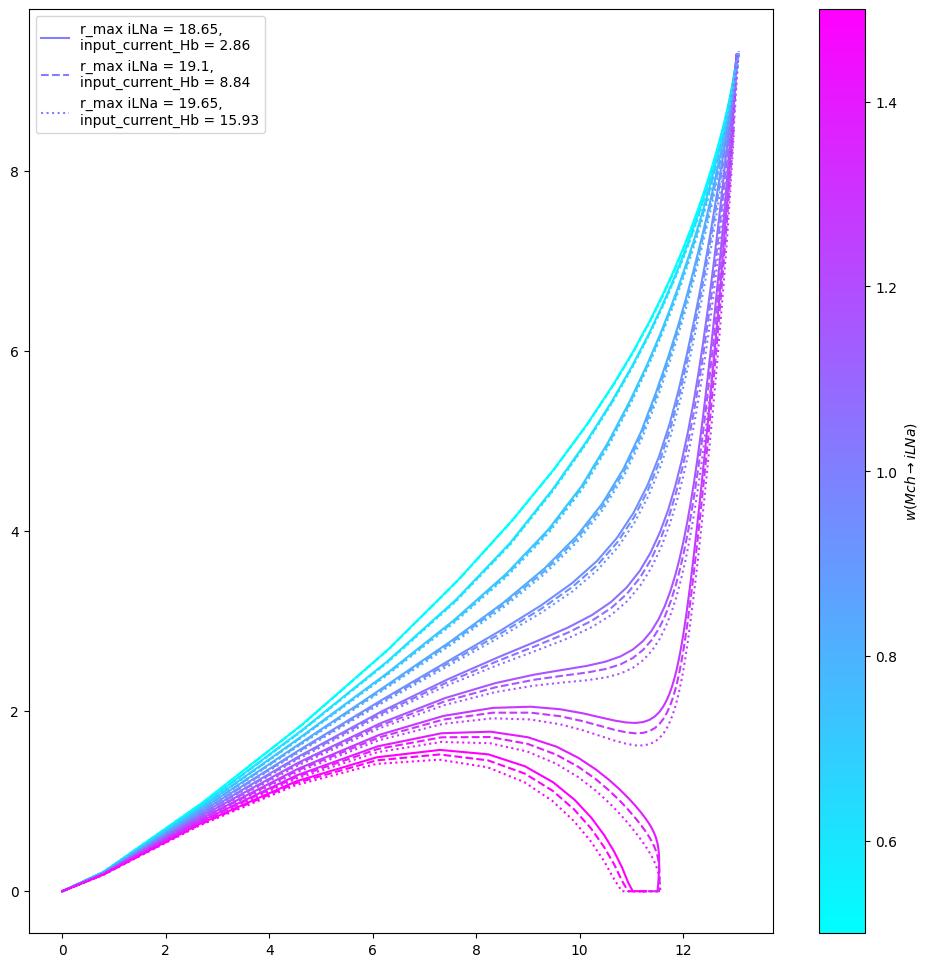

In [53]:
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize

norm=Normalize(min(iLNa_iterator), max(iLNa_iterator))
cmap = get_cmap('cool')
linestyles = ['-', '--', ':']
plt.figure(figsize=(12,12))
for t, ls in zip(tuple_iterator, linestyles):
    for iLNa in iLNa_iterator:
        res = results.results[(t,iLNa)]
        plt.plot(res.y[Neuron.B1,:], res.y[Neuron.B2,:], c=cmap(norm(iLNa)), ls=ls)

plt.legend(handles=[Line2D([],[], c=cmap(.5), ls=ls) for ls in linestyles],
           labels=[f'r_max iLNa = {r}, \ninput_current_Hb = {i:.2f}' for (r,i) in tuple_iterator])
plt.colorbar(ScalarMappable(norm, cmap), label=r'$w(Mch \rightarrow iLNa)$')
plt.savefig('outputs/combined_model/contourlines.pdf')
plt.savefig('outputs/combined_model/contourlines.png')
plt.show()

# Copy outputs to drive

In [54]:
%%bash
cp -R "outputs/." "/home/alexandre/Insync/blanc.alexandre.perso@gmail.com/Google Drive - Shared with me/For_submission/Figures/plots_from_alexandre"